<a href="https://colab.research.google.com/github/julia-zovka/Detecao_de_anomalias_Shill_Bidding-/blob/main/aprendizado_de_maqina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTANDO BIBLIOTECAS**

In [ ]:

import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from math import sqrt


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import IsolationForest
from tqdm.notebook import tqdm


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import IsolationForest

import re
import torch
import torch.nn as nn
import torch.optim as optim



#**EDA**

##**BAIXANDO OS DADOS**

In [ ]:
# Comando para baixar o arquivo .zip da UCI
!wget https://archive.ics.uci.edu/static/public/562/shill+bidding+dataset.zip -O /content/Shill_Bidding.zip

--2025-12-15 15:04:47--  https://archive.ics.uci.edu/static/public/562/shill+bidding+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/Shill_Bidding.zip’

/content/Shill_Bidd     [  <=>               ] 537.52K  2.19MB/s    in 0.2s    

2025-12-15 15:04:48 (2.19 MB/s) - ‘/content/Shill_Bidding.zip’ saved [550418]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Coloca no drive, para não precisar fazer todo esse processo de novo**

In [ ]:
!mv /content/Shill_Bidding.zip /content/drive/MyDrive/Shill_Bidding.zip

In [ ]:
!unzip -q /content/drive/MyDrive/Shill_Bidding.zip -d /content/drive/MyDrive/Shill_Bidding/

replace /content/drive/MyDrive/Shill_Bidding/Shill Bidding Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y


In [ ]:
os.listdir('/content/drive/MyDrive/Shill_Bidding/')

['pos_processed', 'Shill Bidding Dataset.csv']

**Lendo do drive**

In [ ]:
pasta_destino = '/content/drive/MyDrive/Shill_Bidding/'

df = pd.read_csv(pasta_destino + 'Shill Bidding Dataset.csv')

**Descrição do dataset**

**Record ID**: Unique identifier of a record in the dataset.


**Auction ID**: Unique identifier of an auction.


**Bidder ID:** Unique identifier of a bidder.


**Bidder Tendency**: Indicates if the bidder participates in auctions of a few sellers.


**Bidding Ratio**: A shill bidder participates more frequently to raise the auction price and attract higher bids from legitimate participants.


**Successive Outbidding**: A shill bidder successively outbids himself even though he is the current winner to increase the price gradually with small consecutive increments.


**Last Bidding**: A shill bidder becomes inactive at the last stage of the auction (more than 90\% of the auction duration) to avoid winning the auction.


**Auction Bids**: Auctions with SB activities tend to have a much higher number of bids than the average of bids in concurrent auctions.


**Auction Starting Price**:  a shill bidder usually offers a small starting price to attract legitimate bidders into the auction.


**Early Bidding:** A shill bidder tends to bid pretty early in the auction (less than 25\% of the auction duration) to get the attention of auction users.


**Winning Ratio:** A shill bidder competes in many auctions but hardly wins any auctions.


**Auction Duration:**  How long an auction lasted.


**Class**: 0 for normal behaviour bidding; 1 for otherwise.

##**ANÁLISE EXPLORATÓRIA DE DADOS**

In [ ]:
print(df.columns)

Index(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class'],
      dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Record_ID               6321 non-null   int64  
 1   Auction_ID              6321 non-null   int64  
 2   Bidder_ID               6321 non-null   object 
 3   Bidder_Tendency         6321 non-null   float64
 4   Bidding_Ratio           6321 non-null   float64
 5   Successive_Outbidding   6321 non-null   float64
 6   Last_Bidding            6321 non-null   float64
 7   Auction_Bids            6321 non-null   float64
 8   Starting_Price_Average  6321 non-null   float64
 9   Early_Bidding           6321 non-null   float64
 10  Winning_Ratio           6321 non-null   float64
 11  Auction_Duration        6321 non-null   int64  
 12  Class                   6321 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 642.1+ KB


###**ANÁLISE DE DADOS FALTANTES, DUPLICATAS OU INCONSISTENTE**

**Valor faltante**

In [ ]:
df.isna().sum()


Record_ID                 0
Auction_ID                0
Bidder_ID                 0
Bidder_Tendency           0
Bidding_Ratio             0
Successive_Outbidding     0
Last_Bidding              0
Auction_Bids              0
Starting_Price_Average    0
Early_Bidding             0
Winning_Ratio             0
Auction_Duration          0
Class                     0
dtype: int64

**Valores duplicados**

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 6321, tamanho final 6321 | Descartadas 0 duplicadas


**Valores inconssistentes**

In [ ]:
# Filtra as colunas numéricas
df_numeric = df.select_dtypes(include=np.number)

#Aplica np.isinf() apenas nas colunas numéricas
contagem_infinitos = df_numeric.apply(np.isinf).sum()

print("Contagem de valores infinitos por coluna:")
infinitos_encontrados = contagem_infinitos[contagem_infinitos > 0]
print(infinitos_encontrados)

Contagem de valores infinitos por coluna:
Series([], dtype: int64)


###**ANÁLISE UNIVARIADA**

In [ ]:
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Variáveis numéricas: {numeric_vars}")


categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
print(f"Variáveis categóricas: {categorical_vars}")

Variáveis numéricas: ['Record_ID', 'Auction_ID', 'Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio', 'Auction_Duration', 'Class']
Variáveis categóricas: ['Bidder_ID']


1. ANÁLISE DE VARIÁVEIS NUMÉRICAS

**Analisando os intervalos de cada variável**

In [ ]:
for var in numeric_vars:
  print(var)
  print(df[var].agg(['min', 'max']).to_frame().to_string(header=False))
  print('\n')


Record_ID
min      1
max  15144


Auction_ID
min     5
max  2538


Bidder_Tendency
min  0.0
max  1.0


Bidding_Ratio
min  0.011765
max  1.000000


Successive_Outbidding
min  0.0
max  1.0


Last_Bidding
min  0.0000
max  0.9999


Auction_Bids
min  0.000000
max  0.788235


Starting_Price_Average
min  0.000000
max  0.999935


Early_Bidding
min  0.0000
max  0.9999


Winning_Ratio
min  0.0
max  1.0


Auction_Duration
min   1
max  10


Class
min  0
max  1




In [ ]:
# Análise dos outliers de cada variável
for var in numeric_vars:
    if var in df.columns:
        print(f"\n {var.upper()}:")
        data = df[var].dropna()


        # Outliers (IQR method)
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
        print(f"  Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")


 RECORD_ID:
  Outliers: 0 (0.0%)

 AUCTION_ID:
  Outliers: 0 (0.0%)

 BIDDER_TENDENCY:
  Outliers: 628 (9.9%)

 BIDDING_RATIO:
  Outliers: 430 (6.8%)

 SUCCESSIVE_OUTBIDDING:
  Outliers: 843 (13.3%)

 LAST_BIDDING:
  Outliers: 0 (0.0%)

 AUCTION_BIDS:
  Outliers: 0 (0.0%)

 STARTING_PRICE_AVERAGE:
  Outliers: 0 (0.0%)

 EARLY_BIDDING:
  Outliers: 0 (0.0%)

 WINNING_RATIO:
  Outliers: 0 (0.0%)

 AUCTION_DURATION:
  Outliers: 0 (0.0%)

 CLASS:
  Outliers: 675 (10.7%)


**Visualização das distribuições das variáveis**

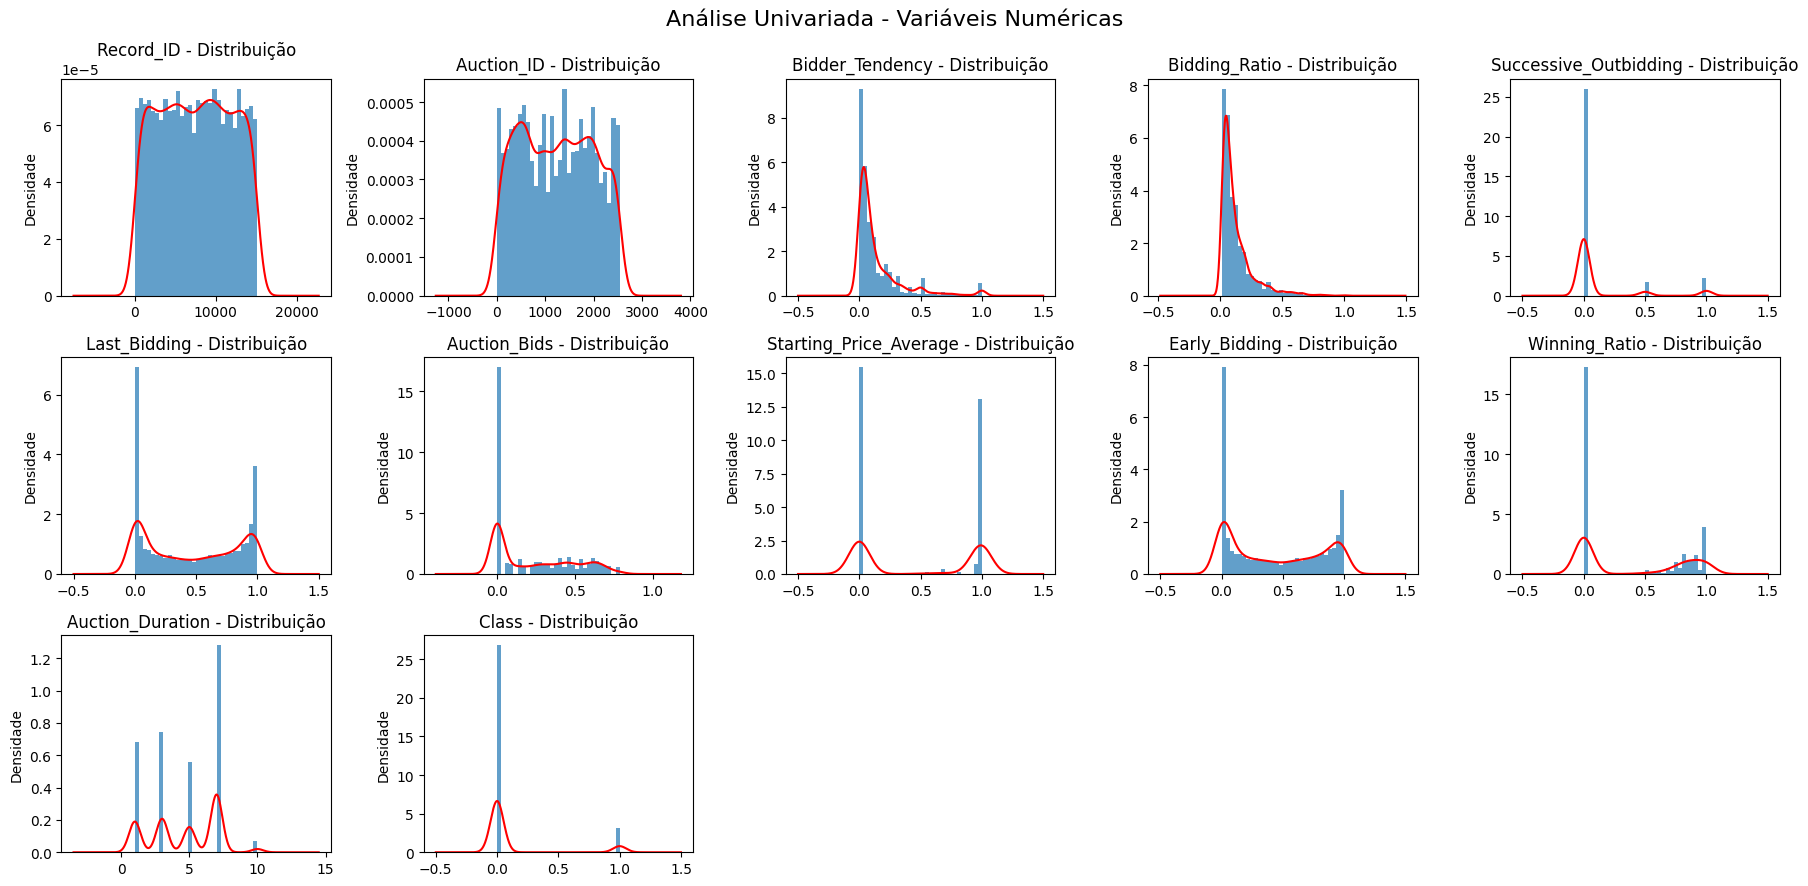

In [ ]:
# Visualizações das variáveis numéricas
total_vars = len(numeric_vars)
cols = 5
rows = (total_vars + cols - 1) // cols  # mesmo padrão, só calcula número de linhas

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
fig.suptitle('Análise Univariada - Variáveis Numéricas', fontsize=16)

# Garantir que axes seja 2D sempre
axes = np.array(axes).reshape(rows, cols)

for i, var in enumerate(numeric_vars):
    if var in df.columns:
        row = i // 5
        col = i % 5
        # Histograma + Densidade
        axes[row, col].hist(df[var].dropna(), bins=30, alpha=0.7, density=True)
        df[var].dropna().plot.density(ax=axes[row, col], color='red')
        axes[row, col].set_title(f'{var} - Distribuição')
        axes[row, col].set_ylabel('Densidade')

# Remove subplots vazios
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

Analisando os resultados das distribuições das amostras constatamos que variáveis como Sucessive_Outbidding e Winning_Ratio possuem maior densidade no valor 0, indicando que lancistas geralmente não dão lances consecutivos e frequentemente não ganham leilões uma vez que as tentativas fraudulentas não tem o objetivo de ganhar e das que querem def ato comprar só uma consegue.

**Plotando Boxplots**

importante para identificar medianas e outliers

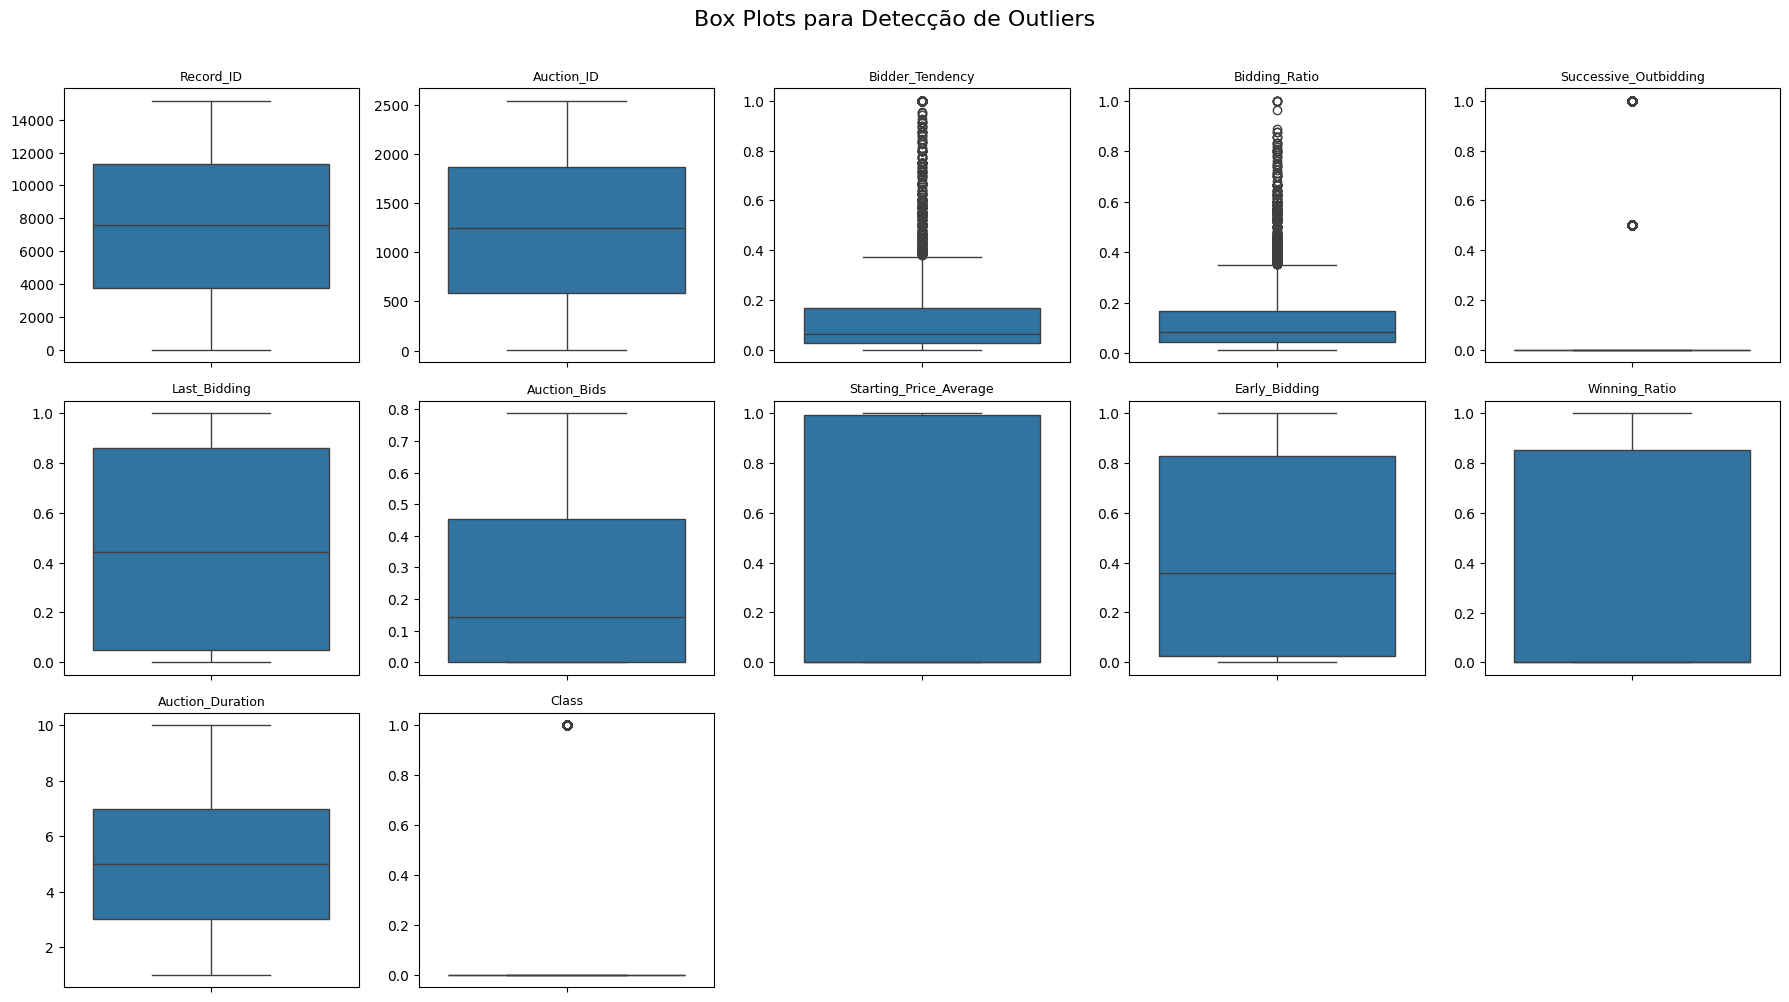

In [ ]:
# Box plots para identificar outliers

# Garante que estamos pegando apenas as colunas numéricas do seu DataFrame (df)
numeric_data = df[numeric_vars].select_dtypes(include=[np.number])
variables_to_plot = numeric_data.columns
total_vars = len(variables_to_plot) # Será 115 neste caso

cols = 5
rows = math.ceil(total_vars / cols)
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3.5))
fig.suptitle('Box Plots para Detecção de Outliers', fontsize=16)
axes = np.array(axes).reshape(rows, cols)

# 4. Loop de Plotagem
for i, var in enumerate(variables_to_plot):
    row = i // cols
    col = i % cols

    # Gera o Box Plot no subplot correto
    sns.boxplot(y=df[var], ax=axes[row, col])

    # Define o título de cada subplot
    axes[row, col].set_title(f'{var}', fontsize=9)
    axes[row, col].set_ylabel('') # Remove o rótulo y para não sobrecarregar
    axes[row, col].set_xlabel('') # Remove o rótulo x

# 5. Remoção de Subplots Vazios (se houver)
# Remove subplots vazios no final da última linha (se total_vars não for múltiplo de 5)
for j in range(total_vars, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Ajuste o layout com espaço para o suptitle
plt.show()

**Resultados extraídos:**

- A maioria dos bidders não faz muitos lances durante as sessões

- O starting_price é muito diverso por se tratar de itens de valores diferentes

- A maioria dos lances não são dos bidders superando a si mesmos, indicando que a maior parte dos registros são legítimos

- A maioria dos leilões tem duração de 5 horas



Existem  6321 registros de 807 sessões de leilão diferentes

In [ ]:
df['Record_ID'].nunique()

6321

In [ ]:
df['Auction_ID'].nunique()

807

**Análise da target**

In [ ]:
df['Class'].value_counts()

Class
0    5646
1     675
Name: count, dtype: int64

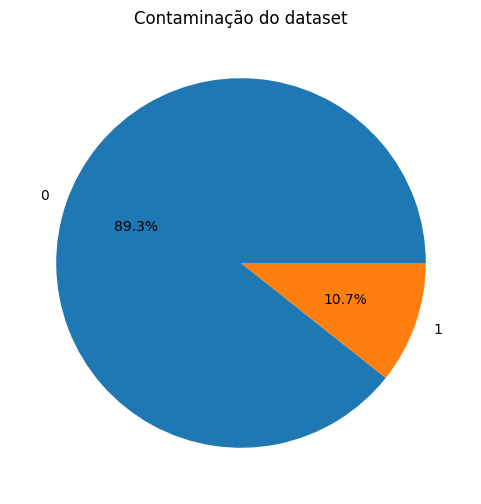

In [ ]:

counts = df['Class'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index.astype(str), autopct='%1.1f%%')
plt.title("Contaminação do dataset")
plt.show()


**0=Lances Benignos**
**1==Lances Fraudulentos**

Existem muito mais registro de benignos do que lances fraudulentos

2. ANÁLISE DE VARIÁVEIS CATEGÓRICAS

In [ ]:
print(f"Variáveis categóricas: {categorical_vars}")

Variáveis categóricas: ['Bidder_ID']


In [ ]:
# Análise de frequências
for var in categorical_vars:
    if var in df.columns:
        print(f"\n📊 {var.upper()}:")
        freq_table = df[var].value_counts()

        freq_df = pd.DataFrame({
            'Frequência': freq_table,
        })
        print(freq_df)



📊 BIDDER_ID:
           Frequência
Bidder_ID            
a***a             112
n***t              85
e***e              67
i***a              50
r***r              49
...               ...
.***g               1
l***6               1
6***s               1
7***2               1
z***.               1

[1054 rows x 1 columns]


Fizemos essa análise de frenquência sobre cada comprador no sentido de entender qual tem mais registros, que no caso foi a***a. Dentro das 6321 instâncias , existem 1054 compradores que fazem múltiplos lances.

suposição: o bidder com mais lance provavelmente é um shill bidder

###**ANÁLISE BIVARIADA**

**Calculando a correlação das variáveis numéricas**

In [ ]:
# Calcular matriz de correlação
correlation_matrix = df[numeric_vars].corr()

In [ ]:
target_var = 'Class'

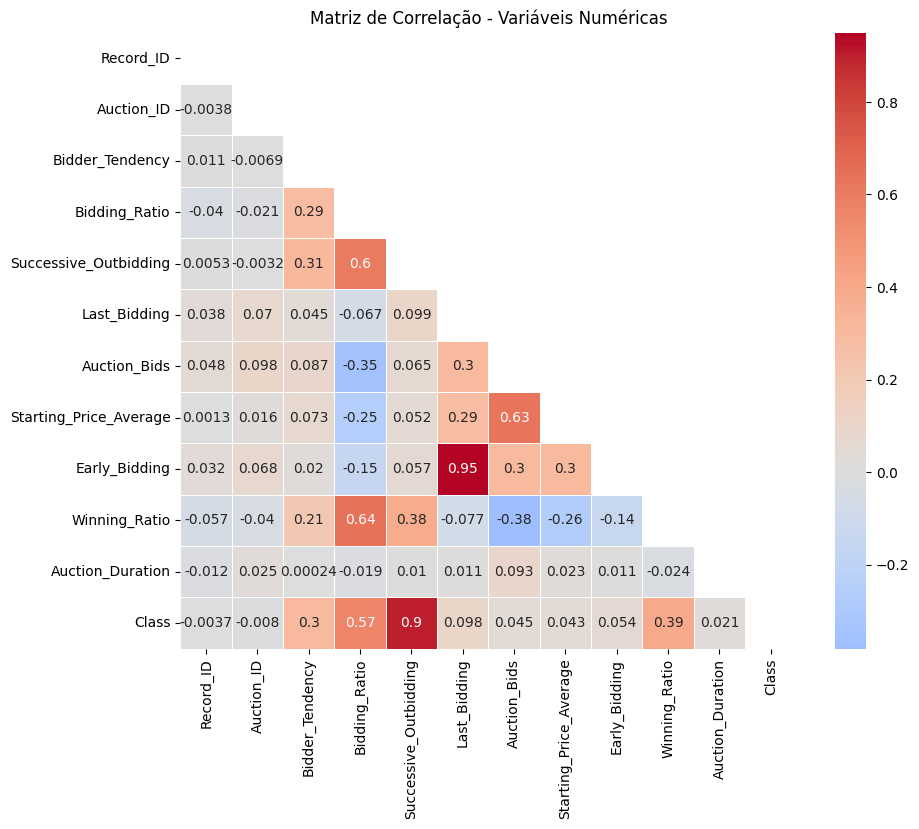

In [ ]:
# Visualizar heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()


***Successive_Outbidding*** tem forte relação com a ***Class*** (0.90), reforçando que auto-superar lances é um dos sinais mais evidentes de shill bidding.



Além disso, variáveis como:     
- ***Bidding_Ratio*** e ***Winning_Ratio***

- ***Auction_Bids*** e ***Starting_Price_Average***,

- ***Bidding_Ratio*** e ***Successive_Outbidding***

 tem correlações moderadas entre si.

 Notamos tabém que ***Bidding_Ratio***,***Winning_Ratio***
juntamente com ***Successive_Outbidding*** são bons indicadores para detecção de fraude.






In [ ]:
# Criar lista de pares (col1, col2, correlação)
corr_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Renomear colunas
corr_pairs.columns = ['Variável_1', 'Variável_2', 'Correlação']

# Ordenar por correlação absoluta
corr_pairs = corr_pairs.reindex(
    corr_pairs['Correlação'].abs().sort_values(ascending=False).index
)

corr_pairs.head(10)

Variável_1              Variável_2  Correlação
47           Last_Bidding           Early_Bidding    0.950096
44  Successive_Outbidding                   Class    0.901035
35          Bidding_Ratio           Winning_Ratio    0.642905
51           Auction_Bids  Starting_Price_Average    0.629086
30          Bidding_Ratio   Successive_Outbidding    0.604828
37          Bidding_Ratio                   Class    0.569435
64          Winning_Ratio                   Class    0.394122
42  Successive_Outbidding           Winning_Ratio    0.382002
53           Auction_Bids           Winning_Ratio   -0.381442
32          Bidding_Ratio            Auction_Bids   -0.347831

###**ANÁLISE MULTIVARIADA**

####**Pairplot em cima de Successive_Outbidding, Bidding_Ratio e Class**

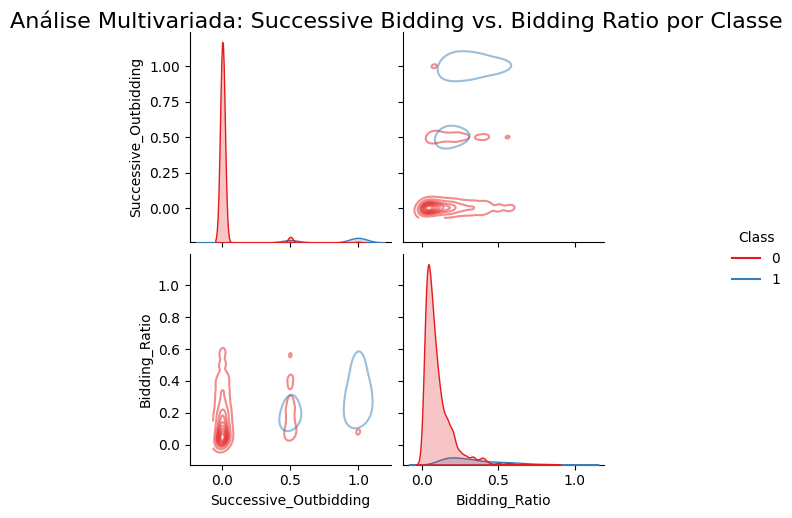

In [ ]:
features_numericas = ['Successive_Outbidding', 'Bidding_Ratio']

sns.pairplot(
    data=df,
    vars=features_numericas,
    hue='Class',
    palette='Set1',
    kind='kde',
    plot_kws={'alpha': 0.5}
)

plt.suptitle('Análise Multivariada: Successive Bidding vs. Bidding Ratio por Classe', y=1.02, fontsize=16, )
plt.show()


**Resultados Extraidos**

- **Gráfico de densidade conjunta**

   Classe 0 (Vermelho):Esta classe é a majoritária e está concentrada em uma região de baixíssimos valores para ambas as features (Successive_Outbidding e Bidding_Ratio).A maior densidade está muito próxima da origem $(0, 0)$ ou em valores muito próximos de zero, indicando um comportamento de bidding muito consistente, baixo ou normal.

   A Classe 1 (azul) apresenta densidades significativas em regiões de valores mais altos de Bidding_Ratio (próximo a $1.5$ a $2.0$) e Successive_Outbidding (entre $5$ e $10$).


- **Análise Marginal**

  -**Diagonal Superior Esquerda**
    Este gráfico mostra a distribuição da variável Successive_Outbidding sozinha, separada pelas classes.

    Classe 0 (Vermelho): Apresenta uma distribuição estreita e alta (baixa variância)

    Classe 1 (Azul): Apresenta uma distribuição com média deslocada para a direita (valores mais altos), e é mais espalhada (maior variância) do que a Classe 0.

    Significado: A variável Successive_Outbidding sozinha já é um forte indicador: valores baixos sugerem a Classe 0, e valores mais altos sugerem a Classe 1.


  -**Diagonal Inferior Direita**
    Este gráfico mostra a distribuição da variável Bidding_Ratio sozinha, separada pelas classes.
  
    Classe 0 (Vermelho): Apresenta uma distribuição estreita e alta com média próxima de $(0.5)$.
    
    Classe 1 (Azul): Apresenta uma distribuição com média deslocada para a direita (valores mais altos), próxima de $(1.5)$ a $(2)$.
    
    Significado: A variável Bidding_Ratio também é bem discriminativa, com faixas de valores claramente diferentes para as duas classes.



####**Separação do Bidding Ratio em grupos e análise com class**

In [ ]:
print(df['Bidding_Ratio'].max())
print(df['Bidding_Ratio'].min())

1.0
0.011764706


In [ ]:
df_copy=df.copy()
df_copy['Bidding_Group'] = pd.cut(df_copy['Bidding_Ratio'], bins=[0,0.2, 0.4, 0.6 , 0.8, 1],
                          labels=['Baixo (0 - 0.2)', 'Médio (0.2 - 0.4)', 'Alto (0.4 - 0.6)', 'Muito Alto (0.6 - 0.8)', 'Extremo (0.8 - 1)'],
                          right=True, # Intervalo fechado na direita (<=)
                          include_lowest=True # Incluir o valor 0)
)

In [ ]:
print(df.columns)

Index(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class'],
      dtype='object')


In [ ]:
print(df_copy.columns)

Index(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class', 'Bidding_Group'],
      dtype='object')



### Análise da Taxa de Anomalia por Bidding Group ###
                        Total_Count  Anomalia_Count  Taxa_Anomalia
Bidding_Group                                                     
Baixo (0 - 0.2)                5290             192           3.63
Médio (0.2 - 0.4)               742             273          36.79
Alto (0.4 - 0.6)                200             133          66.50
Muito Alto (0.6 - 0.8)           71              61          85.92
Extremo (0.8 - 1)                18              16          88.89


/tmp/ipython-input-4260451242.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analise_grupos = df_copy.groupby('Bidding_Group')['Class'].agg(['count', 'sum'])
/tmp/ipython-input-4260451242.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


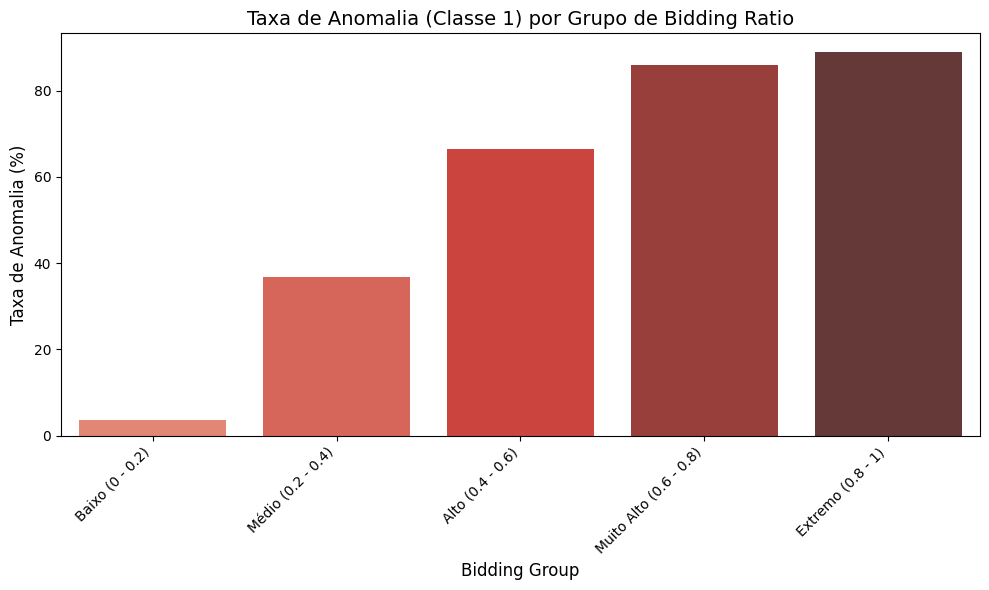

In [ ]:
# Calcular a contagem total de cada grupo e a contagem de anomalias (Classe 1)
analise_grupos = df_copy.groupby('Bidding_Group')['Class'].agg(['count', 'sum'])
analise_grupos.columns = ['Total_Count', 'Anomalia_Count'] # Renomeia 'sum' para 'Anomalia_Count'

# Calcular a Taxa de Anomalia (Classe 1 / Total)
analise_grupos['Taxa_Anomalia'] = (analise_grupos['Anomalia_Count'] / analise_grupos['Total_Count']) * 100

print("\n### Análise da Taxa de Anomalia por Bidding Group ###")
print(analise_grupos.to_string(float_format="{:.2f}".format))

# --- Visualização em Gráfico de Colunas ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x=analise_grupos.index,
    y='Taxa_Anomalia',
    data=analise_grupos,
    palette='Reds_d' # Tons de vermelho para destacar a anomalia
)

plt.title('Taxa de Anomalia (Classe 1) por Grupo de Bidding Ratio', fontsize=14)
plt.xlabel('Bidding Group', fontsize=12)
plt.ylabel('Taxa de Anomalia (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotação para os rótulos caberem melhor
plt.tight_layout()
plt.show()

Os registros de lances fraudulentos estáo concentrados em instâncias com o **Bidding_Ratio** mais alto

##**PRÉ PROCESSAMENTO DOS DADOS**

##### **1. TRATAMENTO DE MISSING VALUES E DUPLICATAS**

Não tinha **missing Values** nem **duplicatas** para tratar

#####**2. ENCODING DE VARIÁVEIS CATEGÓRICAS**


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Record_ID               6321 non-null   int64  
 1   Auction_ID              6321 non-null   int64  
 2   Bidder_ID               6321 non-null   object 
 3   Bidder_Tendency         6321 non-null   float64
 4   Bidding_Ratio           6321 non-null   float64
 5   Successive_Outbidding   6321 non-null   float64
 6   Last_Bidding            6321 non-null   float64
 7   Auction_Bids            6321 non-null   float64
 8   Starting_Price_Average  6321 non-null   float64
 9   Early_Bidding           6321 non-null   float64
 10  Winning_Ratio           6321 non-null   float64
 11  Auction_Duration        6321 non-null   int64  
 12  Class                   6321 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 642.1+ KB


O ***Bidder_ID*** é um identificador único de cada participante do leilão e não contém informação útil para o aprendizado.
Por isso, **esta feature será removida**; caso contrário, o modelo acabaria
memorizando participantes específicos em vez de aprender padrões de fraude, aumentando o risco de overfitting.

In [ ]:
df.drop('Bidder_ID', axis='columns', inplace=True)

In [ ]:
print(df.columns)

Index(['Record_ID', 'Auction_ID', 'Bidder_Tendency', 'Bidding_Ratio',
       'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids',
       'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio',
       'Auction_Duration', 'Class'],
      dtype='object')


#####**3. DIVISÃO EM CONJUNTO DE TREINO, VALIDAÇÃO E TESTE**

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos serão capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Dever ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [ ]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

In [ ]:
df_train = df.query('Class == 0').sample(frac=0.6, random_state=RANDOM_SEED) ## conjunto de treino só com legítimos (benignos)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Class', axis='columns') ## tira a coluna da target

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Class', axis='columns'), df_val_test['Class'], test_size=0.65, stratify=df_val_test['Class'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val = classes_val
y_test = classes_test


In [ ]:
del df_train, df_val_test

In [ ]:
# Tamanho dos conjuntos (Número de linhas)
print(f"Tamanho de X_train (Features de Treino Benigno): {X_train.shape[0]} linhas")
print(f"Tamanho de X_test (Features de Teste Mista): {X_test.shape[0]} linhas")
print(f"Tamanho de X_val (Features de Validação Mista): {X_val.shape[0]} linhas")

Tamanho de X_train (Features de Treino Benigno): 3388 linhas
Tamanho de X_test (Features de Teste Mista): 1907 linhas
Tamanho de X_val (Features de Validação Mista): 1026 linhas


#####**4. DROPANDO FEATURES CORRELACIONADAS**

Removendo ***Early_Bidding***

As variáveis ***Last_Bidding*** e ***Early_Bidding*** apresentam correlação muito alta (0.95)

Como na **Análise Univariada** suas distribuições foram quase iguais, optamos por remover ***Early_Bidding***.
Mantivemos ***Last_Bidding*** por ser a feature mais informativa por ter maior correlação com a feature ***Class***, como vimos na **Análise Bivariada**.

In [ ]:
X_train.drop('Early_Bidding', axis='columns', inplace=True)
X_val   = X_val.drop(columns='Early_Bidding')
X_test  = X_test.drop(columns='Early_Bidding')

In [ ]:
print(X_train.columns)

Index(['Record_ID', 'Auction_ID', 'Bidder_Tendency', 'Bidding_Ratio',
       'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids',
       'Starting_Price_Average', 'Winning_Ratio', 'Auction_Duration'],
      dtype='object')


#####**5. FEATURE SCALING / NORMALIZAÇÃO**








1. CONJUNTO DE TREINO

No Autoencoders, isso estabiliza os gradientes e facilita a reconstrução, já que a rede trabalha melhor com entradas normalizadas.

No K-Means, evita que variáveis com valores maiores dominem o cálculo da distância Euclidiana, garantindo clusters mais coerentes.

Por isso escolhemos MinMaxScaler que transforma todas as variáveis para o intervalo 0 a 1

In [ ]:
# Antes do Scaler
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

X_train[numeric_cols].agg(['min', 'max'])

Record_ID  Auction_ID  Bidder_Tendency  Bidding_Ratio  \
min          1           5              0.0       0.011765   
max      15124        2538              1.0       0.857143   

     Successive_Outbidding  Last_Bidding  Auction_Bids  \
min                    0.0       0.00000      0.000000   
max                    1.0       0.99984      0.788235   

     Starting_Price_Average  Winning_Ratio  Auction_Duration  
min                0.000000            0.0                 1  
max                0.999935            1.0                10

In [ ]:
# MinMaxScaler
scaler= MinMaxScaler()
todas_numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# FIT & TRANSFORM no TREINO
X_train_scaled = X_train.copy()

# Transforma (retorna array NumPy)
X_train_transformed_array = scaler.fit_transform(X_train_scaled[todas_numeric_cols])

# 3. Recria o DataFrame APENAS com as colunas transformadas
X_train_scaled[todas_numeric_cols] = pd.DataFrame(
    X_train_transformed_array,
    columns=todas_numeric_cols,
    index=X_train_scaled.index # Garante que o índice corresponda ao original
)


In [ ]:
# Depois do Scaler
X_train_scaled[numeric_cols].agg(['min', 'max'])

Record_ID  Auction_ID  Bidder_Tendency  Bidding_Ratio  \
min        0.0         0.0              0.0            0.0   
max        1.0         1.0              1.0            1.0   

     Successive_Outbidding  Last_Bidding  Auction_Bids  \
min                    0.0           0.0           0.0   
max                    1.0           1.0           1.0   

     Starting_Price_Average  Winning_Ratio  Auction_Duration  
min                     0.0            0.0               0.0  
max                     1.0            1.0               1.0

2. CONJUNTO DE TESTE E VALIDAÇÃO

In [ ]:
#Antes do scaler
print('\n1. Conjunto de Validação\n')
X_val[numeric_cols].agg(['min', 'max'])


1. Conjunto de Validação



Record_ID  Auction_ID  Bidder_Tendency  Bidding_Ratio  \
min         39           5              0.0       0.011765   
max      15144        2538              1.0       1.000000   

     Successive_Outbidding  Last_Bidding  Auction_Bids  \
min                    0.0        0.0000      0.000000   
max                    1.0        0.9999      0.788235   

     Starting_Price_Average  Winning_Ratio  Auction_Duration  
min                0.000000            0.0                 1  
max                0.999935            1.0                10

In [ ]:
# Antes do Scaler
print('\n 2. Conjunto de Teste\n')
X_test[numeric_cols].agg(['min', 'max'])


 2. Conjunto de Teste



Record_ID  Auction_ID  Bidder_Tendency  Bidding_Ratio  \
min          4           5              0.0       0.011765   
max      15139        2538              1.0       1.000000   

     Successive_Outbidding  Last_Bidding  Auction_Bids  \
min                    0.0      0.000000      0.000000   
max                    1.0      0.999884      0.788235   

     Starting_Price_Average  Winning_Ratio  Auction_Duration  
min                0.000000            0.0                 1  
max                0.999935            1.0                10

In [ ]:
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Transforma (retorna array NumPy)
X_val_transformed_array = scaler.transform(X_val_scaled[todas_numeric_cols])

# 3. Recria o DataFrame APENAS com as colunas transformadas
X_val_scaled[todas_numeric_cols] = pd.DataFrame(
    X_val_transformed_array,
    columns=todas_numeric_cols,
    index=X_val_scaled.index # Garante que o índice corresponda ao original
)


# Transforma (retorna array NumPy)
X_test_transformed_array = scaler.transform(X_test_scaled[todas_numeric_cols])

# 3. Recria o DataFrame APENAS com as colunas transformadas
X_test_scaled[todas_numeric_cols] = pd.DataFrame(
    X_test_transformed_array,
    columns=todas_numeric_cols,
    index=X_test_scaled.index # Garante que o índice corresponda ao original
)

In [ ]:
#Depois do scaler
print('\n1. Conjunto de Validação\n')

X_val_scaled[numeric_cols].agg(['min', 'max'])


1. Conjunto de Validação



Record_ID  Auction_ID  Bidder_Tendency  Bidding_Ratio  \
min   0.002513         0.0              0.0       0.000000   
max   1.001322         1.0              1.0       1.168986   

     Successive_Outbidding  Last_Bidding  Auction_Bids  \
min                    0.0      0.000000           0.0   
max                    1.0      1.000061           1.0   

     Starting_Price_Average  Winning_Ratio  Auction_Duration  
min                     0.0            0.0               0.0  
max                     1.0            1.0               1.0

In [ ]:
#Depois do scaler
print('\n2. Conjunto de Teste\n')

X_test_scaled[numeric_cols].agg(['min', 'max'])


2. Conjunto de Teste



Record_ID  Auction_ID  Bidder_Tendency  Bidding_Ratio  \
min   0.000198         0.0              0.0       0.000000   
max   1.000992         1.0              1.0       1.168986   

     Successive_Outbidding  Last_Bidding  Auction_Bids  \
min                    0.0      0.000000           0.0   
max                    1.0      1.000045           1.0   

     Starting_Price_Average  Winning_Ratio  Auction_Duration  
min                     0.0            0.0               0.0  
max                     1.0            1.0               1.0

##### Salvando no Drive

In [ ]:

pasta_destino = '/content/drive/MyDrive/Shill_Bidding/pos_processed'
os.makedirs(pasta_destino, exist_ok=True)

# Salva o df_copia no Drive
nome_arquivo_copia = 'X_train_scaled.csv'
nome_arquivo_copia2 = 'X_val_scaled.csv'
nome_arquivo_copia3 = 'X_test_scaled.csv'


caminho_completo_copia = os.path.join(pasta_destino, nome_arquivo_copia)
caminho_completo_copia2 = os.path.join(pasta_destino, nome_arquivo_copia2)
caminho_completo_copia3= os.path.join(pasta_destino, nome_arquivo_copia3)

X_train_scaled.to_csv(caminho_completo_copia, index=False)
X_val_scaled.to_csv(caminho_completo_copia2, index=False)
X_test_scaled.to_csv(caminho_completo_copia3, index=False)


print(f'DataFrame salvo no drive ')

DataFrame salvo no drive 


In [ ]:
# Define o caminho para a pasta onde os arquivos CSV estão salvos
pasta_origem = '/content/drive/My Drive/Shill_Bidding/pos_processed/'
# Lendo cada DataFrame individualmente

X_train= pd.read_csv(pasta_origem + 'X_train_scaled.csv')
X_val= pd.read_csv(pasta_origem + 'X_val_scaled.csv')
X_test= pd.read_csv(pasta_origem + 'X_test_scaled.csv')


print("O DataFrame foi carregado com sucesso!")

O DataFrame foi carregado com sucesso!


# **K-MEANS**

A seção **K-MEANS** inicia a parte do notebook dedicada à aplicação do algoritmo K-Means para detecção de anomalias.

**Detecção de Anomalias com o KMeans**





O primeiro passo para a construção dos clusters é selecionar aleatoriamente k centróides. De maneira mais simples, se cada amostra de dados puder ser representada por um ponto, o centróide de um grupo é um ponto no centro deste grupo.
Em seguida, três outras etapas são repetidas para atualizar os grupos até que os seus centróides tenham estabilizado e não mudem mais de lugar:

1. A distância euclidiana é calculada entre cada centróide e todas as amostras de dados.
2. Cada amostra é atribuída ao centróide mais próximo que forma os grupos;
3. Cada centróide de cluster é atualizado através da média da distância entre as amostras de dados dentro de cada cluster.

No sentido de detecção de anomalias, essas seriam as amostras distantes dos clusters, dessa forma é necessário definir um treshold para dizer se a mostra pertence a um cluster X ou se é considerada uma anomalia.


##**FUNÇÕES IMPORTANTES**

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

In [ ]:
def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED)
  X_pca = pca.fit_transform(X)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]

    X_clusters = model_kmeans.predict(X)

    # For each cluster, plot their respective X data instances
    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      if X_pca[indexes,:].shape[1] == 3:
        print(indexes)
      print(X_pca[indexes,:].shape)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    # For each cluster centroid, plot the centroid
    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

##**ESCOLHA DO NÚMERO DE K**

wcss(within cluster sum of squares)--> MINIMIZAR
*taxa de declínio do WCSS se torna marginal.

silhueta(distância  intra e inter cluster)-->MAXIMIZAR

In [ ]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

In [ ]:
k_list = list(range(2, 100))
silhouette_score_list = []
wcss_list = []


for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10, max_iter=250)
    model_kmeans = model_kmeans.fit(X_train)

    s_score = silhouette_score(X_train, model_kmeans.predict(X_train))
    silhouette_score_list.append(s_score)

    wcss = model_kmeans.inertia_
    wcss_list.append(wcss)

  0%|          | 0/98 [00:00<?, ?it/s]

**Silhueta**

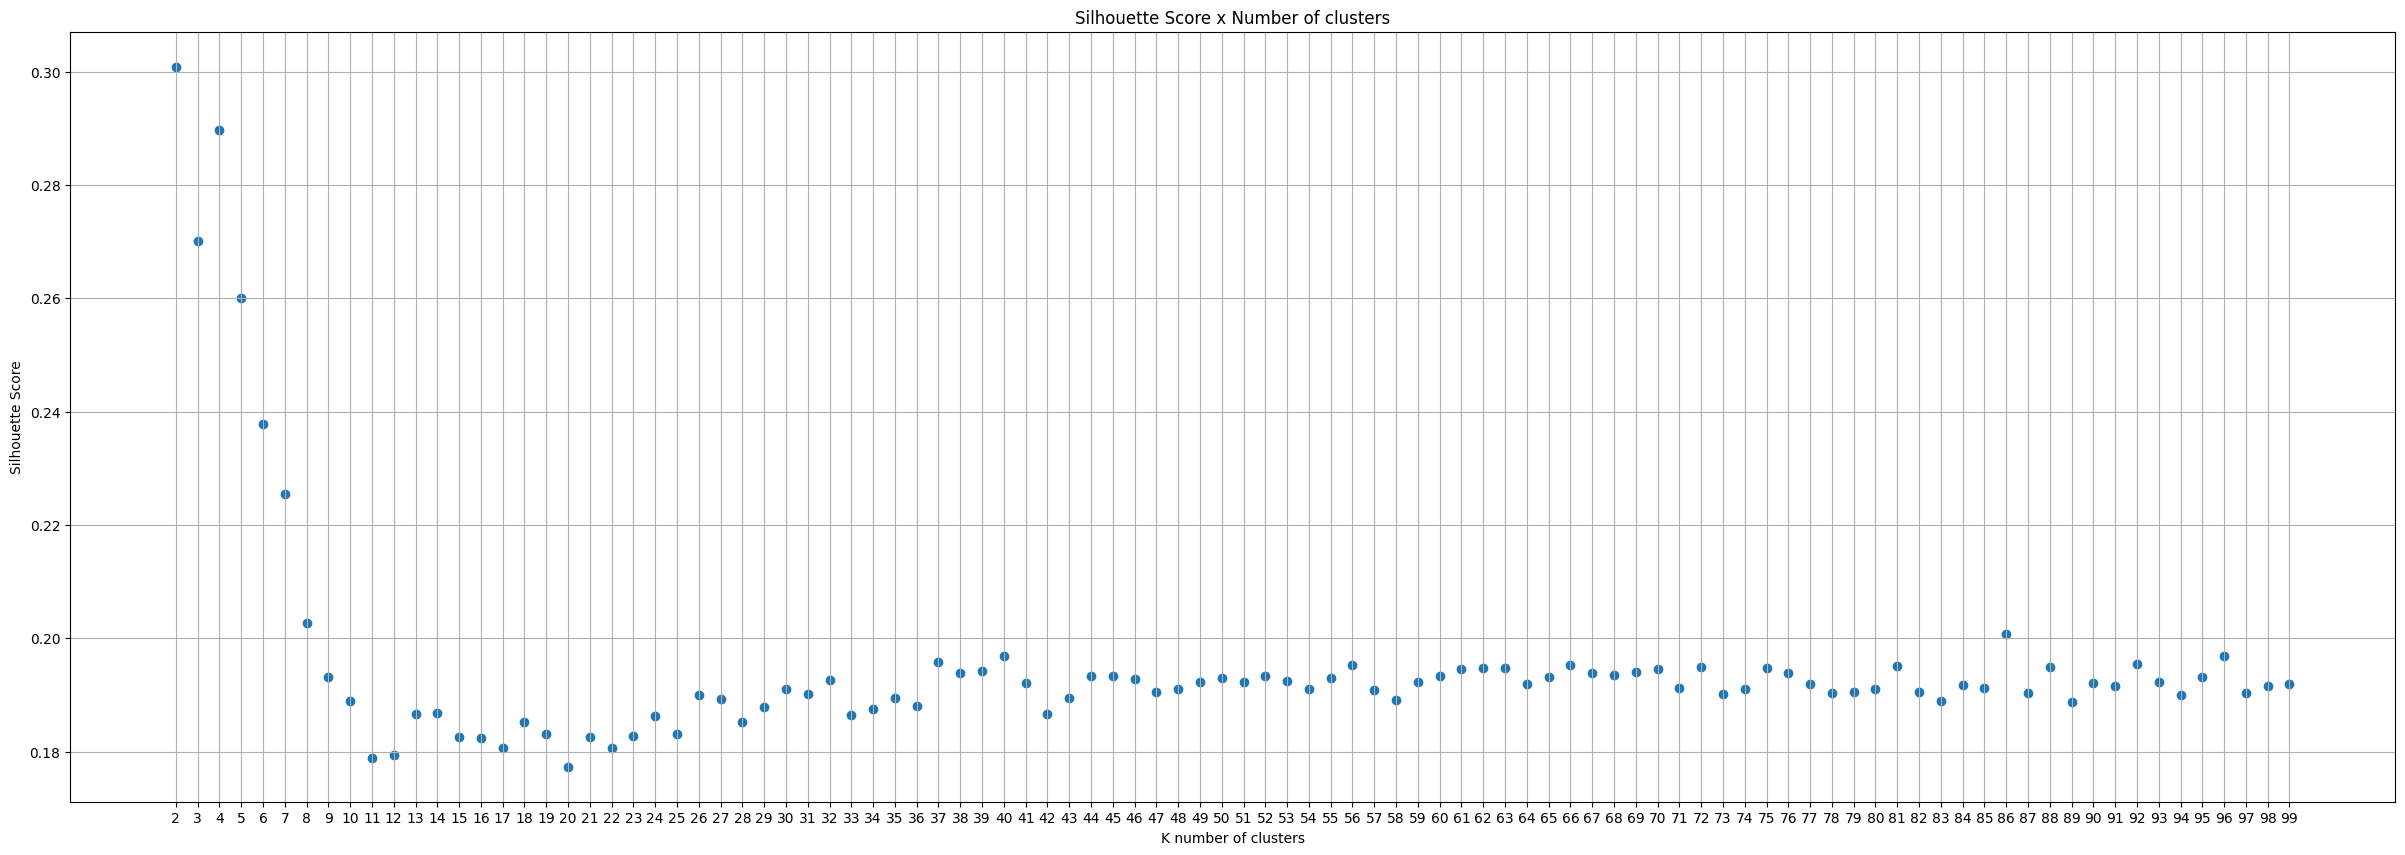

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.grid()
ax.scatter(k_list, silhouette_score_list)

**Método do cotovelo**

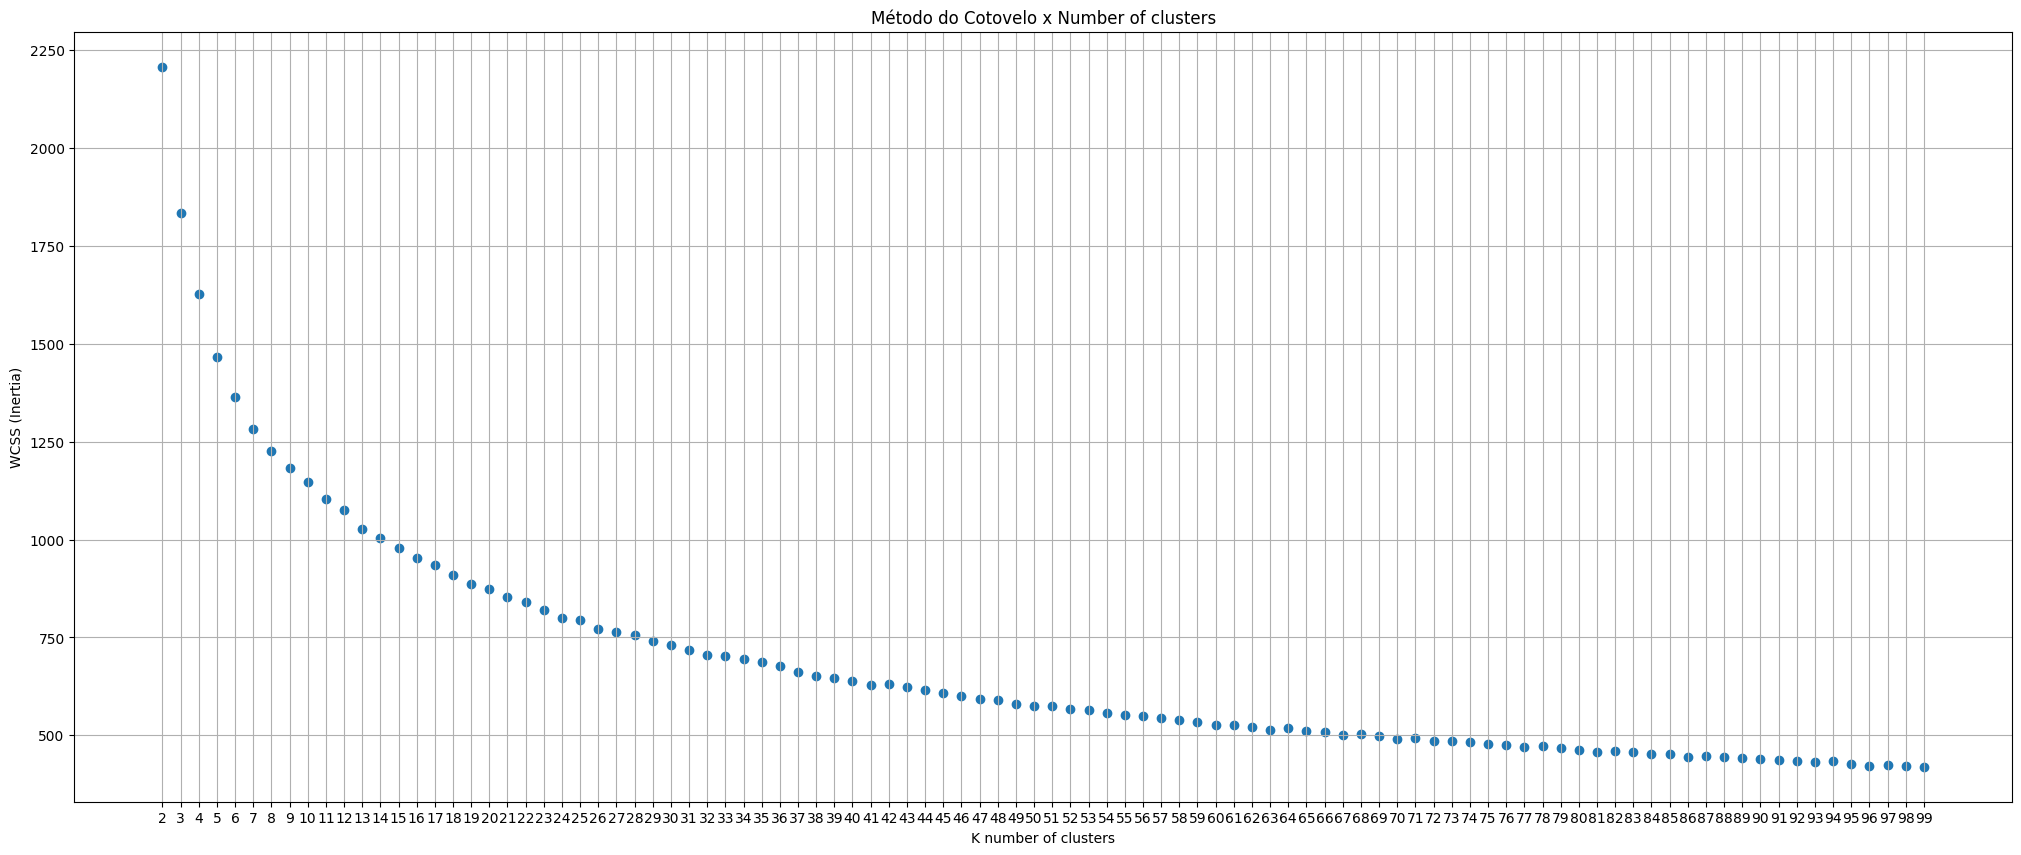

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('WCSS (Inertia)')
ax.set_xticks(k_list)
ax.set_title('Método do Cotovelo x Number of clusters')
ax.grid()
ax.scatter(k_list, wcss_list)

Baseado na avaliação da silhoute desses diferentes clusters, é possível perceber que a princípio os melhores clusters são 2 e 4. Já pelo método do cotovelo, o número de k ideal é 6 ou 7,estes são os últimos pontos antes da curva iniciar um achamento muito evidente.

In [ ]:
#Treinando um moodelo para k = 2
model_kmeans_2 = KMeans(n_clusters=2, random_state=RANDOM_SEED, n_init=50)
model_kmeans_2 = model_kmeans_2.fit(X_train)
#Treinando um modelo para k = 4
model_kmeans_4 = KMeans(n_clusters=4, random_state=RANDOM_SEED, n_init=50)
model_kmeans_4 = model_kmeans_4.fit(X_train)
#Treinando um modelo para k = 6
model_kmeans_6 = KMeans(n_clusters=6, random_state=RANDOM_SEED, n_init=50)
model_kmeans_6 = model_kmeans_6.fit(X_train)
#Treinando um modelo para k = 7
model_kmeans_7 = KMeans(n_clusters=7, random_state=RANDOM_SEED, n_init=50)
model_kmeans_7 = model_kmeans_7.fit(X_train)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/tmp/ipython-input-415288942.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/tmp/ipython-input-415288942.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have prec

(1, 1784, 2)
(1, 1604, 2)
(1, 305, 2)
(1, 1305, 2)
(1, 894, 2)
(1, 884, 2)
(1, 782, 2)
(1, 530, 2)
(1, 881, 2)
(1, 533, 2)
(1, 301, 2)
(1, 361, 2)
(1, 360, 2)
(1, 782, 2)
(1, 295, 2)
(1, 300, 2)
(1, 590, 2)
(1, 528, 2)
(1, 533, 2)


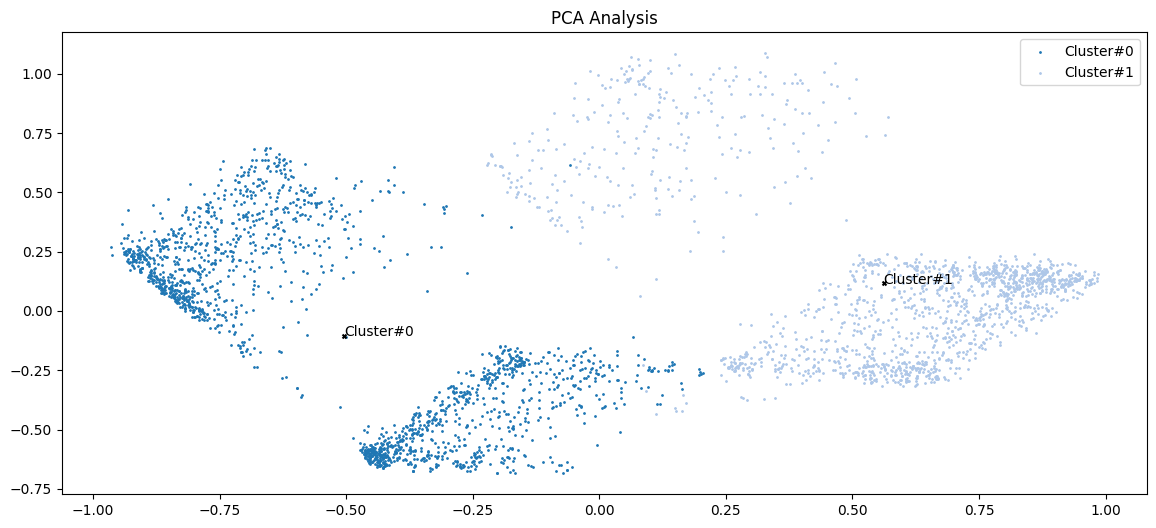

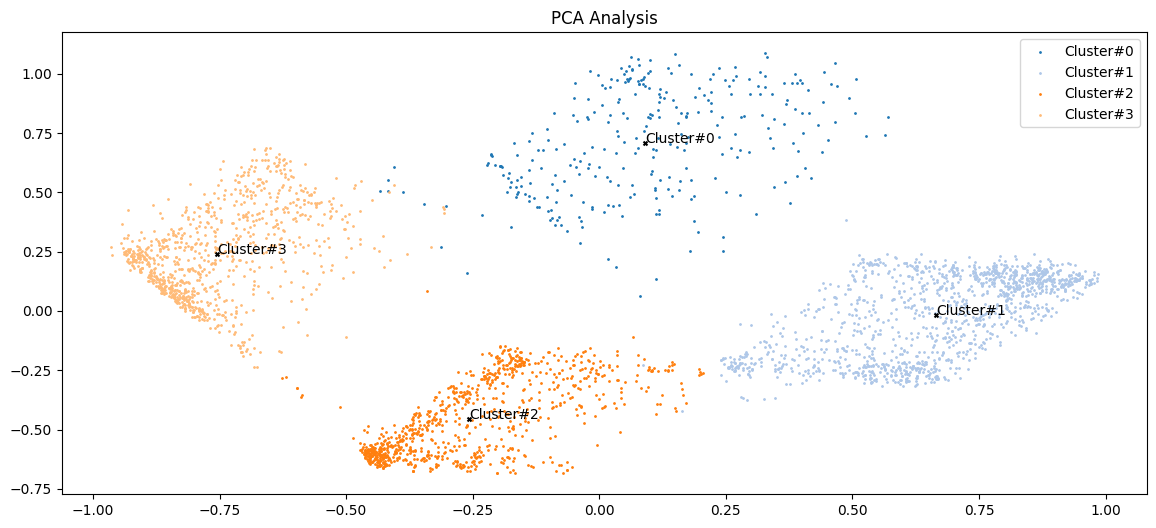

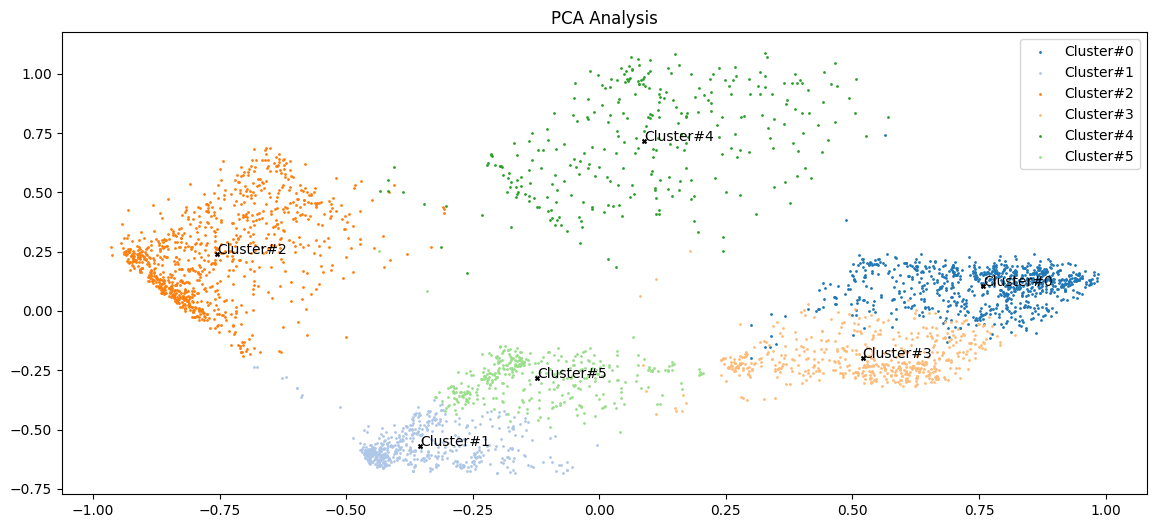

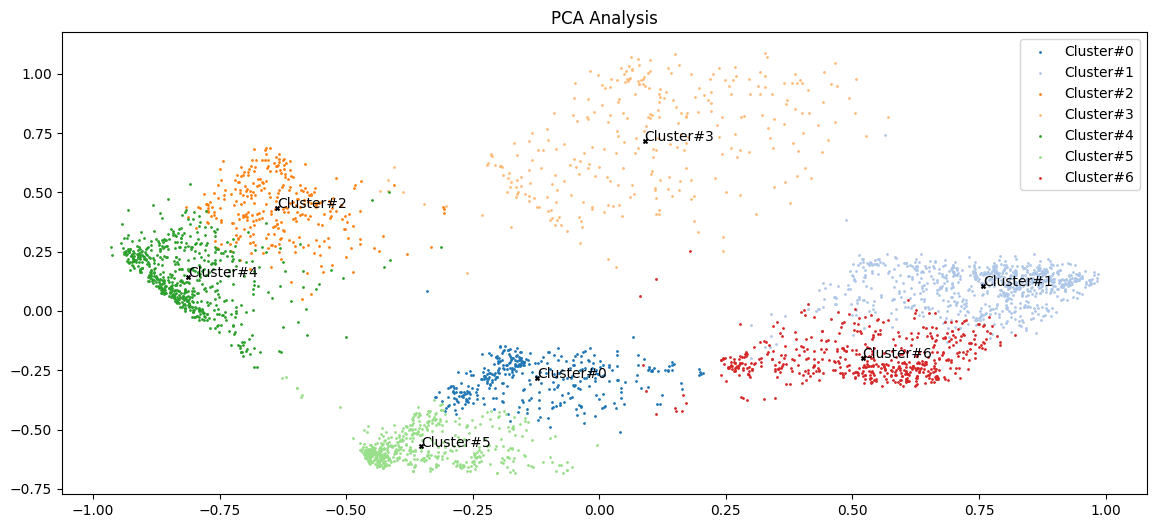

In [ ]:
plot_pca(X_train, model_kmeans_2, print_centroids=True)
plot_pca(X_train, model_kmeans_4, print_centroids=True)
plot_pca(X_train, model_kmeans_6, print_centroids=True)
plot_pca(X_train, model_kmeans_7, print_centroids=True)



**Resultados:**

Quanto mais aumentamos o numero de K clusters (o que resulta em clusters menores e mais detalhados), o K-Means subdivide o conjunto de dados.

Ao aumentar os cluster iniciais vão se dividinfo cada vez mais, o único que se manteve foi a massa superior central que no k=7 foi classificada como cluster3

##**CONJUNTO DE VALIDAÇÃO**

In [ ]:
val_centroids_distances_2 = model_kmeans_2.transform(X_val)
val_anomaly_scores_2 = np.min(val_centroids_distances_2, axis=1)##vetor com a distancia de todos os pontos de x val ao centroide mais  próximo


val_centroids_distances_4 = model_kmeans_4.transform(X_val)
val_anomaly_scores_4 = np.min(val_centroids_distances_4, axis=1) ##vetor com a distancia de todos os pontos de x val ao centroide mais  próximo


val_centroids_distances_6 = model_kmeans_6.transform(X_val)
val_anomaly_scores_6 = np.min(val_centroids_distances_6, axis=1) ##vetor com a distancia de todos os pontos de x val ao centroide mais  próximo


val_centroids_distances_7 = model_kmeans_7.transform(X_val)
val_anomaly_scores_7 = np.min(val_centroids_distances_7, axis=1) ##vetor com a distancia de todos os pontos de x val ao centroide mais  próximo




In [ ]:
print("Distância dos centróides para K = 2")
print(val_centroids_distances_2[0:1,:])
print(val_anomaly_scores_2[0:1])

print("\nDistâncias dos centróides para o K = 4")
print(val_centroids_distances_4[0:1,:])
print(val_anomaly_scores_4[0:1])

print("\nDistância dos centróides para K = 6")
print(val_centroids_distances_6[0:1,:])
print(val_anomaly_scores_6[0:1])

print("\nDistância dos centróides para K = 7")
print(val_centroids_distances_7[0:1,:])
print(val_anomaly_scores_7[0:1])



Distância dos centróides para K = 2
[[1.53546421 0.75809173]]
[0.75809173]

Distâncias dos centróides para o K = 4
[[1.28063993 0.70971282 1.42533949 1.75937151]]
[0.70971282]

Distância dos centróides para K = 6
[[0.58237069 1.58213718 1.75964239 1.0287951  1.28417542 1.28148313]]
[0.58237069]

Distância dos centróides para K = 7
[[1.28137402 0.58237069 1.65713256 1.28414193 1.8454187  1.58100855
  1.0287951 ]]
[0.58237069]


In [ ]:
y_val.value_counts()
#0 benigno
#1 malicioso

Class
0    790
1    236
Name: count, dtype: int64

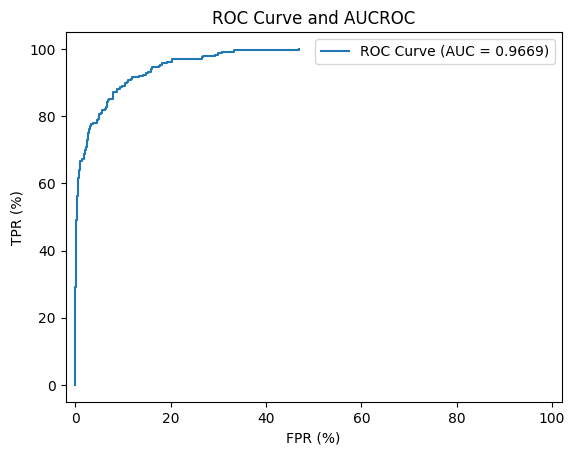

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores_2)

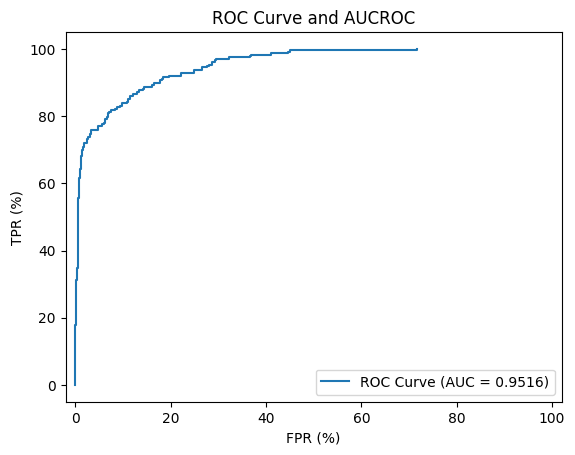

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores_4)

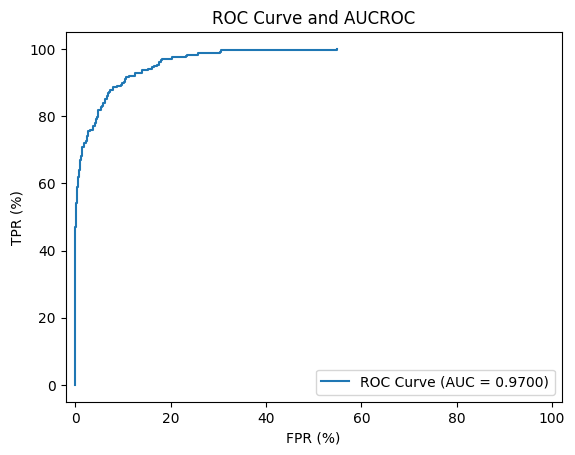

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores_6)

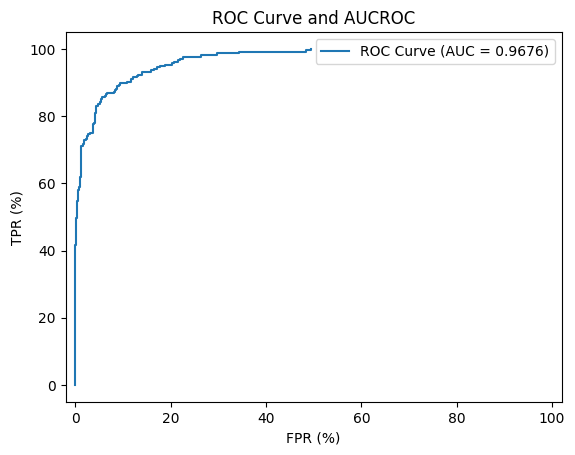

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores_7)

Os modelos tiveram desemoenho parecido mas o que se saiu melhor foi com k=6

##**ESCOLHA DO THRESHOLD**

Existem muitas formas de se escolher um threshold para a detecção de anomalias, e no geral essa escolha irá depender da tarefa a ser realizada e das caracteristicas do ambiente onde o sistema de detecção será utilizado. Aqui utilizaremos o Youden-index, ou estatística J de Youden. Essa estatistica geralmente é usada para definir o "valor ideal" de theshold pois atinge seu valor máximo com o thresold que gera a menor quantidade de falsos positivos e a maior quantidade de verdadeiros positivos. O ponto maximo do Youden-index pode ser entendido como o valor de threshold que gera o ponto da curva ROC mais distante o possível da diagonal do gráfico ou simplismente o valor da curva roc que maximiza o valor de  $tpr-fpr$.

**Avaliando para k=6**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores_6)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

fpr       tpr  thresholds  youden-index
82   0.106329  0.915254    0.807781      0.808925
70   0.078481  0.885593    0.835623      0.807112
84   0.112658  0.919492    0.799835      0.806833
80   0.105063  0.911017    0.812604      0.805954
68   0.072152  0.877119    0.844741      0.804967
86   0.125316  0.927966    0.787669      0.802650
72   0.087342  0.889831    0.829973      0.802489
66   0.070886  0.872881    0.845794      0.801995
78   0.102532  0.902542    0.816854      0.800011
76   0.098734  0.898305    0.820561      0.799571
64   0.069620  0.868644    0.846564      0.799024
74   0.096203  0.894068    0.822771      0.797865
90   0.140506  0.936441    0.778553      0.795934
62   0.067089  0.860169    0.854045      0.793081
88   0.139241  0.932203    0.778689      0.792963
92   0.151899  0.940678    0.770923      0.788779
60   0.063291  0.851695    0.858197      0.788404
104  0.182278  0.970339    0.755255      0.788061
100  0.174684  0.961864    0.759367      0.787181
102  0.179747  0.966102    0.756009      0.786355
96   0.165823  0.949153    0.764384      0.783330
94   0.162025  0.944915    0.765789      0.782890
98   0.172152  0.953390    0.761710      0.781238
58   0.062025  0.843220    0.861440      0.781195
56   0.058228  0.838983    0.868620      0.780755
54   0.056962  0.830508    0.873565      0.773546
106  0.202532  0.974576    0.743114      0.772045
52   0.054430  0.826271    0.877171      0.771841
50   0.048101  0.817797    0.899643      0.769695
48   0.046835  0.800847    0.908067      0.754012
46   0.045570  0.796610    0.916094      0.751041
110  0.234177  0.983051    0.720537      0.748874
44   0.044304  0.792373    0.927501      0.748069
108  0.232911  0.978814    0.721735      0.745902
42   0.043038  0.783898    0.938246      0.740860
40   0.041772  0.779661    0.942634      0.737889
38   0.040506  0.775424    0.948765      0.734917
36   0.037975  0.771186    0.961329      0.733212
112  0.256962  0.987288    0.710117      0.730326
34   0.030380  0.758475    0.986790      0.728095
32   0.027848  0.754237    0.992660      0.726389
30   0.026582  0.750000    1.001152      0.723418
28   0.025316  0.741525    1.027652      0.716209
26   0.024051  0.733051    1.033842      0.709000
22   0.017722  0.720339    1.059529      0.702617
24   0.022785  0.724576    1.044214      0.701791
20   0.015190  0.707627    1.069704      0.692437
116  0.306329  0.995763    0.692771      0.689434
114  0.303797  0.991525    0.693780      0.687728
18   0.013924  0.699153    1.085732      0.685228
16   0.011392  0.682203    1.105284      0.670811
14   0.010127  0.669492    1.111385      0.659365
12   0.008861  0.639831    1.124451      0.630970
10   0.005063  0.618644    1.143218      0.613581
8    0.003797  0.588983    1.159185      0.585186
6    0.002532  0.542373    1.185186      0.539841
4    0.001266  0.538136    1.188616      0.536870
2    0.000000  0.470339    1.211094      0.470339
118  0.549367  1.000000    0.590959      0.450633
119  1.000000  1.000000    0.210598      0.000000

In [ ]:
BEST_VALIDATION_THRESHOLD = 0.807781

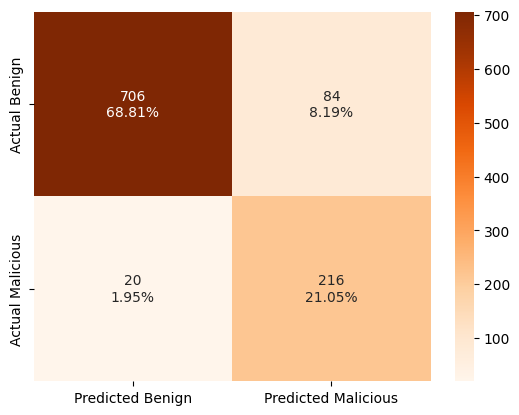

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores_6 > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores_6 > BEST_VALIDATION_THRESHOLD)

{'acc': np.float64(0.898635477582846),
 'tpr': np.float64(0.9152542372881356),
 'fpr': np.float64(0.10632911392405063),
 'precision': np.float64(0.72),
 'f1-score': np.float64(0.8059701492537312)}

**Avaliando para k=7**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores_7)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

fpr       tpr  thresholds  youden-index
72   0.094937  0.898305    0.797559      0.803368
70   0.091139  0.894068    0.802315      0.802929
60   0.067089  0.868644    0.829957      0.801555
68   0.088608  0.889831    0.806630      0.801223
54   0.055696  0.855932    0.844711      0.800236
58   0.064557  0.864407    0.830469      0.799850
56   0.062025  0.860169    0.834882      0.798144
52   0.054430  0.851695    0.853040      0.797265
66   0.084810  0.881356    0.812043      0.796546
76   0.116456  0.911017    0.776989      0.794561
78   0.121519  0.915254    0.771658      0.793735
74   0.108861  0.902542    0.786299      0.793682
64   0.083544  0.877119    0.816227      0.793574
82   0.131646  0.923729    0.763862      0.792083
62   0.081013  0.872881    0.818529      0.791869
84   0.140506  0.932203    0.760919      0.791697
50   0.051899  0.843220    0.861274      0.791322
80   0.130380  0.919492    0.765264      0.789112
48   0.046835  0.834746    0.869895      0.787910
46   0.044304  0.830508    0.873331      0.786205
86   0.158228  0.936441    0.747698      0.778213
88   0.164557  0.940678    0.743690      0.776121
44   0.043038  0.817797    0.877326      0.774759
90   0.170886  0.944915    0.737081      0.774029
92   0.177215  0.949153    0.732573      0.771937
42   0.041772  0.809322    0.884734      0.767550
94   0.188608  0.953390    0.725152      0.764782
98   0.206329  0.961864    0.715586      0.755535
96   0.202532  0.957627    0.717055      0.755095
102  0.218987  0.970339    0.710729      0.751352
100  0.216456  0.966102    0.711662      0.749646
104  0.226582  0.974576    0.706615      0.747994
40   0.039241  0.779661    0.925900      0.740421
38   0.037975  0.775424    0.937130      0.737449
36   0.036709  0.771186    0.942405      0.734478
32   0.026582  0.745763    0.986790      0.719180
106  0.264557  0.983051    0.692231      0.718494
34   0.031646  0.750000    0.977040      0.718354
30   0.025316  0.741525    0.990704      0.716209
28   0.024051  0.737288    1.001152      0.713238
24   0.017722  0.728814    1.034230      0.711092
26   0.022785  0.733051    1.001874      0.710266
22   0.016456  0.716102    1.044594      0.699646
20   0.012658  0.711864    1.054164      0.699206
108  0.297468  0.987288    0.677681      0.689820
18   0.011392  0.690678    1.082230      0.679286
110  0.343038  0.991525    0.659657      0.648487
16   0.010127  0.618644    1.123391      0.608517
14   0.008861  0.588983    1.141363      0.580122
12   0.006329  0.580508    1.144215      0.574179
10   0.005063  0.567797    1.150881      0.562733
8    0.003797  0.546610    1.159005      0.542813
112  0.484810  0.995763    0.593016      0.510953
114  0.494937  1.000000    0.590661      0.505063
6    0.002532  0.495763    1.182957      0.493231
4    0.001266  0.474576    1.188914      0.473310
2    0.000000  0.415254    1.211678      0.415254
115  1.000000  1.000000    0.210357      0.000000

In [ ]:
BEST_VALIDATION_THRESHOLD = 	0.797559

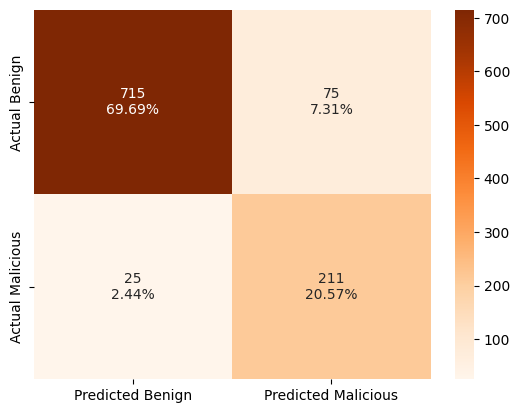

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores_7 > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores_7 > BEST_VALIDATION_THRESHOLD)

{'acc': np.float64(0.9025341130604289),
 'tpr': np.float64(0.8940677966101694),
 'fpr': np.float64(0.0949367088607595),
 'precision': np.float64(0.7377622377622378),
 'f1-score': np.float64(0.8084291187739463)}

Ao definir um threshold, percebe-se que o melhor cluster se confirma sendo com K = 6 visto que foi o que teva a taxa de falsos positivos menor, uma vez que essa é uma das taxas mais importantes no nosso contexto, e é o que vai ser utilizado para teste.

##**TUNGEM DOS HIPERPARÂMETROS**


*   **n_iter**: quantidade de vezes que o k_means será executado com diferentes sementes de centróides
*   **Max_iter**: que corresponde ao máximo de iterações que o k_means irá fazer para encontrar a convergência da centróide
*   **algorithm**: Tipo de algoritmo utilizado para realizar a categorização



Parâmetros do modelo antes da tunagem

In [ ]:
model_kmeans_6.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 6,
 'n_init': 50,
 'random_state': 99,
 'tol': 0.0001,
 'verbose': 0}

**Cria uma lista com os modelos**

In [ ]:
import itertools
n_iter = [10, 25, 50, 75, 90, 100]
max_iter = [250, 500, 750, 1000, 1250, 1500]
algorithm = ["lloyd", 'elkan']

param_grid = list(itertools.product(n_iter, max_iter, algorithm))

results = {}
for params in param_grid:
    # Inicializar e treinar o modelo KMeans
    new_model_kmeans = KMeans(n_clusters=6, random_state=RANDOM_SEED, n_init=params[0], max_iter=params[1], algorithm=params[2])
    new_model_kmeans.fit(X_train)

    # Calcular scores de anomalia em X_val
    new_val_centroids_distances = new_model_kmeans.transform(X_val)
    new_val_anomaly_scores = np.min(new_val_centroids_distances, axis=1)

    # Calcular ROC e Youden-index para encontrar o melhor threshold
    fpr, tpr, thresholds = roc_curve(y_val, new_val_anomaly_scores)
    df_val_roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']

    # Encontrar o threshold que maximiza o Youden-index
    if df_val_roc['youden-index'].max() <= 0:
        # If no positive Youden-index, typically means no good separation. Use a default or the first threshold.
        BEST_VALIDATION_THRESHOLD = thresholds[0] # Could also be np.min(val_anomaly_scores) or similar
    else:
        best_threshold_row = df_val_roc.loc[df_val_roc['youden-index'].idxmax()]
        BEST_VALIDATION_THRESHOLD = best_threshold_row['thresholds']
    # Exibir métricas gerais
    metrics = get_overall_metrics(y_val, new_val_anomaly_scores > BEST_VALIDATION_THRESHOLD)
    results[params] = {
        'metrics': metrics,
        'y_score_val': new_val_anomaly_scores,
        'best_threshold': BEST_VALIDATION_THRESHOLD
        }



**Escolhe o melhor baseado na f1**

In [ ]:
F1_METRIC_KEY = 'f1-score'
best_f1 = -1.0
best_params = None

for params, data in results.items():
    # Acessa o dicionário de métricas aninhado
    current_metrics = data['metrics']

    current_f1 = current_metrics.get(F1_METRIC_KEY, -1.0)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_params = params


# Exibir os resultados do modelo vencedor
if best_params is not None:
    print(f"\nModelo Vencedor (Otimizado por F1-Score: {best_f1:.4f})")
    best_n_init, best_max_iter, best_algorithm = best_params[0], best_params[1], best_params[2]

    print(f"n_init | {best_n_init} ")
    print(f"max_iter | {best_max_iter} ")
    print(f"algorithm | {best_algorithm} ")

    print("\nMétricas de Validação do Vencedor:")
    winner_metrics = results[best_params]['metrics']
    for key, value in winner_metrics.items():
        if isinstance(value, (int, float)):
            print(f"{key.replace('_', ' ').title()} | {value:.4f} ")
        else:
            print(f"{key.replace('_', ' ').title()} | {value} ")



Modelo Vencedor (Otimizado por F1-Score: 0.8037)
n_init | 10 
max_iter | 250 
algorithm | lloyd 

Métricas de Validação do Vencedor:
Acc | 0.8977 
Tpr | 0.9110 
Fpr | 0.1063 
Precision | 0.7191 
F1-Score | 0.8037 


**Avaliando métricas pós tunagem**

In [ ]:
# Acesse os dados do modelo vencedor
winner_data = results[best_params]
winner_y_score = winner_data['y_score_val']
best_threshold = winner_data['best_threshold']

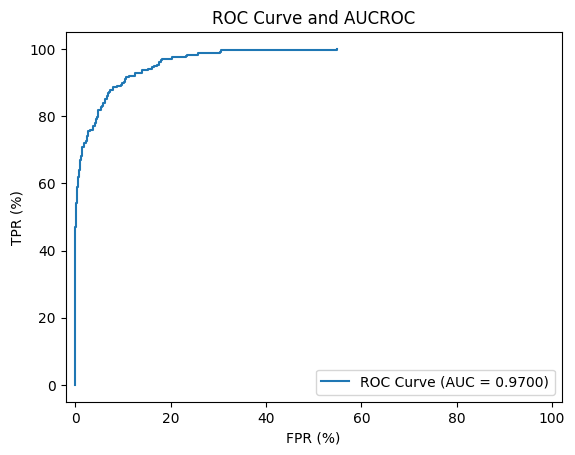

In [ ]:
plot_roc_curve(y_val, winner_y_score)


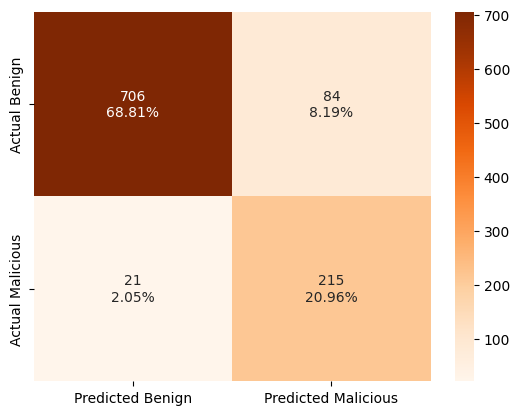

In [ ]:
plot_confusion_matrix(y_val, winner_y_score > best_threshold)

##**CONJUNTO DE TESTE**

**Treinando o algoritmo que se saiu melhor para aplicar no de treste visto que o meu mé todo não salva o objeto**

In [ ]:
best_n_init, best_max_iter, best_algorithm = best_params[0], best_params[1], best_params[2]

# É necessário re-treinar pois o objeto treinado não foi salvo.
final_test_model = KMeans(
  n_clusters=6,
  random_state=RANDOM_SEED,
  n_init=best_n_init,
  max_iter=best_max_iter,
  algorithm=best_algorithm
)

final_test_model.fit(X_train)


KMeans(max_iter=250, n_clusters=6, n_init=10, random_state=99)

In [ ]:
test_centroids_distances = final_test_model.transform(X_test)
test_anomaly_scores = np.min(test_centroids_distances, axis=1)

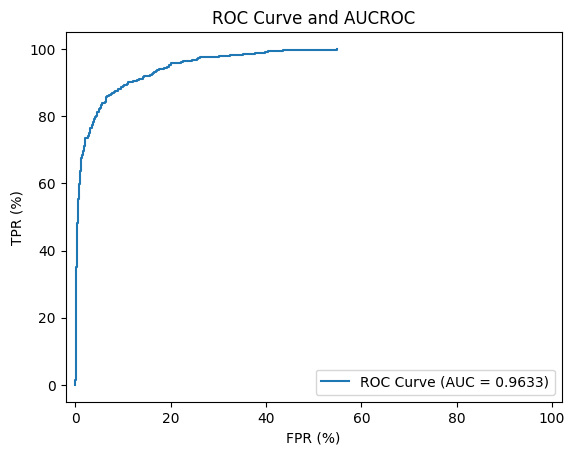

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores)


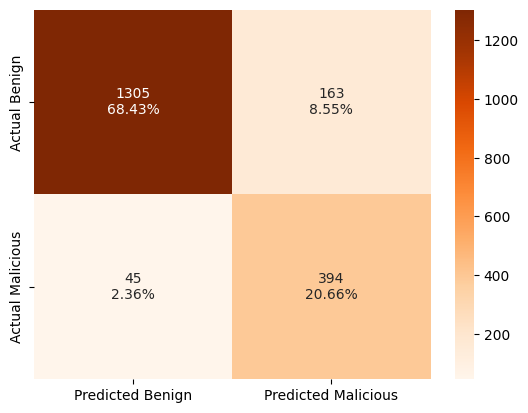

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores > best_threshold)

In [ ]:
get_overall_metrics(y_test,  test_anomaly_scores > best_threshold)


{'acc': np.float64(0.8909281594126901),
 'tpr': np.float64(0.89749430523918),
 'fpr': np.float64(0.11103542234332425),
 'precision': np.float64(0.7073608617594255),
 'f1-score': np.float64(0.7911646586345381)}

# **AUTOENCODER**

In [ ]:
X_train_np = X_train.to_numpy()
X_val_np  = X_val.to_numpy()
X_test_np  = X_test.to_numpy()

y_val_np  = y_val.to_numpy().ravel()
y_test_np = y_test.to_numpy().ravel()

#### **FUNÇÃO EARLY STOPPING**

In [ ]:
# Implementação do Early Stopping
class EarlyStopping:
  def __init__(self, patience=7, delta=0, verbose=True, path='checkpoint.pt'):
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.early_stop = False
      self.val_min_loss = np.inf # Changed from np.Inf to np.inf
      self.path = path

  def __call__(self, val_loss, model):
    if val_loss < self.val_min_loss - self.delta:   # Caso a loss da validação reduza, vamos salvar o modelo e nova loss mínima
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    else:                                           # Caso a loss da validação NÃO reduza, vamos incrementar o contador da paciencia
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}. Current validation loss: {val_loss:.5f}')
      if self.counter >= self.patience:
          self.early_stop = True

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
        print(f'Validation loss decreased ({self.val_min_loss:.5f} --> {val_loss:.5f}).  Saving model ...')
    torch.save(model, self.path)
    self.val_min_loss = val_loss

#### **ARQUITETURA 1 -> FUNÇÃO AUTOENCODER**

A estrutura do autoencoder que vamos montar é:

*features de entrada (10) → 6 → 3 → 6 → features de entrada (10)*

In [ ]:
# Implementação do Autoencoder
class Autoencoder(nn.Module):
  def __init__(self, in_features, latent_dim, dropout_rate):
      super().__init__()

      self.in_features = in_features
      self.dropout_rate = dropout_rate
      self.early_stopping = None

      # Encoder
      self.encoder = nn.Sequential(
          nn.Linear(in_features, 6),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(6, latent_dim),
          nn.ReLU()
      )

      # Decoder ajustado para latent_dim variável
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, 6),
          nn.ReLU(),
          nn.Linear(6, in_features)
      )
  def forward(self, X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded

  def compile(self, learning_rate):
    self.criterion = nn.MSELoss()
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

  def fit(self, X_train, num_epochs, batch_size, X_val = None, patience = None, delta = None):
    if X_val is not None and patience is not None and delta is not None:
      print(f'Using early stopping with patience={patience} and delta={delta}')
      self.early_stopping = EarlyStopping(patience, delta)

    val_avg_losses = []
    train_avg_losses = []

    for epoch in range(num_epochs):
      # Calibrando os pesos do modelo
      train_losses = []
      self.train()
      for batch in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[batch:(batch+batch_size)]
        batch_reconstruction = self.forward(batch_X)

        train_loss = self.criterion(batch_reconstruction, batch_X)
        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()
        train_losses.append(train_loss.item())
      train_avg_loss = np.mean(train_losses)
      train_avg_losses.append(train_avg_loss)
      print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

      # Mecanismo de early stopping
      if self.early_stopping is not None:
        val_losses = []
        self.eval()
        with torch.no_grad():
          for batch in range(0, len(X_val), batch_size):
            batch_X = X_val[batch:(batch+batch_size)]
            batch_reconstruction = self.forward(batch_X)
            val_loss = self.criterion(batch_reconstruction, batch_X)
            val_losses.append(val_loss.item())
        val_avg_loss = np.mean(val_losses)
        val_avg_losses.append(val_avg_loss)
        self.early_stopping(val_avg_loss, self)
        if self.early_stopping.early_stop:
          print(f'Stopped by early stopping at epoch {epoch+1}')
          break

    if self.early_stopping is not None:
      self = torch.load('checkpoint.pt', weights_only=False)
    self.eval()
    return train_avg_losses, val_avg_losses

#### **ARQUITETURA 2 -> FUNÇÃO DE AUTOENCODER**

In [ ]:
# Implementação do Autoencoder com arquitetura maior
class Autoencoder2(nn.Module):
    def __init__(self, in_features, dropout_rate, latent_dim):
        super().__init__()

        self.in_features = in_features
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.early_stopping = None

        # Encoder: 10 -> 7 -> 4 -> 2
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(10, 7),
            nn.BatchNorm1d(7),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(7, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(4, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )

        # Decoder: 2 -> 4 -> 7 -> 10 -> in_features
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(4, 7),
            nn.BatchNorm1d(7),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(7, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(10, in_features),
            nn.Sigmoid()  # saída entre 0 e 1
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def compile(self, learning_rate):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def fit(self, X_train, num_epochs, batch_size, X_val=None, patience=None, delta=None):
        if X_val is not None and patience is not None and delta is not None:
            print(f'Using early stopping with patience={patience} and delta={delta}')
            self.early_stopping = EarlyStopping(patience, delta)

        val_avg_losses = []
        train_avg_losses = []

        for epoch in range(num_epochs):
            train_losses = []
            self.train()
            for batch in tqdm(range(0, len(X_train), batch_size)):
                batch_X = X_train[batch:(batch + batch_size)]
                batch_reconstruction = self.forward(batch_X)

                train_loss = self.criterion(batch_reconstruction, batch_X)
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()
                train_losses.append(train_loss.item())

            train_avg_loss = np.mean(train_losses)
            train_avg_losses.append(train_avg_loss)
            print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

            # Early stopping
            if self.early_stopping is not None:
                val_losses = []
                self.eval()
                with torch.no_grad():
                    for batch in range(0, len(X_val), batch_size):
                        batch_X = X_val[batch:(batch + batch_size)]
                        batch_reconstruction = self.forward(batch_X)
                        val_loss = self.criterion(batch_reconstruction, batch_X)
                        val_losses.append(val_loss.item())
                val_avg_loss = np.mean(val_losses)
                val_avg_losses.append(val_avg_loss)
                self.early_stopping(val_avg_loss, self)
                if self.early_stopping.early_stop:
                    print(f'Stopped by early stopping at epoch {epoch+1}')
                    break

        if self.early_stopping is not None:
            self = torch.load('checkpoint.pt', weights_only=False)
        self.eval()
        return train_avg_losses, val_avg_losses

#### **COMPARAÇÃO DAS ARQUITETURAS**

In [ ]:
# Parâmetros padrão para o teste
LR_PADRAO = 1e-3
LATENT_PADRAO = 3
DROPOUT_PADRAO = 0.02
NUM_EPOCAS_RAPIDO = 20
IN_FEATURES = X_train_np.shape[1]

# Novos Parâmetros Padrão para Early Stopping (ativar coleta da loss)
PATIENCE_RAPIDO = 5  # Valor necessário para coletar a loss, embora não pare o treino em 20 épocas
DELTA_PADRAO = 0.001

# Treino (já contém apenas amostras benignas)
X_train_tensor = torch.FloatTensor(X_train_np)

# Validação SOMENTE com amostras benignas (label = 0)
benign_X_val_np = X_val_np[y_val_np == 0]
X_val_tensor = torch.FloatTensor(benign_X_val_np)

# 1. Arquitetura 1 (Simples)
model_A1 = Autoencoder(IN_FEATURES, LATENT_PADRAO, DROPOUT_PADRAO)
model_A1.compile(learning_rate=LR_PADRAO)
# Roda o fit e pega a loss final de validação - AGORA COM patience e delta
_, val_losses_A1 = model_A1.fit(
    X_train_tensor,
    NUM_EPOCAS_RAPIDO,
    128,
    X_val=X_val_tensor,
    patience=PATIENCE_RAPIDO,
    delta=DELTA_PADRAO
)
mse_final_A1 = val_losses_A1[-1]

# 2. Arquitetura 2 (Complexa)
model_A2 = Autoencoder2(IN_FEATURES, DROPOUT_PADRAO, LATENT_PADRAO)
model_A2.compile(learning_rate=LR_PADRAO)
# Roda o fit e pega a loss final de validação - AGORA COM patience e delta
_, val_losses_A2 = model_A2.fit(
    X_train_tensor,
    NUM_EPOCAS_RAPIDO,
    128,
    X_val=X_val_tensor,
    patience=PATIENCE_RAPIDO,
    delta=DELTA_PADRAO
)
mse_final_A2 = val_losses_A2[-1]

# 3. Decisão
if mse_final_A2 < mse_final_A1:
    print(f"A2 é o vencedor inicial: {mse_final_A2:.6f} vs A1: {mse_final_A1:.6f}")
    ARQUITETURA_VENCEDORA = 'A2'
else:
    print(f"A1 é o vencedor inicial: {mse_final_A1:.6f} vs A2: {mse_final_A2:.6f}")
    ARQUITETURA_VENCEDORA = 'A1'

Using early stopping with patience=5 and delta=0.001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.25393
Validation loss decreased (inf --> 0.23435).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.22306
Validation loss decreased (0.23435 --> 0.20775).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.19917
Validation loss decreased (0.20775 --> 0.18611).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.17822
Validation loss decreased (0.18611 --> 0.16519).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.15347
Validation loss decreased (0.16519 --> 0.13441).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12016
Validation loss decreased (0.13441 --> 0.10409).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09645
Validation loss decreased (0.10409 --> 0.08979).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08809
Validation loss decreased (0.08979 --> 0.08554).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08476
Validation loss decreased (0.08554 --> 0.08246).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.08150
Validation loss decreased (0.08246 --> 0.07871).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07722
Validation loss decreased (0.07871 --> 0.07381).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07206
Validation loss decreased (0.07381 --> 0.06835).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06669
Validation loss decreased (0.06835 --> 0.06316).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06243
Validation loss decreased (0.06316 --> 0.05916).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05893
Validation loss decreased (0.05916 --> 0.05623).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05662
Validation loss decreased (0.05623 --> 0.05405).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05456
Validation loss decreased (0.05405 --> 0.05234).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05307
Validation loss decreased (0.05234 --> 0.05096).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05195
Validation loss decreased (0.05096 --> 0.04981).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05077
Validation loss decreased (0.04981 --> 0.04873).  Saving model ...
Using early stopping with patience=5 and delta=0.001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16440
Validation loss decreased (inf --> 0.15815).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15093
Validation loss decreased (0.15815 --> 0.14435).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13851
Validation loss decreased (0.14435 --> 0.13115).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12649
Validation loss decreased (0.13115 --> 0.11881).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11366
Validation loss decreased (0.11881 --> 0.10462).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10057
Validation loss decreased (0.10462 --> 0.09224).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08927
Validation loss decreased (0.09224 --> 0.08102).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07996
Validation loss decreased (0.08102 --> 0.07298).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07256
Validation loss decreased (0.07298 --> 0.06663).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06703
Validation loss decreased (0.06663 --> 0.06239).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06281
Validation loss decreased (0.06239 --> 0.05858).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05977
Validation loss decreased (0.05858 --> 0.05568).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05736
Validation loss decreased (0.05568 --> 0.05284).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05565
Validation loss decreased (0.05284 --> 0.05056).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05354
Validation loss decreased (0.05056 --> 0.04924).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05223
Validation loss decreased (0.04924 --> 0.04774).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05067
Validation loss decreased (0.04774 --> 0.04654).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05024
Validation loss decreased (0.04654 --> 0.04536).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04943
EarlyStopping counter: 1 out of 5. Current validation loss: 0.04459


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04849
Validation loss decreased (0.04536 --> 0.04421).  Saving model ...
A2 é o vencedor inicial: 0.044208 vs A1: 0.048727


##**ARQUITETURA 2**

In [ ]:
X_train_np = X_train.to_numpy()
X_val_np  = X_val.to_numpy()
X_test_np  = X_test.to_numpy()

y_val_np  = y_val.to_numpy().ravel()
y_test_np = y_test.to_numpy().ravel()

#### FUNÇÃO EARLY STOPPING

In [ ]:
# Implementação do Early Stopping
class EarlyStopping:
  def __init__(self, patience=7, delta=0, verbose=True, path='checkpoint.pt'):
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.early_stop = False
      self.val_min_loss = np.inf # Changed from np.Inf to np.inf
      self.path = path

  def __call__(self, val_loss, model):
    if val_loss < self.val_min_loss - self.delta:   # Caso a loss da validação reduza, vamos salvar o modelo e nova loss mínima
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    else:                                           # Caso a loss da validação NÃO reduza, vamos incrementar o contador da paciencia
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}. Current validation loss: {val_loss:.5f}')
      if self.counter >= self.patience:
          self.early_stop = True

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
        print(f'Validation loss decreased ({self.val_min_loss:.5f} --> {val_loss:.5f}).  Saving model ...')
    torch.save(model, self.path)
    self.val_min_loss = val_loss

#### FUNÇÃO DE AUTOENCODER 2

In [ ]:
# Implementação do Autoencoder com arquitetura maior
class Autoencoder2(nn.Module):
    def __init__(self, in_features, dropout_rate, latent_dim):
        super().__init__()

        self.in_features = in_features
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.early_stopping = None

        # Encoder: 10 -> 7 -> 4 -> 2
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(10, 7),
            nn.BatchNorm1d(7),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(7, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(4, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )

        # Decoder: 2 -> 4 -> 7 -> 10 -> in_features
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(4, 7),
            nn.BatchNorm1d(7),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(7, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(10, in_features),
            nn.Sigmoid()  # saída entre 0 e 1
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def compile(self, learning_rate):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def fit(self, X_train, num_epochs, batch_size, X_val=None, patience=None, delta=None):
        if X_val is not None and patience is not None and delta is not None:
            print(f'Using early stopping with patience={patience} and delta={delta}')
            self.early_stopping = EarlyStopping(patience, delta)

        val_avg_losses = []
        train_avg_losses = []

        for epoch in range(num_epochs):
            train_losses = []
            self.train()
            for batch in tqdm(range(0, len(X_train), batch_size)):
                batch_X = X_train[batch:(batch + batch_size)]
                batch_reconstruction = self.forward(batch_X)

                train_loss = self.criterion(batch_reconstruction, batch_X)
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()
                train_losses.append(train_loss.item())

            train_avg_loss = np.mean(train_losses)
            train_avg_losses.append(train_avg_loss)
            print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

            # Early stopping
            if self.early_stopping is not None:
                val_losses = []
                self.eval()
                with torch.no_grad():
                    for batch in range(0, len(X_val), batch_size):
                        batch_X = X_val[batch:(batch + batch_size)]
                        batch_reconstruction = self.forward(batch_X)
                        val_loss = self.criterion(batch_reconstruction, batch_X)
                        val_losses.append(val_loss.item())
                val_avg_loss = np.mean(val_losses)
                val_avg_losses.append(val_avg_loss)
                self.early_stopping(val_avg_loss, self)
                if self.early_stopping.early_stop:
                    print(f'Stopped by early stopping at epoch {epoch+1}')
                    break

        if self.early_stopping is not None:
            self = torch.load('checkpoint.pt', weights_only=False)
        self.eval()
        return train_avg_losses, val_avg_losses

#### TUNAGEM DOS HIPERPARÂMETROS

In [ ]:
IN_FEATURES = 10
NUM_EPOCHS = 50
PATIENCE = 10
DELTA = 0.0001

In [ ]:
param_grid = {
    'latent_dim': [2, 3, 4],
    'dropout_rate': [0.0, 0.02, 0.05],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [64, 128, 256]
}

In [ ]:
results = []

# Treino (já contém apenas amostras benignas)
X_train_tensor = torch.FloatTensor(X_train_np) # Changed from X_train_augmented to X_train_np

# Validação SOMENTE com amostras benignas (label = 0)
benign_X_val_np = X_val_np[y_val_np == 0]
X_val_tensor = torch.FloatTensor(benign_X_val_np)

for latent_dim in param_grid['latent_dim']:
    for dropout in param_grid['dropout_rate']:
        for lr in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:

                print(f"Testando: latent={latent_dim}, dropout={dropout}, lr={lr}, batch_size={batch_size}")

                # Inicializar e compilar model
                model = Autoencoder2(
                    in_features=IN_FEATURES,
                    latent_dim=latent_dim,
                    dropout_rate=dropout
                )
                model.compile(learning_rate=lr)

                # Treinar com early stopping
                train_avg_losses, val_avg_losses = model.fit(
                    X_train_tensor,
                    num_epochs=NUM_EPOCHS,
                    batch_size=batch_size,
                    X_val=X_val_tensor,
                    patience=PATIENCE,
                    delta=DELTA
                )

                # Avaliação final em dados benignos (MSE médio)
                model.eval()
                with torch.no_grad():
                    recon = model(X_val_tensor)
                    val_mse = torch.mean((X_val_tensor - recon) ** 2).item()

                # Salvar resultados
                results.append({
                    'latent_dim': latent_dim,
                    'dropout_rate': dropout,
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'val_mse': val_mse
                })

# Transformar em DataFrame para análise
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_mse')
print("Melhor configuração:")
print(results_df.head(1))

Testando: latent=2, dropout=0.0, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14852
Validation loss decreased (inf --> 0.13588).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12388
Validation loss decreased (0.13588 --> 0.11145).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.10341
Validation loss decreased (0.11145 --> 0.09473).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.08734
Validation loss decreased (0.09473 --> 0.08048).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.07466
Validation loss decreased (0.08048 --> 0.06957).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.06548
Validation loss decreased (0.06957 --> 0.06264).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.06047
Validation loss decreased (0.06264 --> 0.05881).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.05741
Validation loss decreased (0.05881 --> 0.05627).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.05547
Validation loss decreased (0.05627 --> 0.05434).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.05371
Validation loss decreased (0.05434 --> 0.05288).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.05237
Validation loss decreased (0.05288 --> 0.05154).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05112
Validation loss decreased (0.05154 --> 0.05045).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.04995
Validation loss decreased (0.05045 --> 0.04959).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.04902
Validation loss decreased (0.04959 --> 0.04870).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.04810
Validation loss decreased (0.04870 --> 0.04774).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.04735
Validation loss decreased (0.04774 --> 0.04688).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.04648
Validation loss decreased (0.04688 --> 0.04607).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04567
Validation loss decreased (0.04607 --> 0.04523).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04475
Validation loss decreased (0.04523 --> 0.04450).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04378
Validation loss decreased (0.04450 --> 0.04383).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04290
Validation loss decreased (0.04383 --> 0.04302).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04208
Validation loss decreased (0.04302 --> 0.04217).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04138
Validation loss decreased (0.04217 --> 0.04164).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04084
Validation loss decreased (0.04164 --> 0.04100).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04026
Validation loss decreased (0.04100 --> 0.04059).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.03988
Validation loss decreased (0.04059 --> 0.04024).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.03944
Validation loss decreased (0.04024 --> 0.03983).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.03918
Validation loss decreased (0.03983 --> 0.03962).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.03893
Validation loss decreased (0.03962 --> 0.03936).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.03886
Validation loss decreased (0.03936 --> 0.03921).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.03866
Validation loss decreased (0.03921 --> 0.03905).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.03839
Validation loss decreased (0.03905 --> 0.03894).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03838
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03889


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03834
Validation loss decreased (0.03894 --> 0.03877).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03814
Validation loss decreased (0.03877 --> 0.03855).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03806
Validation loss decreased (0.03855 --> 0.03841).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03789
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03851


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03768
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03845


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03751
Validation loss decreased (0.03841 --> 0.03810).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03772
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03802


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03745
Validation loss decreased (0.03810 --> 0.03730).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03701
Validation loss decreased (0.03730 --> 0.03711).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03681
Validation loss decreased (0.03711 --> 0.03697).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03683
Validation loss decreased (0.03697 --> 0.03684).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03665
Validation loss decreased (0.03684 --> 0.03673).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03655
Validation loss decreased (0.03673 --> 0.03660).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03642
Validation loss decreased (0.03660 --> 0.03641).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03633
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03646


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03622
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03722


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03610
Validation loss decreased (0.03641 --> 0.03624).  Saving model ...
Testando: latent=2, dropout=0.0, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14393
Validation loss decreased (inf --> 0.14520).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12832
Validation loss decreased (0.14520 --> 0.12440).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11611
Validation loss decreased (0.12440 --> 0.10941).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10564
Validation loss decreased (0.10941 --> 0.10010).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09629
Validation loss decreased (0.10010 --> 0.09225).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.08829
Validation loss decreased (0.09225 --> 0.08468).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08134
Validation loss decreased (0.08468 --> 0.07859).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07540
Validation loss decreased (0.07859 --> 0.07318).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07057
Validation loss decreased (0.07318 --> 0.06846).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06656
Validation loss decreased (0.06846 --> 0.06455).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06316
Validation loss decreased (0.06455 --> 0.06175).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06016
Validation loss decreased (0.06175 --> 0.05906).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05772
Validation loss decreased (0.05906 --> 0.05719).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05575
Validation loss decreased (0.05719 --> 0.05546).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05433
Validation loss decreased (0.05546 --> 0.05225).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05280
Validation loss decreased (0.05225 --> 0.05128).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05152
Validation loss decreased (0.05128 --> 0.05058).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05093
Validation loss decreased (0.05058 --> 0.04923).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04992
Validation loss decreased (0.04923 --> 0.04843).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04938
Validation loss decreased (0.04843 --> 0.04791).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04862
Validation loss decreased (0.04791 --> 0.04739).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04815
Validation loss decreased (0.04739 --> 0.04696).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04769
Validation loss decreased (0.04696 --> 0.04669).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04740
Validation loss decreased (0.04669 --> 0.04657).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04685
Validation loss decreased (0.04657 --> 0.04606).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04647
Validation loss decreased (0.04606 --> 0.04567).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04652
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04633


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04628
Validation loss decreased (0.04567 --> 0.04532).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04634
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04542


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04591
Validation loss decreased (0.04532 --> 0.04504).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04552
Validation loss decreased (0.04504 --> 0.04445).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04508
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04507


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04482
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04499


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04471
EarlyStopping counter: 3 out of 10. Current validation loss: 0.04522


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04479
Validation loss decreased (0.04445 --> 0.04433).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04440
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04487


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04415
Validation loss decreased (0.04433 --> 0.04384).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04428
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04407


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04397
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04376


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04396
EarlyStopping counter: 3 out of 10. Current validation loss: 0.04409


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04374
Validation loss decreased (0.04384 --> 0.04347).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04343
Validation loss decreased (0.04347 --> 0.04329).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04334
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04337


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04328
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04409


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04305
EarlyStopping counter: 3 out of 10. Current validation loss: 0.04396


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04296
EarlyStopping counter: 4 out of 10. Current validation loss: 0.04357


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04315
Validation loss decreased (0.04329 --> 0.04245).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04328
Validation loss decreased (0.04245 --> 0.04223).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04311
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04226


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04286
Validation loss decreased (0.04223 --> 0.04185).  Saving model ...
Testando: latent=2, dropout=0.0, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16224
Validation loss decreased (inf --> 0.15577).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15284
Validation loss decreased (0.15577 --> 0.14941).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14496
Validation loss decreased (0.14941 --> 0.14014).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13713
Validation loss decreased (0.14014 --> 0.13263).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12970
Validation loss decreased (0.13263 --> 0.12399).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12211
Validation loss decreased (0.12399 --> 0.11737).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11423
Validation loss decreased (0.11737 --> 0.10819).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10676
Validation loss decreased (0.10819 --> 0.10105).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09993
Validation loss decreased (0.10105 --> 0.09507).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09348
Validation loss decreased (0.09507 --> 0.08962).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.08729
Validation loss decreased (0.08962 --> 0.08345).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08161
Validation loss decreased (0.08345 --> 0.07850).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07686
Validation loss decreased (0.07850 --> 0.07418).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07253
Validation loss decreased (0.07418 --> 0.06996).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06876
Validation loss decreased (0.06996 --> 0.06588).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06534
Validation loss decreased (0.06588 --> 0.06277).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06258
Validation loss decreased (0.06277 --> 0.06031).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06023
Validation loss decreased (0.06031 --> 0.05819).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05825
Validation loss decreased (0.05819 --> 0.05647).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05661
Validation loss decreased (0.05647 --> 0.05494).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05518
Validation loss decreased (0.05494 --> 0.05370).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05395
Validation loss decreased (0.05370 --> 0.05270).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05291
Validation loss decreased (0.05270 --> 0.05184).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05199
Validation loss decreased (0.05184 --> 0.05093).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05121
Validation loss decreased (0.05093 --> 0.05035).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05050
Validation loss decreased (0.05035 --> 0.04976).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04986
Validation loss decreased (0.04976 --> 0.04913).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04924
Validation loss decreased (0.04913 --> 0.04854).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04865
Validation loss decreased (0.04854 --> 0.04800).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04807
Validation loss decreased (0.04800 --> 0.04745).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04750
Validation loss decreased (0.04745 --> 0.04699).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04702
Validation loss decreased (0.04699 --> 0.04668).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04657
Validation loss decreased (0.04668 --> 0.04630).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04614
Validation loss decreased (0.04630 --> 0.04588).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04573
Validation loss decreased (0.04588 --> 0.04562).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04534
Validation loss decreased (0.04562 --> 0.04521).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04502
Validation loss decreased (0.04521 --> 0.04499).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04465
Validation loss decreased (0.04499 --> 0.04478).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04433
Validation loss decreased (0.04478 --> 0.04449).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04404
Validation loss decreased (0.04449 --> 0.04420).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04376
Validation loss decreased (0.04420 --> 0.04398).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04350
Validation loss decreased (0.04398 --> 0.04363).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04327
Validation loss decreased (0.04363 --> 0.04336).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04304
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04333


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04287
Validation loss decreased (0.04336 --> 0.04317).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04268
Validation loss decreased (0.04317 --> 0.04292).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04250
Validation loss decreased (0.04292 --> 0.04278).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04234
Validation loss decreased (0.04278 --> 0.04264).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04219
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04257


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04203
Validation loss decreased (0.04264 --> 0.04241).  Saving model ...
Testando: latent=2, dropout=0.0, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14432
Validation loss decreased (inf --> 0.13868).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12803
Validation loss decreased (0.13868 --> 0.12151).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11423
Validation loss decreased (0.12151 --> 0.10859).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10238
Validation loss decreased (0.10859 --> 0.09788).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09295
Validation loss decreased (0.09788 --> 0.08932).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.08534
Validation loss decreased (0.08932 --> 0.08227).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.07886
Validation loss decreased (0.08227 --> 0.07636).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07359
Validation loss decreased (0.07636 --> 0.07217).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06925
Validation loss decreased (0.07217 --> 0.06826).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06567
Validation loss decreased (0.06826 --> 0.06462).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06237
Validation loss decreased (0.06462 --> 0.06091).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05963
Validation loss decreased (0.06091 --> 0.05848).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05748
Validation loss decreased (0.05848 --> 0.05655).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05561
Validation loss decreased (0.05655 --> 0.05521).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05404
Validation loss decreased (0.05521 --> 0.05362).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05262
Validation loss decreased (0.05362 --> 0.05256).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05139
Validation loss decreased (0.05256 --> 0.05137).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05025
Validation loss decreased (0.05137 --> 0.05021).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04929
Validation loss decreased (0.05021 --> 0.04915).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04846
Validation loss decreased (0.04915 --> 0.04840).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04776
Validation loss decreased (0.04840 --> 0.04771).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04717
Validation loss decreased (0.04771 --> 0.04715).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04672
Validation loss decreased (0.04715 --> 0.04675).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04629
Validation loss decreased (0.04675 --> 0.04624).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04589
Validation loss decreased (0.04624 --> 0.04595).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04556
Validation loss decreased (0.04595 --> 0.04572).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04526
Validation loss decreased (0.04572 --> 0.04547).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04497
Validation loss decreased (0.04547 --> 0.04510).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04471
Validation loss decreased (0.04510 --> 0.04486).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04451
Validation loss decreased (0.04486 --> 0.04455).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04418
Validation loss decreased (0.04455 --> 0.04424).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04389
Validation loss decreased (0.04424 --> 0.04401).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04369
Validation loss decreased (0.04401 --> 0.04385).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04351
Validation loss decreased (0.04385 --> 0.04372).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04334
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04362


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04318
Validation loss decreased (0.04372 --> 0.04350).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04303
Validation loss decreased (0.04350 --> 0.04332).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04288
Validation loss decreased (0.04332 --> 0.04320).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04275
Validation loss decreased (0.04320 --> 0.04302).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04262
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04293


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04248
Validation loss decreased (0.04302 --> 0.04283).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04236
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04275


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04224
Validation loss decreased (0.04283 --> 0.04264).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04211
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04260


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04199
Validation loss decreased (0.04264 --> 0.04245).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04187
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04242


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04175
Validation loss decreased (0.04245 --> 0.04227).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04164
Validation loss decreased (0.04227 --> 0.04217).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04153
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04207


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04142
Validation loss decreased (0.04217 --> 0.04195).  Saving model ...
Testando: latent=2, dropout=0.0, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14070
Validation loss decreased (inf --> 0.13588).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13025
Validation loss decreased (0.13588 --> 0.12482).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12095
Validation loss decreased (0.12482 --> 0.11723).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.11327
Validation loss decreased (0.11723 --> 0.10988).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.10618
Validation loss decreased (0.10988 --> 0.10300).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09940
Validation loss decreased (0.10300 --> 0.09615).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09305
Validation loss decreased (0.09615 --> 0.08999).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08774
Validation loss decreased (0.08999 --> 0.08512).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08308
Validation loss decreased (0.08512 --> 0.08065).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07898
Validation loss decreased (0.08065 --> 0.07672).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07546
Validation loss decreased (0.07672 --> 0.07307).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07240
Validation loss decreased (0.07307 --> 0.06993).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06976
Validation loss decreased (0.06993 --> 0.06752).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06746
Validation loss decreased (0.06752 --> 0.06549).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06549
Validation loss decreased (0.06549 --> 0.06375).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06378
Validation loss decreased (0.06375 --> 0.06215).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06229
Validation loss decreased (0.06215 --> 0.06085).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06095
Validation loss decreased (0.06085 --> 0.05961).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05977
Validation loss decreased (0.05961 --> 0.05861).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05871
Validation loss decreased (0.05861 --> 0.05747).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05773
Validation loss decreased (0.05747 --> 0.05655).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05684
Validation loss decreased (0.05655 --> 0.05582).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05603
Validation loss decreased (0.05582 --> 0.05524).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05530
Validation loss decreased (0.05524 --> 0.05429).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05460
Validation loss decreased (0.05429 --> 0.05359).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05387
Validation loss decreased (0.05359 --> 0.05299).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05315
Validation loss decreased (0.05299 --> 0.05234).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05245
Validation loss decreased (0.05234 --> 0.05165).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05180
Validation loss decreased (0.05165 --> 0.05096).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05116
Validation loss decreased (0.05096 --> 0.05037).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05056
Validation loss decreased (0.05037 --> 0.04980).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04996
Validation loss decreased (0.04980 --> 0.04934).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04941
Validation loss decreased (0.04934 --> 0.04887).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04888
Validation loss decreased (0.04887 --> 0.04846).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04837
Validation loss decreased (0.04846 --> 0.04808).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04783
Validation loss decreased (0.04808 --> 0.04761).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04729
Validation loss decreased (0.04761 --> 0.04718).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04681
Validation loss decreased (0.04718 --> 0.04671).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04634
Validation loss decreased (0.04671 --> 0.04626).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04595
Validation loss decreased (0.04626 --> 0.04597).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04560
Validation loss decreased (0.04597 --> 0.04566).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04528
Validation loss decreased (0.04566 --> 0.04535).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04502
Validation loss decreased (0.04535 --> 0.04510).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04476
Validation loss decreased (0.04510 --> 0.04492).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04453
Validation loss decreased (0.04492 --> 0.04462).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04431
Validation loss decreased (0.04462 --> 0.04445).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04409
Validation loss decreased (0.04445 --> 0.04424).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04390
Validation loss decreased (0.04424 --> 0.04400).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04370
Validation loss decreased (0.04400 --> 0.04383).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04351
Validation loss decreased (0.04383 --> 0.04362).  Saving model ...
Testando: latent=2, dropout=0.0, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15811
Validation loss decreased (inf --> 0.15273).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15204
Validation loss decreased (0.15273 --> 0.14981).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14691
Validation loss decreased (0.14981 --> 0.14602).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.14211
Validation loss decreased (0.14602 --> 0.13768).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13739
Validation loss decreased (0.13768 --> 0.13268).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.13254
Validation loss decreased (0.13268 --> 0.12829).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.12739
Validation loss decreased (0.12829 --> 0.12337).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.12201
Validation loss decreased (0.12337 --> 0.11827).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11695
Validation loss decreased (0.11827 --> 0.11455).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.11269
Validation loss decreased (0.11455 --> 0.11109).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.10883
Validation loss decreased (0.11109 --> 0.10765).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.10525
Validation loss decreased (0.10765 --> 0.10417).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.10177
Validation loss decreased (0.10417 --> 0.10044).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.09843
Validation loss decreased (0.10044 --> 0.09717).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.09531
Validation loss decreased (0.09717 --> 0.09406).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.09231
Validation loss decreased (0.09406 --> 0.09154).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.08968
Validation loss decreased (0.09154 --> 0.08910).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.08741
Validation loss decreased (0.08910 --> 0.08703).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.08532
Validation loss decreased (0.08703 --> 0.08528).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.08342
Validation loss decreased (0.08528 --> 0.08339).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.08162
Validation loss decreased (0.08339 --> 0.08152).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.07992
Validation loss decreased (0.08152 --> 0.07960).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.07834
Validation loss decreased (0.07960 --> 0.07779).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.07685
Validation loss decreased (0.07779 --> 0.07641).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.07543
Validation loss decreased (0.07641 --> 0.07483).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.07403
Validation loss decreased (0.07483 --> 0.07337).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.07275
Validation loss decreased (0.07337 --> 0.07194).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.07151
Validation loss decreased (0.07194 --> 0.07067).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.07034
Validation loss decreased (0.07067 --> 0.06948).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06922
Validation loss decreased (0.06948 --> 0.06853).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06819
Validation loss decreased (0.06853 --> 0.06763).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06720
Validation loss decreased (0.06763 --> 0.06680).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06627
Validation loss decreased (0.06680 --> 0.06580).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.06542
Validation loss decreased (0.06580 --> 0.06468).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.06455
Validation loss decreased (0.06468 --> 0.06387).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.06372
Validation loss decreased (0.06387 --> 0.06297).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.06285
Validation loss decreased (0.06297 --> 0.06186).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.06201
Validation loss decreased (0.06186 --> 0.06096).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.06117
Validation loss decreased (0.06096 --> 0.06018).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06042
Validation loss decreased (0.06018 --> 0.05966).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05971
Validation loss decreased (0.05966 --> 0.05919).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05909
Validation loss decreased (0.05919 --> 0.05864).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05855
Validation loss decreased (0.05864 --> 0.05814).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05804
Validation loss decreased (0.05814 --> 0.05757).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05758
Validation loss decreased (0.05757 --> 0.05706).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05715
Validation loss decreased (0.05706 --> 0.05657).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05676
Validation loss decreased (0.05657 --> 0.05619).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05639
Validation loss decreased (0.05619 --> 0.05579).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05604
Validation loss decreased (0.05579 --> 0.05544).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05572
Validation loss decreased (0.05544 --> 0.05513).  Saving model ...
Testando: latent=2, dropout=0.02, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14357
Validation loss decreased (inf --> 0.13548).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12120
Validation loss decreased (0.13548 --> 0.11181).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.10437
Validation loss decreased (0.11181 --> 0.09907).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.09521
Validation loss decreased (0.09907 --> 0.09036).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.08679
Validation loss decreased (0.09036 --> 0.08088).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.07740
Validation loss decreased (0.08088 --> 0.07277).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.07131
Validation loss decreased (0.07277 --> 0.06719).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.06820
Validation loss decreased (0.06719 --> 0.06363).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06557
Validation loss decreased (0.06363 --> 0.06093).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06275
Validation loss decreased (0.06093 --> 0.05770).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06048
Validation loss decreased (0.05770 --> 0.05544).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05884
Validation loss decreased (0.05544 --> 0.05383).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05727
Validation loss decreased (0.05383 --> 0.05233).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05610
Validation loss decreased (0.05233 --> 0.05046).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05474
Validation loss decreased (0.05046 --> 0.04849).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05228
Validation loss decreased (0.04849 --> 0.04543).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05025
Validation loss decreased (0.04543 --> 0.04352).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04823
Validation loss decreased (0.04352 --> 0.04241).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04787
Validation loss decreased (0.04241 --> 0.04146).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04743
Validation loss decreased (0.04146 --> 0.04108).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04645
Validation loss decreased (0.04108 --> 0.04056).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04626
Validation loss decreased (0.04056 --> 0.04016).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04564
Validation loss decreased (0.04016 --> 0.03974).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04483
Validation loss decreased (0.03974 --> 0.03951).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04459
Validation loss decreased (0.03951 --> 0.03921).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04461
Validation loss decreased (0.03921 --> 0.03902).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04429
Validation loss decreased (0.03902 --> 0.03863).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04398
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03858


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04408
Validation loss decreased (0.03863 --> 0.03836).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04402
Validation loss decreased (0.03836 --> 0.03820).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04406
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03824


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04352
Validation loss decreased (0.03820 --> 0.03799).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04301
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03803


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04273
Validation loss decreased (0.03799 --> 0.03764).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04298
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03771


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04313
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03755


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04313
Validation loss decreased (0.03764 --> 0.03731).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04252
Validation loss decreased (0.03731 --> 0.03719).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04257
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03718


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04266
Validation loss decreased (0.03719 --> 0.03681).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04209
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03685


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04212
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03686


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04254
Validation loss decreased (0.03681 --> 0.03665).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04225
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03661


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04223
Validation loss decreased (0.03665 --> 0.03640).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04237
Validation loss decreased (0.03640 --> 0.03626).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04225
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03618


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04160
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03626


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04149
EarlyStopping counter: 3 out of 10. Current validation loss: 0.03616


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04156
Validation loss decreased (0.03626 --> 0.03587).  Saving model ...
Testando: latent=2, dropout=0.02, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14950
Validation loss decreased (inf --> 0.14200).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13693
Validation loss decreased (0.14200 --> 0.13142).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12644
Validation loss decreased (0.13142 --> 0.12106).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.11609
Validation loss decreased (0.12106 --> 0.11051).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.10720
Validation loss decreased (0.11051 --> 0.10276).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10002
Validation loss decreased (0.10276 --> 0.09507).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09305
Validation loss decreased (0.09507 --> 0.08782).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08659
Validation loss decreased (0.08782 --> 0.08119).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08074
Validation loss decreased (0.08119 --> 0.07555).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07571
Validation loss decreased (0.07555 --> 0.07056).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07141
Validation loss decreased (0.07056 --> 0.06711).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06852
Validation loss decreased (0.06711 --> 0.06457).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06677
Validation loss decreased (0.06457 --> 0.06247).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06438
Validation loss decreased (0.06247 --> 0.06056).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06265
Validation loss decreased (0.06056 --> 0.05866).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06149
Validation loss decreased (0.05866 --> 0.05726).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06024
Validation loss decreased (0.05726 --> 0.05598).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05911
Validation loss decreased (0.05598 --> 0.05485).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05804
Validation loss decreased (0.05485 --> 0.05410).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05611
Validation loss decreased (0.05410 --> 0.05258).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05529
Validation loss decreased (0.05258 --> 0.05123).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05443
Validation loss decreased (0.05123 --> 0.05026).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05306
Validation loss decreased (0.05026 --> 0.04955).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05255
Validation loss decreased (0.04955 --> 0.04887).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05168
Validation loss decreased (0.04887 --> 0.04826).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05090
Validation loss decreased (0.04826 --> 0.04750).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05112
Validation loss decreased (0.04750 --> 0.04670).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05012
Validation loss decreased (0.04670 --> 0.04621).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04910
Validation loss decreased (0.04621 --> 0.04565).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04883
Validation loss decreased (0.04565 --> 0.04507).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04816
Validation loss decreased (0.04507 --> 0.04423).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04776
Validation loss decreased (0.04423 --> 0.04358).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04678
Validation loss decreased (0.04358 --> 0.04302).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04721
Validation loss decreased (0.04302 --> 0.04262).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04670
Validation loss decreased (0.04262 --> 0.04197).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04636
Validation loss decreased (0.04197 --> 0.04159).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04575
Validation loss decreased (0.04159 --> 0.04096).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04497
Validation loss decreased (0.04096 --> 0.04060).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04552
Validation loss decreased (0.04060 --> 0.04011).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04458
Validation loss decreased (0.04011 --> 0.03990).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04435
Validation loss decreased (0.03990 --> 0.03931).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04395
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03926


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04396
Validation loss decreased (0.03931 --> 0.03870).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04388
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03864


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04314
Validation loss decreased (0.03870 --> 0.03816).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04301
Validation loss decreased (0.03816 --> 0.03791).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04272
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03782


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04263
Validation loss decreased (0.03791 --> 0.03751).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04263
Validation loss decreased (0.03751 --> 0.03739).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04274
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03733
Testando: latent=2, dropout=0.02, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16159
Validation loss decreased (inf --> 0.15757).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14897
Validation loss decreased (0.15757 --> 0.14654).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13985
Validation loss decreased (0.14654 --> 0.13539).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13211
Validation loss decreased (0.13539 --> 0.12565).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12450
Validation loss decreased (0.12565 --> 0.11800).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.11727
Validation loss decreased (0.11800 --> 0.11182).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11184
Validation loss decreased (0.11182 --> 0.10559).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10640
Validation loss decreased (0.10559 --> 0.10072).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.10078
Validation loss decreased (0.10072 --> 0.09569).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09600
Validation loss decreased (0.09569 --> 0.09141).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.09093
Validation loss decreased (0.09141 --> 0.08668).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08662
Validation loss decreased (0.08668 --> 0.08196).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08246
Validation loss decreased (0.08196 --> 0.07771).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07837
Validation loss decreased (0.07771 --> 0.07268).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07514
Validation loss decreased (0.07268 --> 0.06911).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07175
Validation loss decreased (0.06911 --> 0.06618).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06945
Validation loss decreased (0.06618 --> 0.06376).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06704
Validation loss decreased (0.06376 --> 0.06182).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06510
Validation loss decreased (0.06182 --> 0.06013).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06418
Validation loss decreased (0.06013 --> 0.05853).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06218
Validation loss decreased (0.05853 --> 0.05727).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06052
Validation loss decreased (0.05727 --> 0.05593).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05973
Validation loss decreased (0.05593 --> 0.05485).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05839
Validation loss decreased (0.05485 --> 0.05387).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05708
Validation loss decreased (0.05387 --> 0.05286).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05661
Validation loss decreased (0.05286 --> 0.05202).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05544
Validation loss decreased (0.05202 --> 0.05136).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05421
Validation loss decreased (0.05136 --> 0.05078).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05420
Validation loss decreased (0.05078 --> 0.05034).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05317
Validation loss decreased (0.05034 --> 0.04979).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05268
Validation loss decreased (0.04979 --> 0.04926).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05211
Validation loss decreased (0.04926 --> 0.04888).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05215
Validation loss decreased (0.04888 --> 0.04822).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05072
Validation loss decreased (0.04822 --> 0.04776).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05039
Validation loss decreased (0.04776 --> 0.04756).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05046
Validation loss decreased (0.04756 --> 0.04716).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04941
Validation loss decreased (0.04716 --> 0.04644).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04943
Validation loss decreased (0.04644 --> 0.04617).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04905
Validation loss decreased (0.04617 --> 0.04592).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04770
Validation loss decreased (0.04592 --> 0.04561).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04787
Validation loss decreased (0.04561 --> 0.04531).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04736
Validation loss decreased (0.04531 --> 0.04489).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04749
Validation loss decreased (0.04489 --> 0.04454).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04673
Validation loss decreased (0.04454 --> 0.04429).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04717
Validation loss decreased (0.04429 --> 0.04390).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04658
Validation loss decreased (0.04390 --> 0.04356).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04607
Validation loss decreased (0.04356 --> 0.04329).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04608
Validation loss decreased (0.04329 --> 0.04311).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04622
Validation loss decreased (0.04311 --> 0.04300).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04596
Validation loss decreased (0.04300 --> 0.04283).  Saving model ...
Testando: latent=2, dropout=0.02, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17223
Validation loss decreased (inf --> 0.16318).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15597
Validation loss decreased (0.16318 --> 0.14719).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13914
Validation loss decreased (0.14719 --> 0.13065).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12464
Validation loss decreased (0.13065 --> 0.11736).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11189
Validation loss decreased (0.11736 --> 0.10469).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10147
Validation loss decreased (0.10469 --> 0.09525).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09245
Validation loss decreased (0.09525 --> 0.08603).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08494
Validation loss decreased (0.08603 --> 0.07982).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07956
Validation loss decreased (0.07982 --> 0.07528).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07537
Validation loss decreased (0.07528 --> 0.07171).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07235
Validation loss decreased (0.07171 --> 0.06932).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07093
Validation loss decreased (0.06932 --> 0.06750).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06838
Validation loss decreased (0.06750 --> 0.06599).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06728
Validation loss decreased (0.06599 --> 0.06473).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06668
Validation loss decreased (0.06473 --> 0.06366).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06550
Validation loss decreased (0.06366 --> 0.06294).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06491
Validation loss decreased (0.06294 --> 0.06221).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06456
Validation loss decreased (0.06221 --> 0.06167).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06375
Validation loss decreased (0.06167 --> 0.06128).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06325
Validation loss decreased (0.06128 --> 0.06080).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06276
Validation loss decreased (0.06080 --> 0.06056).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06229
Validation loss decreased (0.06056 --> 0.06015).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06184
Validation loss decreased (0.06015 --> 0.05986).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06173
Validation loss decreased (0.05986 --> 0.05957).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06179
Validation loss decreased (0.05957 --> 0.05925).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06132
Validation loss decreased (0.05925 --> 0.05902).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06120
Validation loss decreased (0.05902 --> 0.05875).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06119
Validation loss decreased (0.05875 --> 0.05855).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06126
Validation loss decreased (0.05855 --> 0.05841).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06048
Validation loss decreased (0.05841 --> 0.05813).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06050
Validation loss decreased (0.05813 --> 0.05783).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06036
Validation loss decreased (0.05783 --> 0.05763).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06034
Validation loss decreased (0.05763 --> 0.05725).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05967
Validation loss decreased (0.05725 --> 0.05699).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05939
Validation loss decreased (0.05699 --> 0.05672).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05912
Validation loss decreased (0.05672 --> 0.05652).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05894
Validation loss decreased (0.05652 --> 0.05634).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05802
Validation loss decreased (0.05634 --> 0.05376).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05653
Validation loss decreased (0.05376 --> 0.05117).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05417
Validation loss decreased (0.05117 --> 0.04937).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05292
Validation loss decreased (0.04937 --> 0.04794).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05121
Validation loss decreased (0.04794 --> 0.04672).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05088
Validation loss decreased (0.04672 --> 0.04565).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04986
Validation loss decreased (0.04565 --> 0.04494).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04983
Validation loss decreased (0.04494 --> 0.04436).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04823
Validation loss decreased (0.04436 --> 0.04376).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04802
Validation loss decreased (0.04376 --> 0.04322).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04781
Validation loss decreased (0.04322 --> 0.04285).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04727
Validation loss decreased (0.04285 --> 0.04252).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04708
Validation loss decreased (0.04252 --> 0.04211).  Saving model ...
Testando: latent=2, dropout=0.02, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15411
Validation loss decreased (inf --> 0.15432).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14649
Validation loss decreased (0.15432 --> 0.14137).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13904
Validation loss decreased (0.14137 --> 0.13314).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13151
Validation loss decreased (0.13314 --> 0.12590).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12367
Validation loss decreased (0.12590 --> 0.11710).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.11462
Validation loss decreased (0.11710 --> 0.10826).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10594
Validation loss decreased (0.10826 --> 0.10140).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.09825
Validation loss decreased (0.10140 --> 0.09448).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09239
Validation loss decreased (0.09448 --> 0.08883).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.08680
Validation loss decreased (0.08883 --> 0.08354).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.08208
Validation loss decreased (0.08354 --> 0.07891).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07812
Validation loss decreased (0.07891 --> 0.07512).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07534
Validation loss decreased (0.07512 --> 0.07213).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07271
Validation loss decreased (0.07213 --> 0.06962).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07023
Validation loss decreased (0.06962 --> 0.06748).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06848
Validation loss decreased (0.06748 --> 0.06557).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06700
Validation loss decreased (0.06557 --> 0.06388).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06539
Validation loss decreased (0.06388 --> 0.06252).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06415
Validation loss decreased (0.06252 --> 0.06118).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06304
Validation loss decreased (0.06118 --> 0.05996).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06200
Validation loss decreased (0.05996 --> 0.05912).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06098
Validation loss decreased (0.05912 --> 0.05848).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06032
Validation loss decreased (0.05848 --> 0.05768).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05931
Validation loss decreased (0.05768 --> 0.05696).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05881
Validation loss decreased (0.05696 --> 0.05641).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05832
Validation loss decreased (0.05641 --> 0.05560).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05725
Validation loss decreased (0.05560 --> 0.05522).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05725
Validation loss decreased (0.05522 --> 0.05456).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05671
Validation loss decreased (0.05456 --> 0.05426).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05652
Validation loss decreased (0.05426 --> 0.05391).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05584
Validation loss decreased (0.05391 --> 0.05343).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05535
Validation loss decreased (0.05343 --> 0.05310).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05548
Validation loss decreased (0.05310 --> 0.05272).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05518
Validation loss decreased (0.05272 --> 0.05258).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05457
Validation loss decreased (0.05258 --> 0.05215).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05431
Validation loss decreased (0.05215 --> 0.05196).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05401
Validation loss decreased (0.05196 --> 0.05151).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05358
Validation loss decreased (0.05151 --> 0.05127).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05296
Validation loss decreased (0.05127 --> 0.05104).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05332
Validation loss decreased (0.05104 --> 0.05069).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05337
EarlyStopping counter: 1 out of 10. Current validation loss: 0.05061


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05270
Validation loss decreased (0.05069 --> 0.05020).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05308
Validation loss decreased (0.05020 --> 0.04978).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05223
Validation loss decreased (0.04978 --> 0.04954).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05220
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04951


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05217
Validation loss decreased (0.04954 --> 0.04914).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05148
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04919


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05137
Validation loss decreased (0.04914 --> 0.04880).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05169
Validation loss decreased (0.04880 --> 0.04853).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05140
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04858
Testando: latent=2, dropout=0.02, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17152
Validation loss decreased (inf --> 0.16186).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.16531
Validation loss decreased (0.16186 --> 0.15959).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.15940
Validation loss decreased (0.15959 --> 0.15521).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.15415
Validation loss decreased (0.15521 --> 0.14970).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.14928
Validation loss decreased (0.14970 --> 0.14490).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.14456
Validation loss decreased (0.14490 --> 0.14062).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.13999
Validation loss decreased (0.14062 --> 0.13618).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.13631
Validation loss decreased (0.13618 --> 0.13214).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.13173
Validation loss decreased (0.13214 --> 0.12826).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.12794
Validation loss decreased (0.12826 --> 0.12451).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.12418
Validation loss decreased (0.12451 --> 0.12073).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.12092
Validation loss decreased (0.12073 --> 0.11741).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.11834
Validation loss decreased (0.11741 --> 0.11451).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.11523
Validation loss decreased (0.11451 --> 0.11184).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.11240
Validation loss decreased (0.11184 --> 0.10907).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.11008
Validation loss decreased (0.10907 --> 0.10656).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.10771
Validation loss decreased (0.10656 --> 0.10438).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.10525
Validation loss decreased (0.10438 --> 0.10206).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.10303
Validation loss decreased (0.10206 --> 0.10004).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.10024
Validation loss decreased (0.10004 --> 0.09803).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.09859
Validation loss decreased (0.09803 --> 0.09574).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.09634
Validation loss decreased (0.09574 --> 0.09377).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.09476
Validation loss decreased (0.09377 --> 0.09194).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.09259
Validation loss decreased (0.09194 --> 0.08996).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.09133
Validation loss decreased (0.08996 --> 0.08795).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.08949
Validation loss decreased (0.08795 --> 0.08548).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.08785
Validation loss decreased (0.08548 --> 0.08351).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.08645
Validation loss decreased (0.08351 --> 0.08216).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.08462
Validation loss decreased (0.08216 --> 0.08048).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.08322
Validation loss decreased (0.08048 --> 0.07884).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.08119
Validation loss decreased (0.07884 --> 0.07734).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.08000
Validation loss decreased (0.07734 --> 0.07589).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.07863
Validation loss decreased (0.07589 --> 0.07428).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.07755
Validation loss decreased (0.07428 --> 0.07324).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.07610
Validation loss decreased (0.07324 --> 0.07189).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.07407
Validation loss decreased (0.07189 --> 0.07044).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.07334
Validation loss decreased (0.07044 --> 0.06906).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.07216
Validation loss decreased (0.06906 --> 0.06764).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.07140
Validation loss decreased (0.06764 --> 0.06639).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.07029
Validation loss decreased (0.06639 --> 0.06538).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.06885
Validation loss decreased (0.06538 --> 0.06462).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.06848
Validation loss decreased (0.06462 --> 0.06372).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.06769
Validation loss decreased (0.06372 --> 0.06315).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.06708
Validation loss decreased (0.06315 --> 0.06223).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.06615
Validation loss decreased (0.06223 --> 0.06157).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.06566
Validation loss decreased (0.06157 --> 0.06095).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.06523
Validation loss decreased (0.06095 --> 0.06044).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.06434
Validation loss decreased (0.06044 --> 0.06000).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.06384
Validation loss decreased (0.06000 --> 0.05954).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.06304
Validation loss decreased (0.05954 --> 0.05911).  Saving model ...
Testando: latent=2, dropout=0.05, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17121
Validation loss decreased (inf --> 0.15029).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14341
Validation loss decreased (0.15029 --> 0.12997).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12387
Validation loss decreased (0.12997 --> 0.11077).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10670
Validation loss decreased (0.11077 --> 0.09384).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09329
Validation loss decreased (0.09384 --> 0.08219).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.08315
Validation loss decreased (0.08219 --> 0.07219).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.07575
Validation loss decreased (0.07219 --> 0.06530).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07018
Validation loss decreased (0.06530 --> 0.05979).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06605
Validation loss decreased (0.05979 --> 0.05633).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06345
Validation loss decreased (0.05633 --> 0.05299).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06165
Validation loss decreased (0.05299 --> 0.05094).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05977
Validation loss decreased (0.05094 --> 0.04942).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05792
Validation loss decreased (0.04942 --> 0.04869).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05761
Validation loss decreased (0.04869 --> 0.04779).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05670
Validation loss decreased (0.04779 --> 0.04702).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05530
Validation loss decreased (0.04702 --> 0.04649).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05515
Validation loss decreased (0.04649 --> 0.04569).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05419
Validation loss decreased (0.04569 --> 0.04515).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05455
Validation loss decreased (0.04515 --> 0.04488).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05367
Validation loss decreased (0.04488 --> 0.04459).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05300
Validation loss decreased (0.04459 --> 0.04418).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05261
Validation loss decreased (0.04418 --> 0.04362).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05322
Validation loss decreased (0.04362 --> 0.04319).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05191
Validation loss decreased (0.04319 --> 0.04298).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05177
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04292


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05147
Validation loss decreased (0.04298 --> 0.04249).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05094
Validation loss decreased (0.04249 --> 0.04237).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05059
Validation loss decreased (0.04237 --> 0.04168).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05030
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04163


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04924
Validation loss decreased (0.04168 --> 0.04128).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04939
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04127


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04931
Validation loss decreased (0.04128 --> 0.04089).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04908
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04082


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04886
Validation loss decreased (0.04089 --> 0.04043).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04822
Validation loss decreased (0.04043 --> 0.04004).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04878
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03997


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04805
Validation loss decreased (0.04004 --> 0.03961).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04811
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03959


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04775
Validation loss decreased (0.03961 --> 0.03932).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04748
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03938


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04777
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03923


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04706
Validation loss decreased (0.03932 --> 0.03859).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04685
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03876


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04716
Validation loss decreased (0.03859 --> 0.03836).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04784
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03857


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04721
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03875


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04621
EarlyStopping counter: 3 out of 10. Current validation loss: 0.03838


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04683
EarlyStopping counter: 4 out of 10. Current validation loss: 0.03851


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04673
EarlyStopping counter: 5 out of 10. Current validation loss: 0.03845


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04587
Validation loss decreased (0.03836 --> 0.03816).  Saving model ...
Testando: latent=2, dropout=0.05, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16275
Validation loss decreased (inf --> 0.15220).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14656
Validation loss decreased (0.15220 --> 0.13785).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13580
Validation loss decreased (0.13785 --> 0.12636).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12554
Validation loss decreased (0.12636 --> 0.11591).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11505
Validation loss decreased (0.11591 --> 0.10578).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10464
Validation loss decreased (0.10578 --> 0.09547).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09524
Validation loss decreased (0.09547 --> 0.08665).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08792
Validation loss decreased (0.08665 --> 0.08004).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08135
Validation loss decreased (0.08004 --> 0.07524).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07708
Validation loss decreased (0.07524 --> 0.07166).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07367
Validation loss decreased (0.07166 --> 0.06919).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07094
Validation loss decreased (0.06919 --> 0.06698).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06869
Validation loss decreased (0.06698 --> 0.06525).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06745
Validation loss decreased (0.06525 --> 0.06374).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06640
Validation loss decreased (0.06374 --> 0.06296).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06546
Validation loss decreased (0.06296 --> 0.06200).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06434
Validation loss decreased (0.06200 --> 0.06096).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06405
Validation loss decreased (0.06096 --> 0.06026).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06317
Validation loss decreased (0.06026 --> 0.05941).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06300
Validation loss decreased (0.05941 --> 0.05849).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06201
Validation loss decreased (0.05849 --> 0.05773).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06148
Validation loss decreased (0.05773 --> 0.05702).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06090
Validation loss decreased (0.05702 --> 0.05611).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06016
Validation loss decreased (0.05611 --> 0.05545).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05990
Validation loss decreased (0.05545 --> 0.05485).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05892
Validation loss decreased (0.05485 --> 0.05412).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05808
Validation loss decreased (0.05412 --> 0.05344).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05813
Validation loss decreased (0.05344 --> 0.05277).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05766
Validation loss decreased (0.05277 --> 0.05234).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05698
Validation loss decreased (0.05234 --> 0.05161).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05652
Validation loss decreased (0.05161 --> 0.05082).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05565
Validation loss decreased (0.05082 --> 0.05022).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05563
Validation loss decreased (0.05022 --> 0.04991).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05549
Validation loss decreased (0.04991 --> 0.04903).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05492
Validation loss decreased (0.04903 --> 0.04835).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05411
Validation loss decreased (0.04835 --> 0.04798).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05329
Validation loss decreased (0.04798 --> 0.04715).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05375
Validation loss decreased (0.04715 --> 0.04666).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05391
Validation loss decreased (0.04666 --> 0.04642).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05291
Validation loss decreased (0.04642 --> 0.04586).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05236
Validation loss decreased (0.04586 --> 0.04506).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05183
Validation loss decreased (0.04506 --> 0.04448).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05134
Validation loss decreased (0.04448 --> 0.04406).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05137
Validation loss decreased (0.04406 --> 0.04362).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05026
Validation loss decreased (0.04362 --> 0.04338).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04944
Validation loss decreased (0.04338 --> 0.04255).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04956
Validation loss decreased (0.04255 --> 0.04214).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04944
Validation loss decreased (0.04214 --> 0.04157).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04888
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04147


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04859
Validation loss decreased (0.04157 --> 0.04135).  Saving model ...
Testando: latent=2, dropout=0.05, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16884
Validation loss decreased (inf --> 0.15482).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15537
Validation loss decreased (0.15482 --> 0.14677).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14695
Validation loss decreased (0.14677 --> 0.13852).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13887
Validation loss decreased (0.13852 --> 0.12983).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13105
Validation loss decreased (0.12983 --> 0.12162).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12417
Validation loss decreased (0.12162 --> 0.11397).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11600
Validation loss decreased (0.11397 --> 0.10684).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10959
Validation loss decreased (0.10684 --> 0.09967).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.10311
Validation loss decreased (0.09967 --> 0.09419).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09795
Validation loss decreased (0.09419 --> 0.08886).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.09312
Validation loss decreased (0.08886 --> 0.08437).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08923
Validation loss decreased (0.08437 --> 0.08056).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08547
Validation loss decreased (0.08056 --> 0.07773).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.08259
Validation loss decreased (0.07773 --> 0.07531).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08025
Validation loss decreased (0.07531 --> 0.07332).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07759
Validation loss decreased (0.07332 --> 0.07176).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07607
Validation loss decreased (0.07176 --> 0.07033).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07440
Validation loss decreased (0.07033 --> 0.06901).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.07314
Validation loss decreased (0.06901 --> 0.06785).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.07192
Validation loss decreased (0.06785 --> 0.06692).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.07082
Validation loss decreased (0.06692 --> 0.06607).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06949
Validation loss decreased (0.06607 --> 0.06535).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06925
Validation loss decreased (0.06535 --> 0.06469).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06887
Validation loss decreased (0.06469 --> 0.06403).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06801
Validation loss decreased (0.06403 --> 0.06348).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06738
Validation loss decreased (0.06348 --> 0.06296).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06703
Validation loss decreased (0.06296 --> 0.06253).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06614
Validation loss decreased (0.06253 --> 0.06202).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06586
Validation loss decreased (0.06202 --> 0.06159).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06558
Validation loss decreased (0.06159 --> 0.06128).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06485
Validation loss decreased (0.06128 --> 0.06086).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06439
Validation loss decreased (0.06086 --> 0.06046).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06418
Validation loss decreased (0.06046 --> 0.06007).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.06357
Validation loss decreased (0.06007 --> 0.05972).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.06281
Validation loss decreased (0.05972 --> 0.05924).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.06277
Validation loss decreased (0.05924 --> 0.05875).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.06273
Validation loss decreased (0.05875 --> 0.05822).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.06187
Validation loss decreased (0.05822 --> 0.05779).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.06161
Validation loss decreased (0.05779 --> 0.05738).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06137
Validation loss decreased (0.05738 --> 0.05692).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.06067
Validation loss decreased (0.05692 --> 0.05671).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.06044
Validation loss decreased (0.05671 --> 0.05628).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.06008
Validation loss decreased (0.05628 --> 0.05585).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05987
Validation loss decreased (0.05585 --> 0.05551).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05923
Validation loss decreased (0.05551 --> 0.05528).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05861
Validation loss decreased (0.05528 --> 0.05477).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05874
Validation loss decreased (0.05477 --> 0.05450).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05815
Validation loss decreased (0.05450 --> 0.05432).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05809
Validation loss decreased (0.05432 --> 0.05404).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05743
Validation loss decreased (0.05404 --> 0.05362).  Saving model ...
Testando: latent=2, dropout=0.05, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14215
Validation loss decreased (inf --> 0.13305).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12888
Validation loss decreased (0.13305 --> 0.12063).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11870
Validation loss decreased (0.12063 --> 0.10992).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10967
Validation loss decreased (0.10992 --> 0.10140).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.10231
Validation loss decreased (0.10140 --> 0.09395).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09576
Validation loss decreased (0.09395 --> 0.08802).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09089
Validation loss decreased (0.08802 --> 0.08306).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08658
Validation loss decreased (0.08306 --> 0.07895).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08269
Validation loss decreased (0.07895 --> 0.07502).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07948
Validation loss decreased (0.07502 --> 0.07166).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07688
Validation loss decreased (0.07166 --> 0.06900).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07380
Validation loss decreased (0.06900 --> 0.06524).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07070
Validation loss decreased (0.06524 --> 0.06267).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06899
Validation loss decreased (0.06267 --> 0.06092).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06794
Validation loss decreased (0.06092 --> 0.05941).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06640
Validation loss decreased (0.05941 --> 0.05846).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06521
Validation loss decreased (0.05846 --> 0.05745).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06418
Validation loss decreased (0.05745 --> 0.05631).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06368
Validation loss decreased (0.05631 --> 0.05547).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06306
Validation loss decreased (0.05547 --> 0.05479).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06199
Validation loss decreased (0.05479 --> 0.05407).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06184
Validation loss decreased (0.05407 --> 0.05329).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06032
Validation loss decreased (0.05329 --> 0.05275).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05981
Validation loss decreased (0.05275 --> 0.05225).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05890
Validation loss decreased (0.05225 --> 0.05186).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05894
Validation loss decreased (0.05186 --> 0.05131).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05823
Validation loss decreased (0.05131 --> 0.05085).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05821
Validation loss decreased (0.05085 --> 0.05046).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05746
Validation loss decreased (0.05046 --> 0.05019).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05713
Validation loss decreased (0.05019 --> 0.05003).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05719
Validation loss decreased (0.05003 --> 0.04962).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05643
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04961


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05563
Validation loss decreased (0.04962 --> 0.04916).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05544
Validation loss decreased (0.04916 --> 0.04894).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05524
Validation loss decreased (0.04894 --> 0.04862).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05520
Validation loss decreased (0.04862 --> 0.04846).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05460
Validation loss decreased (0.04846 --> 0.04819).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05420
Validation loss decreased (0.04819 --> 0.04793).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05431
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04785


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05397
Validation loss decreased (0.04793 --> 0.04755).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05363
Validation loss decreased (0.04755 --> 0.04735).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05381
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04730


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05352
Validation loss decreased (0.04735 --> 0.04696).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05367
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04694


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05347
Validation loss decreased (0.04696 --> 0.04649).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05336
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04657


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05276
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04651


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05276
Validation loss decreased (0.04649 --> 0.04618).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05296
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04625


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05232
Validation loss decreased (0.04618 --> 0.04596).  Saving model ...
Testando: latent=2, dropout=0.05, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17051
Validation loss decreased (inf --> 0.16351).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.16187
Validation loss decreased (0.16351 --> 0.15310).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.15368
Validation loss decreased (0.15310 --> 0.14592).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.14609
Validation loss decreased (0.14592 --> 0.13947).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13923
Validation loss decreased (0.13947 --> 0.13337).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.13324
Validation loss decreased (0.13337 --> 0.12670).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.12776
Validation loss decreased (0.12670 --> 0.12200).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.12239
Validation loss decreased (0.12200 --> 0.11578).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11709
Validation loss decreased (0.11578 --> 0.11142).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.11195
Validation loss decreased (0.11142 --> 0.10568).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.10688
Validation loss decreased (0.10568 --> 0.10045).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.10250
Validation loss decreased (0.10045 --> 0.09543).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.09758
Validation loss decreased (0.09543 --> 0.09128).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.09350
Validation loss decreased (0.09128 --> 0.08672).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08920
Validation loss decreased (0.08672 --> 0.08279).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.08569
Validation loss decreased (0.08279 --> 0.07994).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.08268
Validation loss decreased (0.07994 --> 0.07703).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.08040
Validation loss decreased (0.07703 --> 0.07457).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.07820
Validation loss decreased (0.07457 --> 0.07231).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.07639
Validation loss decreased (0.07231 --> 0.07059).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.07445
Validation loss decreased (0.07059 --> 0.06915).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.07335
Validation loss decreased (0.06915 --> 0.06759).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.07143
Validation loss decreased (0.06759 --> 0.06649).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.07060
Validation loss decreased (0.06649 --> 0.06539).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06948
Validation loss decreased (0.06539 --> 0.06381).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06823
Validation loss decreased (0.06381 --> 0.06283).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06686
Validation loss decreased (0.06283 --> 0.06195).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06650
Validation loss decreased (0.06195 --> 0.06111).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06529
Validation loss decreased (0.06111 --> 0.06037).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06545
Validation loss decreased (0.06037 --> 0.05925).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06438
Validation loss decreased (0.05925 --> 0.05874).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06423
Validation loss decreased (0.05874 --> 0.05799).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06312
Validation loss decreased (0.05799 --> 0.05730).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.06246
Validation loss decreased (0.05730 --> 0.05679).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.06250
Validation loss decreased (0.05679 --> 0.05625).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.06204
Validation loss decreased (0.05625 --> 0.05580).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.06167
Validation loss decreased (0.05580 --> 0.05527).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.06103
Validation loss decreased (0.05527 --> 0.05470).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.06062
Validation loss decreased (0.05470 --> 0.05456).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06033
Validation loss decreased (0.05456 --> 0.05400).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05987
Validation loss decreased (0.05400 --> 0.05377).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05981
Validation loss decreased (0.05377 --> 0.05341).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05922
Validation loss decreased (0.05341 --> 0.05298).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05908
Validation loss decreased (0.05298 --> 0.05281).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05876
Validation loss decreased (0.05281 --> 0.05239).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05872
EarlyStopping counter: 1 out of 10. Current validation loss: 0.05243


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05849
Validation loss decreased (0.05239 --> 0.05191).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05762
Validation loss decreased (0.05191 --> 0.05167).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05752
EarlyStopping counter: 1 out of 10. Current validation loss: 0.05158


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05713
Validation loss decreased (0.05167 --> 0.05114).  Saving model ...
Testando: latent=2, dropout=0.05, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16991
Validation loss decreased (inf --> 0.15698).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.16457
EarlyStopping counter: 1 out of 10. Current validation loss: 0.15710


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.16035
Validation loss decreased (0.15698 --> 0.15428).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.15553
Validation loss decreased (0.15428 --> 0.14938).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.15109
Validation loss decreased (0.14938 --> 0.14459).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.14739
Validation loss decreased (0.14459 --> 0.14025).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.14352
Validation loss decreased (0.14025 --> 0.13644).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.13983
Validation loss decreased (0.13644 --> 0.13288).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.13630
Validation loss decreased (0.13288 --> 0.12919).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.13255
Validation loss decreased (0.12919 --> 0.12559).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.12863
Validation loss decreased (0.12559 --> 0.12193).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.12529
Validation loss decreased (0.12193 --> 0.11858).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.12188
Validation loss decreased (0.11858 --> 0.11529).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.11832
Validation loss decreased (0.11529 --> 0.11149).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.11451
Validation loss decreased (0.11149 --> 0.10795).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.11096
Validation loss decreased (0.10795 --> 0.10447).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.10803
Validation loss decreased (0.10447 --> 0.10143).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.10506
Validation loss decreased (0.10143 --> 0.09821).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.10190
Validation loss decreased (0.09821 --> 0.09511).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.09925
Validation loss decreased (0.09511 --> 0.09238).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.09631
Validation loss decreased (0.09238 --> 0.08974).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.09363
Validation loss decreased (0.08974 --> 0.08733).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.09139
Validation loss decreased (0.08733 --> 0.08492).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.08895
Validation loss decreased (0.08492 --> 0.08311).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.08705
Validation loss decreased (0.08311 --> 0.08091).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.08502
Validation loss decreased (0.08091 --> 0.07929).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.08312
Validation loss decreased (0.07929 --> 0.07774).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.08153
Validation loss decreased (0.07774 --> 0.07614).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.08018
Validation loss decreased (0.07614 --> 0.07480).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.07898
Validation loss decreased (0.07480 --> 0.07356).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.07839
Validation loss decreased (0.07356 --> 0.07222).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.07659
Validation loss decreased (0.07222 --> 0.07083).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.07527
Validation loss decreased (0.07083 --> 0.07010).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.07416
Validation loss decreased (0.07010 --> 0.06914).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.07357
Validation loss decreased (0.06914 --> 0.06815).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.07273
Validation loss decreased (0.06815 --> 0.06765).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.07159
Validation loss decreased (0.06765 --> 0.06703).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.07083
Validation loss decreased (0.06703 --> 0.06645).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.07046
Validation loss decreased (0.06645 --> 0.06592).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06909
Validation loss decreased (0.06592 --> 0.06562).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.06877
Validation loss decreased (0.06562 --> 0.06521).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.06861
Validation loss decreased (0.06521 --> 0.06459).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.06838
Validation loss decreased (0.06459 --> 0.06403).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.06742
Validation loss decreased (0.06403 --> 0.06360).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.06742
Validation loss decreased (0.06360 --> 0.06307).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.06706
Validation loss decreased (0.06307 --> 0.06279).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.06653
Validation loss decreased (0.06279 --> 0.06254).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.06614
Validation loss decreased (0.06254 --> 0.06230).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.06631
Validation loss decreased (0.06230 --> 0.06172).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.06540
Validation loss decreased (0.06172 --> 0.06147).  Saving model ...
Testando: latent=3, dropout=0.0, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14348
Validation loss decreased (inf --> 0.12928).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.11321
Validation loss decreased (0.12928 --> 0.10067).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.08905
Validation loss decreased (0.10067 --> 0.07965).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.07359
Validation loss decreased (0.07965 --> 0.06790).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.06452
Validation loss decreased (0.06790 --> 0.06020).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.05843
Validation loss decreased (0.06020 --> 0.05526).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.05421
Validation loss decreased (0.05526 --> 0.05220).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.05159
Validation loss decreased (0.05220 --> 0.05010).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.04976
Validation loss decreased (0.05010 --> 0.04837).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.04834
Validation loss decreased (0.04837 --> 0.04724).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.04727
Validation loss decreased (0.04724 --> 0.04637).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.04636
Validation loss decreased (0.04637 --> 0.04568).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.04568
Validation loss decreased (0.04568 --> 0.04507).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.04512
Validation loss decreased (0.04507 --> 0.04473).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.04468
Validation loss decreased (0.04473 --> 0.04425).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.04423
Validation loss decreased (0.04425 --> 0.04368).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.04378
Validation loss decreased (0.04368 --> 0.04332).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04334
Validation loss decreased (0.04332 --> 0.04271).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04287
Validation loss decreased (0.04271 --> 0.04228).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04221
Validation loss decreased (0.04228 --> 0.04158).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04138
Validation loss decreased (0.04158 --> 0.04056).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04045
Validation loss decreased (0.04056 --> 0.03972).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.03985
Validation loss decreased (0.03972 --> 0.03908).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.03933
Validation loss decreased (0.03908 --> 0.03851).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.03886
Validation loss decreased (0.03851 --> 0.03803).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.03844
Validation loss decreased (0.03803 --> 0.03770).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.03811
Validation loss decreased (0.03770 --> 0.03737).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.03784
Validation loss decreased (0.03737 --> 0.03710).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.03761
Validation loss decreased (0.03710 --> 0.03680).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.03739
Validation loss decreased (0.03680 --> 0.03666).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.03718
Validation loss decreased (0.03666 --> 0.03656).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.03704
Validation loss decreased (0.03656 --> 0.03643).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03687
Validation loss decreased (0.03643 --> 0.03629).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03674
Validation loss decreased (0.03629 --> 0.03613).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03659
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03612


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03653
Validation loss decreased (0.03613 --> 0.03588).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03634
Validation loss decreased (0.03588 --> 0.03572).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03622
Validation loss decreased (0.03572 --> 0.03557).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03607
Validation loss decreased (0.03557 --> 0.03539).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03591
Validation loss decreased (0.03539 --> 0.03529).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03575
Validation loss decreased (0.03529 --> 0.03519).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03560
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03511


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03550
Validation loss decreased (0.03519 --> 0.03496).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03537
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03489


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03524
Validation loss decreased (0.03496 --> 0.03482).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03516
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03484


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03510
Validation loss decreased (0.03482 --> 0.03459).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03499
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03452


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03489
Validation loss decreased (0.03459 --> 0.03447).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03479
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03446
Testando: latent=3, dropout=0.0, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17744
Validation loss decreased (inf --> 0.16870).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15808
Validation loss decreased (0.16870 --> 0.15026).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14213
Validation loss decreased (0.15026 --> 0.13353).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12707
Validation loss decreased (0.13353 --> 0.11897).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11184
Validation loss decreased (0.11897 --> 0.10287).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09690
Validation loss decreased (0.10287 --> 0.08723).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08348
Validation loss decreased (0.08723 --> 0.07624).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07387
Validation loss decreased (0.07624 --> 0.06844).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06716
Validation loss decreased (0.06844 --> 0.06321).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06261
Validation loss decreased (0.06321 --> 0.05990).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.05941
Validation loss decreased (0.05990 --> 0.05771).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05708
Validation loss decreased (0.05771 --> 0.05577).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05523
Validation loss decreased (0.05577 --> 0.05421).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05368
Validation loss decreased (0.05421 --> 0.05270).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05224
Validation loss decreased (0.05270 --> 0.05139).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05084
Validation loss decreased (0.05139 --> 0.05021).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.04965
Validation loss decreased (0.05021 --> 0.04891).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04851
Validation loss decreased (0.04891 --> 0.04766).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04743
Validation loss decreased (0.04766 --> 0.04676).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04646
Validation loss decreased (0.04676 --> 0.04591).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04553
Validation loss decreased (0.04591 --> 0.04504).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04472
Validation loss decreased (0.04504 --> 0.04428).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04392
Validation loss decreased (0.04428 --> 0.04346).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04319
Validation loss decreased (0.04346 --> 0.04275).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04247
Validation loss decreased (0.04275 --> 0.04195).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04181
Validation loss decreased (0.04195 --> 0.04135).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04118
Validation loss decreased (0.04135 --> 0.04076).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04054
Validation loss decreased (0.04076 --> 0.04014).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.03993
Validation loss decreased (0.04014 --> 0.03956).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.03943
Validation loss decreased (0.03956 --> 0.03903).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.03891
Validation loss decreased (0.03903 --> 0.03854).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.03841
Validation loss decreased (0.03854 --> 0.03811).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03789
Validation loss decreased (0.03811 --> 0.03768).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03743
Validation loss decreased (0.03768 --> 0.03721).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03699
Validation loss decreased (0.03721 --> 0.03678).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03657
Validation loss decreased (0.03678 --> 0.03635).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03615
Validation loss decreased (0.03635 --> 0.03601).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03574
Validation loss decreased (0.03601 --> 0.03562).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03536
Validation loss decreased (0.03562 --> 0.03529).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03499
Validation loss decreased (0.03529 --> 0.03492).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03461
Validation loss decreased (0.03492 --> 0.03456).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03428
Validation loss decreased (0.03456 --> 0.03423).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03400
Validation loss decreased (0.03423 --> 0.03392).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03374
Validation loss decreased (0.03392 --> 0.03366).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03351
Validation loss decreased (0.03366 --> 0.03343).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03329
Validation loss decreased (0.03343 --> 0.03322).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03307
Validation loss decreased (0.03322 --> 0.03301).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03288
Validation loss decreased (0.03301 --> 0.03280).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03268
Validation loss decreased (0.03280 --> 0.03257).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03248
Validation loss decreased (0.03257 --> 0.03238).  Saving model ...
Testando: latent=3, dropout=0.0, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16119
Validation loss decreased (inf --> 0.15917).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14828
Validation loss decreased (0.15917 --> 0.15716).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13719
Validation loss decreased (0.15716 --> 0.13705).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12697
Validation loss decreased (0.13705 --> 0.12180).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11781
Validation loss decreased (0.12180 --> 0.11215).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10970
Validation loss decreased (0.11215 --> 0.10552).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10211
Validation loss decreased (0.10552 --> 0.09905).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.09493
Validation loss decreased (0.09905 --> 0.09327).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08888
Validation loss decreased (0.09327 --> 0.08741).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.08369
Validation loss decreased (0.08741 --> 0.08242).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07919
Validation loss decreased (0.08242 --> 0.07820).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07518
Validation loss decreased (0.07820 --> 0.07476).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07182
Validation loss decreased (0.07476 --> 0.07182).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06891
Validation loss decreased (0.07182 --> 0.06902).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06634
Validation loss decreased (0.06902 --> 0.06638).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06403
Validation loss decreased (0.06638 --> 0.06414).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06196
Validation loss decreased (0.06414 --> 0.06225).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06011
Validation loss decreased (0.06225 --> 0.06078).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05844
Validation loss decreased (0.06078 --> 0.05942).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05691
Validation loss decreased (0.05942 --> 0.05816).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05554
Validation loss decreased (0.05816 --> 0.05691).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05429
Validation loss decreased (0.05691 --> 0.05546).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05318
Validation loss decreased (0.05546 --> 0.05403).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05201
Validation loss decreased (0.05403 --> 0.05290).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05105
Validation loss decreased (0.05290 --> 0.05184).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05012
Validation loss decreased (0.05184 --> 0.05117).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04932
Validation loss decreased (0.05117 --> 0.05041).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04858
Validation loss decreased (0.05041 --> 0.04941).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04783
Validation loss decreased (0.04941 --> 0.04859).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04703
Validation loss decreased (0.04859 --> 0.04793).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04617
Validation loss decreased (0.04793 --> 0.04730).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04538
Validation loss decreased (0.04730 --> 0.04629).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04470
Validation loss decreased (0.04629 --> 0.04557).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04393
Validation loss decreased (0.04557 --> 0.04478).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04318
Validation loss decreased (0.04478 --> 0.04420).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04241
Validation loss decreased (0.04420 --> 0.04368).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04179
Validation loss decreased (0.04368 --> 0.04303).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04115
Validation loss decreased (0.04303 --> 0.04248).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04037
Validation loss decreased (0.04248 --> 0.04143).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03962
Validation loss decreased (0.04143 --> 0.04058).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03898
Validation loss decreased (0.04058 --> 0.04002).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03846
Validation loss decreased (0.04002 --> 0.03909).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03803
Validation loss decreased (0.03909 --> 0.03862).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03762
Validation loss decreased (0.03862 --> 0.03824).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03728
Validation loss decreased (0.03824 --> 0.03792).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03695
Validation loss decreased (0.03792 --> 0.03766).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03665
Validation loss decreased (0.03766 --> 0.03749).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03636
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03752


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03611
Validation loss decreased (0.03749 --> 0.03694).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03585
Validation loss decreased (0.03694 --> 0.03681).  Saving model ...
Testando: latent=3, dropout=0.0, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17452
Validation loss decreased (inf --> 0.16486).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15520
Validation loss decreased (0.16486 --> 0.14689).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13747
Validation loss decreased (0.14689 --> 0.12920).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12034
Validation loss decreased (0.12920 --> 0.11289).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.10558
Validation loss decreased (0.11289 --> 0.09964).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09380
Validation loss decreased (0.09964 --> 0.08902).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08410
Validation loss decreased (0.08902 --> 0.08007).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07633
Validation loss decreased (0.08007 --> 0.07347).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07032
Validation loss decreased (0.07347 --> 0.06838).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06563
Validation loss decreased (0.06838 --> 0.06416).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06197
Validation loss decreased (0.06416 --> 0.06065).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05881
Validation loss decreased (0.06065 --> 0.05765).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05621
Validation loss decreased (0.05765 --> 0.05515).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05423
Validation loss decreased (0.05515 --> 0.05338).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05260
Validation loss decreased (0.05338 --> 0.05185).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05130
Validation loss decreased (0.05185 --> 0.05065).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05025
Validation loss decreased (0.05065 --> 0.04952).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04931
Validation loss decreased (0.04952 --> 0.04865).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04853
Validation loss decreased (0.04865 --> 0.04792).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04781
Validation loss decreased (0.04792 --> 0.04716).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04710
Validation loss decreased (0.04716 --> 0.04636).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04632
Validation loss decreased (0.04636 --> 0.04545).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04532
Validation loss decreased (0.04545 --> 0.04463).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04447
Validation loss decreased (0.04463 --> 0.04386).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04372
Validation loss decreased (0.04386 --> 0.04319).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04300
Validation loss decreased (0.04319 --> 0.04249).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04233
Validation loss decreased (0.04249 --> 0.04176).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04180
Validation loss decreased (0.04176 --> 0.04124).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04133
Validation loss decreased (0.04124 --> 0.04076).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04093
Validation loss decreased (0.04076 --> 0.04024).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04056
Validation loss decreased (0.04024 --> 0.03979).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04022
Validation loss decreased (0.03979 --> 0.03948).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03992
Validation loss decreased (0.03948 --> 0.03927).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03962
Validation loss decreased (0.03927 --> 0.03898).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03933
Validation loss decreased (0.03898 --> 0.03874).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03908
Validation loss decreased (0.03874 --> 0.03854).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03884
Validation loss decreased (0.03854 --> 0.03821).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03864
Validation loss decreased (0.03821 --> 0.03803).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03838
Validation loss decreased (0.03803 --> 0.03788).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03814
Validation loss decreased (0.03788 --> 0.03763).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03790
Validation loss decreased (0.03763 --> 0.03745).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03772
Validation loss decreased (0.03745 --> 0.03727).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03756
Validation loss decreased (0.03727 --> 0.03713).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03739
Validation loss decreased (0.03713 --> 0.03689).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03723
Validation loss decreased (0.03689 --> 0.03671).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03707
Validation loss decreased (0.03671 --> 0.03644).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03686
Validation loss decreased (0.03644 --> 0.03626).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03669
Validation loss decreased (0.03626 --> 0.03606).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03653
Validation loss decreased (0.03606 --> 0.03593).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03636
Validation loss decreased (0.03593 --> 0.03577).  Saving model ...
Testando: latent=3, dropout=0.0, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15678
Validation loss decreased (inf --> 0.15196).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14503
Validation loss decreased (0.15196 --> 0.13804).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13606
Validation loss decreased (0.13804 --> 0.13099).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12826
Validation loss decreased (0.13099 --> 0.12331).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12132
Validation loss decreased (0.12331 --> 0.11647).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.11502
Validation loss decreased (0.11647 --> 0.11081).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10920
Validation loss decreased (0.11081 --> 0.10578).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10384
Validation loss decreased (0.10578 --> 0.10068).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09906
Validation loss decreased (0.10068 --> 0.09564).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09465
Validation loss decreased (0.09564 --> 0.09145).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.09045
Validation loss decreased (0.09145 --> 0.08711).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08650
Validation loss decreased (0.08711 --> 0.08354).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08287
Validation loss decreased (0.08354 --> 0.08031).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07948
Validation loss decreased (0.08031 --> 0.07722).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07644
Validation loss decreased (0.07722 --> 0.07456).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07358
Validation loss decreased (0.07456 --> 0.07196).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07089
Validation loss decreased (0.07196 --> 0.06958).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06835
Validation loss decreased (0.06958 --> 0.06740).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06599
Validation loss decreased (0.06740 --> 0.06531).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06387
Validation loss decreased (0.06531 --> 0.06328).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06197
Validation loss decreased (0.06328 --> 0.06156).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06020
Validation loss decreased (0.06156 --> 0.05992).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05860
Validation loss decreased (0.05992 --> 0.05849).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05712
Validation loss decreased (0.05849 --> 0.05716).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05575
Validation loss decreased (0.05716 --> 0.05587).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05447
Validation loss decreased (0.05587 --> 0.05470).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05328
Validation loss decreased (0.05470 --> 0.05361).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05217
Validation loss decreased (0.05361 --> 0.05262).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05105
Validation loss decreased (0.05262 --> 0.05166).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04988
Validation loss decreased (0.05166 --> 0.05042).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04887
Validation loss decreased (0.05042 --> 0.04948).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04797
Validation loss decreased (0.04948 --> 0.04862).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04717
Validation loss decreased (0.04862 --> 0.04789).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04642
Validation loss decreased (0.04789 --> 0.04721).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04574
Validation loss decreased (0.04721 --> 0.04656).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04510
Validation loss decreased (0.04656 --> 0.04596).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04452
Validation loss decreased (0.04596 --> 0.04534).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04397
Validation loss decreased (0.04534 --> 0.04477).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04345
Validation loss decreased (0.04477 --> 0.04425).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04298
Validation loss decreased (0.04425 --> 0.04374).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04253
Validation loss decreased (0.04374 --> 0.04328).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04211
Validation loss decreased (0.04328 --> 0.04287).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04169
Validation loss decreased (0.04287 --> 0.04242).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04129
Validation loss decreased (0.04242 --> 0.04202).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04095
Validation loss decreased (0.04202 --> 0.04165).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04063
Validation loss decreased (0.04165 --> 0.04133).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04034
Validation loss decreased (0.04133 --> 0.04100).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04005
Validation loss decreased (0.04100 --> 0.04074).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03978
Validation loss decreased (0.04074 --> 0.04048).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03954
Validation loss decreased (0.04048 --> 0.04023).  Saving model ...
Testando: latent=3, dropout=0.0, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15310
Validation loss decreased (inf --> 0.14974).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14593
Validation loss decreased (0.14974 --> 0.14247).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13948
Validation loss decreased (0.14247 --> 0.13401).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13339
Validation loss decreased (0.13401 --> 0.12796).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12778
Validation loss decreased (0.12796 --> 0.12302).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12237
Validation loss decreased (0.12302 --> 0.11819).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11726
Validation loss decreased (0.11819 --> 0.11346).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.11265
Validation loss decreased (0.11346 --> 0.10869).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.10845
Validation loss decreased (0.10869 --> 0.10427).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.10475
Validation loss decreased (0.10427 --> 0.10054).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.10146
Validation loss decreased (0.10054 --> 0.09712).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.09847
Validation loss decreased (0.09712 --> 0.09447).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.09562
Validation loss decreased (0.09447 --> 0.09223).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.09287
Validation loss decreased (0.09223 --> 0.08947).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.09031
Validation loss decreased (0.08947 --> 0.08706).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.08786
Validation loss decreased (0.08706 --> 0.08469).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.08558
Validation loss decreased (0.08469 --> 0.08243).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.08337
Validation loss decreased (0.08243 --> 0.08017).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.08119
Validation loss decreased (0.08017 --> 0.07819).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.07911
Validation loss decreased (0.07819 --> 0.07629).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.07718
Validation loss decreased (0.07629 --> 0.07437).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.07535
Validation loss decreased (0.07437 --> 0.07265).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.07361
Validation loss decreased (0.07265 --> 0.07111).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.07198
Validation loss decreased (0.07111 --> 0.06970).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.07043
Validation loss decreased (0.06970 --> 0.06840).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06890
Validation loss decreased (0.06840 --> 0.06709).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06751
Validation loss decreased (0.06709 --> 0.06575).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06621
Validation loss decreased (0.06575 --> 0.06434).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06497
Validation loss decreased (0.06434 --> 0.06308).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06375
Validation loss decreased (0.06308 --> 0.06189).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06263
Validation loss decreased (0.06189 --> 0.06097).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06159
Validation loss decreased (0.06097 --> 0.06006).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06061
Validation loss decreased (0.06006 --> 0.05923).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05966
Validation loss decreased (0.05923 --> 0.05830).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05876
Validation loss decreased (0.05830 --> 0.05745).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05792
Validation loss decreased (0.05745 --> 0.05657).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05711
Validation loss decreased (0.05657 --> 0.05584).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05636
Validation loss decreased (0.05584 --> 0.05509).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05562
Validation loss decreased (0.05509 --> 0.05426).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05489
Validation loss decreased (0.05426 --> 0.05350).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05418
Validation loss decreased (0.05350 --> 0.05294).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05349
Validation loss decreased (0.05294 --> 0.05236).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05279
Validation loss decreased (0.05236 --> 0.05170).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05210
Validation loss decreased (0.05170 --> 0.05102).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05145
Validation loss decreased (0.05102 --> 0.05045).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05083
Validation loss decreased (0.05045 --> 0.04989).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05024
Validation loss decreased (0.04989 --> 0.04945).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04969
Validation loss decreased (0.04945 --> 0.04899).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04921
Validation loss decreased (0.04899 --> 0.04859).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04874
Validation loss decreased (0.04859 --> 0.04822).  Saving model ...
Testando: latent=3, dropout=0.02, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.13890
Validation loss decreased (inf --> 0.12415).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.11195
Validation loss decreased (0.12415 --> 0.09923).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.09236
Validation loss decreased (0.09923 --> 0.08405).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.08009
Validation loss decreased (0.08405 --> 0.07449).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.07253
Validation loss decreased (0.07449 --> 0.06762).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.06729
Validation loss decreased (0.06762 --> 0.06296).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.06338
Validation loss decreased (0.06296 --> 0.05929).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.05997
Validation loss decreased (0.05929 --> 0.05623).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.05774
Validation loss decreased (0.05623 --> 0.05372).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.05556
Validation loss decreased (0.05372 --> 0.05123).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.05392
Validation loss decreased (0.05123 --> 0.04871).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05229
Validation loss decreased (0.04871 --> 0.04667).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05097
Validation loss decreased (0.04667 --> 0.04469).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.04903
Validation loss decreased (0.04469 --> 0.04360).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.04820
Validation loss decreased (0.04360 --> 0.04221).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.04715
Validation loss decreased (0.04221 --> 0.04108).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.04582
Validation loss decreased (0.04108 --> 0.04024).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04531
Validation loss decreased (0.04024 --> 0.03962).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04472
Validation loss decreased (0.03962 --> 0.03917).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04488
Validation loss decreased (0.03917 --> 0.03856).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04365
Validation loss decreased (0.03856 --> 0.03826).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04321
Validation loss decreased (0.03826 --> 0.03778).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04353
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03775


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04325
Validation loss decreased (0.03778 --> 0.03752).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04316
Validation loss decreased (0.03752 --> 0.03713).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04216
Validation loss decreased (0.03713 --> 0.03696).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04197
Validation loss decreased (0.03696 --> 0.03675).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04263
Validation loss decreased (0.03675 --> 0.03654).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04234
Validation loss decreased (0.03654 --> 0.03640).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04166
Validation loss decreased (0.03640 --> 0.03623).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04152
Validation loss decreased (0.03623 --> 0.03607).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04162
Validation loss decreased (0.03607 --> 0.03592).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04172
Validation loss decreased (0.03592 --> 0.03571).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04089
Validation loss decreased (0.03571 --> 0.03548).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04096
Validation loss decreased (0.03548 --> 0.03505).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04053
Validation loss decreased (0.03505 --> 0.03493).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04107
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03483


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04107
Validation loss decreased (0.03493 --> 0.03459).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04087
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03455


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04056
Validation loss decreased (0.03459 --> 0.03436).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04034
Validation loss decreased (0.03436 --> 0.03416).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04030
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03413


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04081
Validation loss decreased (0.03416 --> 0.03401).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03948
Validation loss decreased (0.03401 --> 0.03385).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03944
Validation loss decreased (0.03385 --> 0.03371).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03920
Validation loss decreased (0.03371 --> 0.03337).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03907
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03340


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03931
Validation loss decreased (0.03337 --> 0.03318).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03920
Validation loss decreased (0.03318 --> 0.03303).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03999
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03320
Testando: latent=3, dropout=0.02, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15396
Validation loss decreased (inf --> 0.14692).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13506
Validation loss decreased (0.14692 --> 0.12435).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11831
Validation loss decreased (0.12435 --> 0.10824).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10479
Validation loss decreased (0.10824 --> 0.09432).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09279
Validation loss decreased (0.09432 --> 0.08491).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.08353
Validation loss decreased (0.08491 --> 0.07722).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.07690
Validation loss decreased (0.07722 --> 0.07090).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07091
Validation loss decreased (0.07090 --> 0.06612).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06727
Validation loss decreased (0.06612 --> 0.06272).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06437
Validation loss decreased (0.06272 --> 0.05978).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06211
Validation loss decreased (0.05978 --> 0.05769).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06031
Validation loss decreased (0.05769 --> 0.05604).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05888
Validation loss decreased (0.05604 --> 0.05452).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05779
Validation loss decreased (0.05452 --> 0.05336).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05637
Validation loss decreased (0.05336 --> 0.05238).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05547
Validation loss decreased (0.05238 --> 0.05148).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05428
Validation loss decreased (0.05148 --> 0.05079).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05343
Validation loss decreased (0.05079 --> 0.05013).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05284
Validation loss decreased (0.05013 --> 0.04962).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05255
Validation loss decreased (0.04962 --> 0.04910).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05169
Validation loss decreased (0.04910 --> 0.04863).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05109
Validation loss decreased (0.04863 --> 0.04799).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05040
Validation loss decreased (0.04799 --> 0.04743).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04966
Validation loss decreased (0.04743 --> 0.04651).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04903
Validation loss decreased (0.04651 --> 0.04571).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04819
Validation loss decreased (0.04571 --> 0.04530).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04777
Validation loss decreased (0.04530 --> 0.04492).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04779
Validation loss decreased (0.04492 --> 0.04458).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04755
Validation loss decreased (0.04458 --> 0.04419).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04682
Validation loss decreased (0.04419 --> 0.04387).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04701
Validation loss decreased (0.04387 --> 0.04359).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04664
Validation loss decreased (0.04359 --> 0.04340).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04605
Validation loss decreased (0.04340 --> 0.04317).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04607
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04308


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04591
Validation loss decreased (0.04317 --> 0.04300).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04572
Validation loss decreased (0.04300 --> 0.04279).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04554
Validation loss decreased (0.04279 --> 0.04265).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04574
Validation loss decreased (0.04265 --> 0.04238).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04585
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04239


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04493
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04230


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04498
Validation loss decreased (0.04238 --> 0.04212).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04503
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04207


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04460
Validation loss decreased (0.04212 --> 0.04191).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04465
Validation loss decreased (0.04191 --> 0.04174).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04453
Validation loss decreased (0.04174 --> 0.04157).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04423
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04150


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04428
Validation loss decreased (0.04157 --> 0.04121).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04359
Validation loss decreased (0.04121 --> 0.04096).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04404
Validation loss decreased (0.04096 --> 0.04077).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04370
Validation loss decreased (0.04077 --> 0.04066).  Saving model ...
Testando: latent=3, dropout=0.02, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17332
Validation loss decreased (inf --> 0.15800).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.16280
Validation loss decreased (0.15800 --> 0.15469).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.15464
Validation loss decreased (0.15469 --> 0.14668).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.14716
Validation loss decreased (0.14668 --> 0.13891).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13924
Validation loss decreased (0.13891 --> 0.12998).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.13142
Validation loss decreased (0.12998 --> 0.12297).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.12447
Validation loss decreased (0.12297 --> 0.11595).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.11755
Validation loss decreased (0.11595 --> 0.10897).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11060
Validation loss decreased (0.10897 --> 0.10303).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.10453
Validation loss decreased (0.10303 --> 0.09761).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.09846
Validation loss decreased (0.09761 --> 0.09218).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.09391
Validation loss decreased (0.09218 --> 0.08756).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08870
Validation loss decreased (0.08756 --> 0.08317).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.08501
Validation loss decreased (0.08317 --> 0.07942).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08146
Validation loss decreased (0.07942 --> 0.07584).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07705
Validation loss decreased (0.07584 --> 0.07300).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07437
Validation loss decreased (0.07300 --> 0.07053).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07212
Validation loss decreased (0.07053 --> 0.06803).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06985
Validation loss decreased (0.06803 --> 0.06548).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06775
Validation loss decreased (0.06548 --> 0.06346).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06610
Validation loss decreased (0.06346 --> 0.06195).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06403
Validation loss decreased (0.06195 --> 0.06053).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06259
Validation loss decreased (0.06053 --> 0.05927).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06211
Validation loss decreased (0.05927 --> 0.05810).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06081
Validation loss decreased (0.05810 --> 0.05706).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06033
Validation loss decreased (0.05706 --> 0.05630).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05897
Validation loss decreased (0.05630 --> 0.05546).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05871
Validation loss decreased (0.05546 --> 0.05482).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05764
Validation loss decreased (0.05482 --> 0.05426).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05777
Validation loss decreased (0.05426 --> 0.05363).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05725
Validation loss decreased (0.05363 --> 0.05310).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05618
Validation loss decreased (0.05310 --> 0.05275).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05576
Validation loss decreased (0.05275 --> 0.05215).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05521
Validation loss decreased (0.05215 --> 0.05168).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05500
Validation loss decreased (0.05168 --> 0.05124).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05452
Validation loss decreased (0.05124 --> 0.05072).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05371
Validation loss decreased (0.05072 --> 0.05033).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05357
Validation loss decreased (0.05033 --> 0.04985).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05314
Validation loss decreased (0.04985 --> 0.04934).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05285
Validation loss decreased (0.04934 --> 0.04898).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05245
Validation loss decreased (0.04898 --> 0.04858).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05200
Validation loss decreased (0.04858 --> 0.04813).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05153
Validation loss decreased (0.04813 --> 0.04770).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05143
Validation loss decreased (0.04770 --> 0.04735).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05069
Validation loss decreased (0.04735 --> 0.04708).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05063
Validation loss decreased (0.04708 --> 0.04669).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05046
Validation loss decreased (0.04669 --> 0.04621).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04998
Validation loss decreased (0.04621 --> 0.04593).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04945
Validation loss decreased (0.04593 --> 0.04569).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04956
Validation loss decreased (0.04569 --> 0.04545).  Saving model ...
Testando: latent=3, dropout=0.02, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14998
Validation loss decreased (inf --> 0.13963).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13392
Validation loss decreased (0.13963 --> 0.12573).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12065
Validation loss decreased (0.12573 --> 0.11408).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10916
Validation loss decreased (0.11408 --> 0.10344).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09980
Validation loss decreased (0.10344 --> 0.09447).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09270
Validation loss decreased (0.09447 --> 0.08725).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08620
Validation loss decreased (0.08725 --> 0.08153).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08124
Validation loss decreased (0.08153 --> 0.07698).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07715
Validation loss decreased (0.07698 --> 0.07287).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07346
Validation loss decreased (0.07287 --> 0.06956).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07079
Validation loss decreased (0.06956 --> 0.06715).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06864
Validation loss decreased (0.06715 --> 0.06496).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06695
Validation loss decreased (0.06496 --> 0.06323).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06554
Validation loss decreased (0.06323 --> 0.06161).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06414
Validation loss decreased (0.06161 --> 0.06046).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06349
Validation loss decreased (0.06046 --> 0.05920).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06137
Validation loss decreased (0.05920 --> 0.05803).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06036
Validation loss decreased (0.05803 --> 0.05670).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05922
Validation loss decreased (0.05670 --> 0.05535).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05840
Validation loss decreased (0.05535 --> 0.05420).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05705
Validation loss decreased (0.05420 --> 0.05303).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05650
Validation loss decreased (0.05303 --> 0.05203).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05552
Validation loss decreased (0.05203 --> 0.05116).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05460
Validation loss decreased (0.05116 --> 0.05032).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05358
Validation loss decreased (0.05032 --> 0.04974).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05339
Validation loss decreased (0.04974 --> 0.04897).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05254
Validation loss decreased (0.04897 --> 0.04825).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05234
Validation loss decreased (0.04825 --> 0.04782).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05189
Validation loss decreased (0.04782 --> 0.04715).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05102
Validation loss decreased (0.04715 --> 0.04669).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05046
Validation loss decreased (0.04669 --> 0.04632).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05042
Validation loss decreased (0.04632 --> 0.04578).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04954
Validation loss decreased (0.04578 --> 0.04546).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04953
Validation loss decreased (0.04546 --> 0.04530).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04955
Validation loss decreased (0.04530 --> 0.04479).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04893
Validation loss decreased (0.04479 --> 0.04463).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04841
Validation loss decreased (0.04463 --> 0.04408).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04876
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04405


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04819
Validation loss decreased (0.04408 --> 0.04380).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04745
Validation loss decreased (0.04380 --> 0.04365).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04752
Validation loss decreased (0.04365 --> 0.04331).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04749
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04333


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04721
Validation loss decreased (0.04331 --> 0.04303).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04742
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04300


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04707
Validation loss decreased (0.04303 --> 0.04276).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04687
Validation loss decreased (0.04276 --> 0.04257).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04680
Validation loss decreased (0.04257 --> 0.04236).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04696
Validation loss decreased (0.04236 --> 0.04222).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04669
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04219


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04625
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04215
Testando: latent=3, dropout=0.02, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.18170
Validation loss decreased (inf --> 0.17208).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.17185
Validation loss decreased (0.17208 --> 0.16516).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.16381
Validation loss decreased (0.16516 --> 0.15762).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.15560
Validation loss decreased (0.15762 --> 0.15058).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.14810
Validation loss decreased (0.15058 --> 0.14305).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.13990
Validation loss decreased (0.14305 --> 0.13490).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.13269
Validation loss decreased (0.13490 --> 0.12762).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.12509
Validation loss decreased (0.12762 --> 0.12134).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11881
Validation loss decreased (0.12134 --> 0.11498).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.11304
Validation loss decreased (0.11498 --> 0.10935).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.10713
Validation loss decreased (0.10935 --> 0.10401).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.10195
Validation loss decreased (0.10401 --> 0.09906).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.09723
Validation loss decreased (0.09906 --> 0.09443).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.09274
Validation loss decreased (0.09443 --> 0.08990).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08871
Validation loss decreased (0.08990 --> 0.08567).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.08594
Validation loss decreased (0.08567 --> 0.08231).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.08197
Validation loss decreased (0.08231 --> 0.07872).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07912
Validation loss decreased (0.07872 --> 0.07604).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.07710
Validation loss decreased (0.07604 --> 0.07340).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.07419
Validation loss decreased (0.07340 --> 0.07118).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.07291
Validation loss decreased (0.07118 --> 0.06932).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.07066
Validation loss decreased (0.06932 --> 0.06740).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06917
Validation loss decreased (0.06740 --> 0.06595).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06828
Validation loss decreased (0.06595 --> 0.06445).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06631
Validation loss decreased (0.06445 --> 0.06303).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06532
Validation loss decreased (0.06303 --> 0.06177).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06451
Validation loss decreased (0.06177 --> 0.06061).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06325
Validation loss decreased (0.06061 --> 0.05955).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06203
Validation loss decreased (0.05955 --> 0.05876).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06094
Validation loss decreased (0.05876 --> 0.05787).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06062
Validation loss decreased (0.05787 --> 0.05687).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06011
Validation loss decreased (0.05687 --> 0.05594).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05913
Validation loss decreased (0.05594 --> 0.05528).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05834
Validation loss decreased (0.05528 --> 0.05471).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05769
Validation loss decreased (0.05471 --> 0.05413).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05842
Validation loss decreased (0.05413 --> 0.05379).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05711
Validation loss decreased (0.05379 --> 0.05350).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05714
Validation loss decreased (0.05350 --> 0.05317).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05674
Validation loss decreased (0.05317 --> 0.05264).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05607
Validation loss decreased (0.05264 --> 0.05226).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05644
EarlyStopping counter: 1 out of 10. Current validation loss: 0.05225


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05588
EarlyStopping counter: 2 out of 10. Current validation loss: 0.05217


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05581
Validation loss decreased (0.05226 --> 0.05166).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05517
Validation loss decreased (0.05166 --> 0.05075).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05513
Validation loss decreased (0.05075 --> 0.05053).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05483
Validation loss decreased (0.05053 --> 0.05012).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05461
Validation loss decreased (0.05012 --> 0.04987).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05404
Validation loss decreased (0.04987 --> 0.04924).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05355
Validation loss decreased (0.04924 --> 0.04861).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05300
Validation loss decreased (0.04861 --> 0.04818).  Saving model ...
Testando: latent=3, dropout=0.02, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.17118
Validation loss decreased (inf --> 0.16098).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.16497
Validation loss decreased (0.16098 --> 0.15928).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.15903
Validation loss decreased (0.15928 --> 0.15334).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.15388
Validation loss decreased (0.15334 --> 0.14801).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.14886
Validation loss decreased (0.14801 --> 0.14281).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.14481
Validation loss decreased (0.14281 --> 0.13766).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.14055
Validation loss decreased (0.13766 --> 0.13346).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.13672
Validation loss decreased (0.13346 --> 0.12914).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.13238
Validation loss decreased (0.12914 --> 0.12509).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.12815
Validation loss decreased (0.12509 --> 0.12155).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.12517
Validation loss decreased (0.12155 --> 0.11779).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.12137
Validation loss decreased (0.11779 --> 0.11361).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.11760
Validation loss decreased (0.11361 --> 0.11057).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.11402
Validation loss decreased (0.11057 --> 0.10733).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.11054
Validation loss decreased (0.10733 --> 0.10443).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.10741
Validation loss decreased (0.10443 --> 0.10100).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.10461
Validation loss decreased (0.10100 --> 0.09804).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.10144
Validation loss decreased (0.09804 --> 0.09552).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.09863
Validation loss decreased (0.09552 --> 0.09331).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.09611
Validation loss decreased (0.09331 --> 0.09048).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.09343
Validation loss decreased (0.09048 --> 0.08786).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.09122
Validation loss decreased (0.08786 --> 0.08532).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.08909
Validation loss decreased (0.08532 --> 0.08341).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.08616
Validation loss decreased (0.08341 --> 0.08138).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.08457
Validation loss decreased (0.08138 --> 0.07870).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.08153
Validation loss decreased (0.07870 --> 0.07687).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.07986
Validation loss decreased (0.07687 --> 0.07529).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.07784
Validation loss decreased (0.07529 --> 0.07358).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.07615
Validation loss decreased (0.07358 --> 0.07171).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.07426
Validation loss decreased (0.07171 --> 0.07029).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.07238
Validation loss decreased (0.07029 --> 0.06867).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.07084
Validation loss decreased (0.06867 --> 0.06706).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06986
Validation loss decreased (0.06706 --> 0.06556).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.06836
Validation loss decreased (0.06556 --> 0.06422).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.06736
Validation loss decreased (0.06422 --> 0.06300).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.06607
Validation loss decreased (0.06300 --> 0.06181).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.06475
Validation loss decreased (0.06181 --> 0.06066).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.06421
Validation loss decreased (0.06066 --> 0.05944).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.06285
Validation loss decreased (0.05944 --> 0.05839).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06184
Validation loss decreased (0.05839 --> 0.05738).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.06142
Validation loss decreased (0.05738 --> 0.05656).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.06058
Validation loss decreased (0.05656 --> 0.05589).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.06007
Validation loss decreased (0.05589 --> 0.05495).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05899
Validation loss decreased (0.05495 --> 0.05439).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05919
Validation loss decreased (0.05439 --> 0.05360).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05814
Validation loss decreased (0.05360 --> 0.05312).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05775
Validation loss decreased (0.05312 --> 0.05266).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05714
Validation loss decreased (0.05266 --> 0.05218).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05698
Validation loss decreased (0.05218 --> 0.05163).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05672
Validation loss decreased (0.05163 --> 0.05125).  Saving model ...
Testando: latent=3, dropout=0.05, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15382
Validation loss decreased (inf --> 0.14120).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12974
Validation loss decreased (0.14120 --> 0.11794).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11147
Validation loss decreased (0.11794 --> 0.10038).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.09694
Validation loss decreased (0.10038 --> 0.08543).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.08457
Validation loss decreased (0.08543 --> 0.07351).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.07732
Validation loss decreased (0.07351 --> 0.06822).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.07213
Validation loss decreased (0.06822 --> 0.06549).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.06983
Validation loss decreased (0.06549 --> 0.06330).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06755
Validation loss decreased (0.06330 --> 0.06182).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06642
Validation loss decreased (0.06182 --> 0.06064).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06510
Validation loss decreased (0.06064 --> 0.05965).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06424
Validation loss decreased (0.05965 --> 0.05865).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06320
Validation loss decreased (0.05865 --> 0.05801).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06250
Validation loss decreased (0.05801 --> 0.05707).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06195
Validation loss decreased (0.05707 --> 0.05674).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06082
Validation loss decreased (0.05674 --> 0.05605).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06061
Validation loss decreased (0.05605 --> 0.05553).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05954
Validation loss decreased (0.05553 --> 0.05491).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06016
Validation loss decreased (0.05491 --> 0.05428).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05883
Validation loss decreased (0.05428 --> 0.05350).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05867
Validation loss decreased (0.05350 --> 0.05240).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05724
Validation loss decreased (0.05240 --> 0.05135).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05732
Validation loss decreased (0.05135 --> 0.05028).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05638
Validation loss decreased (0.05028 --> 0.04939).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05521
Validation loss decreased (0.04939 --> 0.04846).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05445
Validation loss decreased (0.04846 --> 0.04748).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05419
Validation loss decreased (0.04748 --> 0.04725).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05357
Validation loss decreased (0.04725 --> 0.04656).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05363
Validation loss decreased (0.04656 --> 0.04639).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05357
Validation loss decreased (0.04639 --> 0.04624).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05243
Validation loss decreased (0.04624 --> 0.04560).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05229
Validation loss decreased (0.04560 --> 0.04523).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05130
Validation loss decreased (0.04523 --> 0.04473).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05214
Validation loss decreased (0.04473 --> 0.04435).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05101
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04425


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05104
Validation loss decreased (0.04435 --> 0.04383).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05062
Validation loss decreased (0.04383 --> 0.04340).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05065
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04350


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04954
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04337


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05081
EarlyStopping counter: 3 out of 10. Current validation loss: 0.04334


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04988
Validation loss decreased (0.04340 --> 0.04302).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04975
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04298


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04956
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04313


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04973
Validation loss decreased (0.04302 --> 0.04288).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04977
Validation loss decreased (0.04288 --> 0.04259).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04984
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04264


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04908
Validation loss decreased (0.04259 --> 0.04235).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04906
Validation loss decreased (0.04235 --> 0.04201).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04954
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04227


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04920
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04228
Testando: latent=3, dropout=0.05, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16126
Validation loss decreased (inf --> 0.15489).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14688
Validation loss decreased (0.15489 --> 0.13976).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13465
Validation loss decreased (0.13976 --> 0.12719).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12252
Validation loss decreased (0.12719 --> 0.11419).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11058
Validation loss decreased (0.11419 --> 0.10245).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10024
Validation loss decreased (0.10245 --> 0.09192).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09075
Validation loss decreased (0.09192 --> 0.08235).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08281
Validation loss decreased (0.08235 --> 0.07470).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07752
Validation loss decreased (0.07470 --> 0.06930).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07428
Validation loss decreased (0.06930 --> 0.06481).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07080
Validation loss decreased (0.06481 --> 0.06219).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06860
Validation loss decreased (0.06219 --> 0.05946).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06653
Validation loss decreased (0.05946 --> 0.05738).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06391
Validation loss decreased (0.05738 --> 0.05554).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06204
Validation loss decreased (0.05554 --> 0.05371).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06114
Validation loss decreased (0.05371 --> 0.05250).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06051
Validation loss decreased (0.05250 --> 0.05130).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05992
Validation loss decreased (0.05130 --> 0.05030).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05904
Validation loss decreased (0.05030 --> 0.04977).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05814
Validation loss decreased (0.04977 --> 0.04929).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05737
Validation loss decreased (0.04929 --> 0.04852).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05687
Validation loss decreased (0.04852 --> 0.04786).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05638
Validation loss decreased (0.04786 --> 0.04748).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05605
Validation loss decreased (0.04748 --> 0.04688).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05556
Validation loss decreased (0.04688 --> 0.04654).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05572
Validation loss decreased (0.04654 --> 0.04611).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05473
Validation loss decreased (0.04611 --> 0.04567).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05480
Validation loss decreased (0.04567 --> 0.04540).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05447
Validation loss decreased (0.04540 --> 0.04503).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05420
Validation loss decreased (0.04503 --> 0.04468).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05356
Validation loss decreased (0.04468 --> 0.04455).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05334
Validation loss decreased (0.04455 --> 0.04431).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05282
Validation loss decreased (0.04431 --> 0.04394).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05312
Validation loss decreased (0.04394 --> 0.04381).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05314
Validation loss decreased (0.04381 --> 0.04360).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05287
Validation loss decreased (0.04360 --> 0.04333).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05244
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04324


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05192
Validation loss decreased (0.04333 --> 0.04316).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05146
Validation loss decreased (0.04316 --> 0.04292).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05157
Validation loss decreased (0.04292 --> 0.04269).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05120
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04265


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05084
Validation loss decreased (0.04269 --> 0.04238).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05136
Validation loss decreased (0.04238 --> 0.04228).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05140
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04231


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05014
Validation loss decreased (0.04228 --> 0.04201).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05060
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04199


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05019
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04202


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04965
Validation loss decreased (0.04201 --> 0.04156).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04937
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04197


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04873
Validation loss decreased (0.04156 --> 0.04142).  Saving model ...
Testando: latent=3, dropout=0.05, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14658
Validation loss decreased (inf --> 0.14894).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13542
Validation loss decreased (0.14894 --> 0.13886).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12726
Validation loss decreased (0.13886 --> 0.12544).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.11993
Validation loss decreased (0.12544 --> 0.11480).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11321
Validation loss decreased (0.11480 --> 0.10789).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10737
Validation loss decreased (0.10789 --> 0.10201).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10195
Validation loss decreased (0.10201 --> 0.09679).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.09675
Validation loss decreased (0.09679 --> 0.09177).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09214
Validation loss decreased (0.09177 --> 0.08724).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.08831
Validation loss decreased (0.08724 --> 0.08315).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.08493
Validation loss decreased (0.08315 --> 0.07938).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08221
Validation loss decreased (0.07938 --> 0.07569).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07889
Validation loss decreased (0.07569 --> 0.07251).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07669
Validation loss decreased (0.07251 --> 0.06964).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07519
Validation loss decreased (0.06964 --> 0.06727).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07258
Validation loss decreased (0.06727 --> 0.06518).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07140
Validation loss decreased (0.06518 --> 0.06325).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07038
Validation loss decreased (0.06325 --> 0.06175).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06801
Validation loss decreased (0.06175 --> 0.06047).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06737
Validation loss decreased (0.06047 --> 0.05957).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06666
Validation loss decreased (0.05957 --> 0.05864).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06563
Validation loss decreased (0.05864 --> 0.05770).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06386
Validation loss decreased (0.05770 --> 0.05711).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06381
Validation loss decreased (0.05711 --> 0.05648).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06389
Validation loss decreased (0.05648 --> 0.05557).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06287
Validation loss decreased (0.05557 --> 0.05500).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06193
Validation loss decreased (0.05500 --> 0.05398).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06165
Validation loss decreased (0.05398 --> 0.05346).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06087
Validation loss decreased (0.05346 --> 0.05294).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05981
Validation loss decreased (0.05294 --> 0.05214).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05959
Validation loss decreased (0.05214 --> 0.05140).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05825
Validation loss decreased (0.05140 --> 0.05060).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05938
Validation loss decreased (0.05060 --> 0.05008).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05744
Validation loss decreased (0.05008 --> 0.04920).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05781
Validation loss decreased (0.04920 --> 0.04863).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05684
Validation loss decreased (0.04863 --> 0.04827).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05674
Validation loss decreased (0.04827 --> 0.04778).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05621
Validation loss decreased (0.04778 --> 0.04761).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05607
Validation loss decreased (0.04761 --> 0.04728).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05604
Validation loss decreased (0.04728 --> 0.04697).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05467
Validation loss decreased (0.04697 --> 0.04683).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05515
Validation loss decreased (0.04683 --> 0.04644).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05494
Validation loss decreased (0.04644 --> 0.04629).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05455
Validation loss decreased (0.04629 --> 0.04612).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05463
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04619


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05401
Validation loss decreased (0.04612 --> 0.04582).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05409
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04573


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05346
Validation loss decreased (0.04582 --> 0.04553).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05377
Validation loss decreased (0.04553 --> 0.04535).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05353
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04531
Testando: latent=3, dropout=0.05, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15659
Validation loss decreased (inf --> 0.14621).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14271
Validation loss decreased (0.14621 --> 0.13321).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13135
Validation loss decreased (0.13321 --> 0.12341).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12124
Validation loss decreased (0.12341 --> 0.11390).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11121
Validation loss decreased (0.11390 --> 0.10208).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10175
Validation loss decreased (0.10208 --> 0.09364).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09361
Validation loss decreased (0.09364 --> 0.08448).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08622
Validation loss decreased (0.08448 --> 0.07784).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08093
Validation loss decreased (0.07784 --> 0.07280).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07787
Validation loss decreased (0.07280 --> 0.06910).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07396
Validation loss decreased (0.06910 --> 0.06587).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07100
Validation loss decreased (0.06587 --> 0.06321).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06935
Validation loss decreased (0.06321 --> 0.06155).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06721
Validation loss decreased (0.06155 --> 0.05999).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06656
Validation loss decreased (0.05999 --> 0.05849).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06451
Validation loss decreased (0.05849 --> 0.05729).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06389
Validation loss decreased (0.05729 --> 0.05657).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06370
Validation loss decreased (0.05657 --> 0.05578).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06230
Validation loss decreased (0.05578 --> 0.05530).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06204
Validation loss decreased (0.05530 --> 0.05468).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06105
Validation loss decreased (0.05468 --> 0.05400).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06045
EarlyStopping counter: 1 out of 10. Current validation loss: 0.05390


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05965
Validation loss decreased (0.05400 --> 0.05290).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05982
Validation loss decreased (0.05290 --> 0.05256).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05887
Validation loss decreased (0.05256 --> 0.05191).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05917
Validation loss decreased (0.05191 --> 0.05136).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05785
Validation loss decreased (0.05136 --> 0.05062).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05731
Validation loss decreased (0.05062 --> 0.05020).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05653
Validation loss decreased (0.05020 --> 0.04943).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05697
Validation loss decreased (0.04943 --> 0.04882).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05556
Validation loss decreased (0.04882 --> 0.04852).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05570
Validation loss decreased (0.04852 --> 0.04811).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05456
Validation loss decreased (0.04811 --> 0.04790).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05467
Validation loss decreased (0.04790 --> 0.04767).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05426
Validation loss decreased (0.04767 --> 0.04724).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05388
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04725


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05347
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04727


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05318
Validation loss decreased (0.04724 --> 0.04691).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05282
Validation loss decreased (0.04691 --> 0.04661).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05282
Validation loss decreased (0.04661 --> 0.04636).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05230
Validation loss decreased (0.04636 --> 0.04608).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05208
Validation loss decreased (0.04608 --> 0.04591).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05230
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04591


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05202
Validation loss decreased (0.04591 --> 0.04570).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05213
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04563


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05126
Validation loss decreased (0.04570 --> 0.04547).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05115
Validation loss decreased (0.04547 --> 0.04532).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05088
Validation loss decreased (0.04532 --> 0.04495).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05131
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04514


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05084
Validation loss decreased (0.04495 --> 0.04476).  Saving model ...
Testando: latent=3, dropout=0.05, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16049
Validation loss decreased (inf --> 0.15608).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15167
Validation loss decreased (0.15608 --> 0.14799).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14465
Validation loss decreased (0.14799 --> 0.14074).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13752
Validation loss decreased (0.14074 --> 0.13460).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13045
Validation loss decreased (0.13460 --> 0.12758).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12368
Validation loss decreased (0.12758 --> 0.12110).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11711
Validation loss decreased (0.12110 --> 0.11376).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.11054
Validation loss decreased (0.11376 --> 0.10714).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.10501
Validation loss decreased (0.10714 --> 0.10079).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.10036
Validation loss decreased (0.10079 --> 0.09564).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.09569
Validation loss decreased (0.09564 --> 0.09088).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.09176
Validation loss decreased (0.09088 --> 0.08635).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08771
Validation loss decreased (0.08635 --> 0.08224).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.08432
Validation loss decreased (0.08224 --> 0.07793).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08164
Validation loss decreased (0.07793 --> 0.07416).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07903
Validation loss decreased (0.07416 --> 0.07115).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07622
Validation loss decreased (0.07115 --> 0.06919).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07442
Validation loss decreased (0.06919 --> 0.06674).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.07262
Validation loss decreased (0.06674 --> 0.06464).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.07080
Validation loss decreased (0.06464 --> 0.06296).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06927
Validation loss decreased (0.06296 --> 0.06066).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06911
Validation loss decreased (0.06066 --> 0.05961).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06697
Validation loss decreased (0.05961 --> 0.05851).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06604
Validation loss decreased (0.05851 --> 0.05695).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06477
Validation loss decreased (0.05695 --> 0.05597).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06384
Validation loss decreased (0.05597 --> 0.05408).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06312
Validation loss decreased (0.05408 --> 0.05276).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06268
Validation loss decreased (0.05276 --> 0.05222).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06105
Validation loss decreased (0.05222 --> 0.05119).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06015
Validation loss decreased (0.05119 --> 0.05104).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05985
Validation loss decreased (0.05104 --> 0.04985).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05940
Validation loss decreased (0.04985 --> 0.04940).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05877
Validation loss decreased (0.04940 --> 0.04917).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05901
Validation loss decreased (0.04917 --> 0.04872).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05827
Validation loss decreased (0.04872 --> 0.04820).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05757
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04824


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05673
Validation loss decreased (0.04820 --> 0.04793).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05738
Validation loss decreased (0.04793 --> 0.04766).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05675
Validation loss decreased (0.04766 --> 0.04722).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05625
Validation loss decreased (0.04722 --> 0.04695).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05558
Validation loss decreased (0.04695 --> 0.04652).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05564
Validation loss decreased (0.04652 --> 0.04639).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05530
Validation loss decreased (0.04639 --> 0.04611).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05586
Validation loss decreased (0.04611 --> 0.04591).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05570
Validation loss decreased (0.04591 --> 0.04575).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05511
Validation loss decreased (0.04575 --> 0.04538).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05444
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04535


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05505
Validation loss decreased (0.04538 --> 0.04524).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05409
Validation loss decreased (0.04524 --> 0.04499).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05423
Validation loss decreased (0.04499 --> 0.04474).  Saving model ...
Testando: latent=3, dropout=0.05, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15274
Validation loss decreased (inf --> 0.14580).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14750
Validation loss decreased (0.14580 --> 0.14327).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14226
Validation loss decreased (0.14327 --> 0.13763).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13822
Validation loss decreased (0.13763 --> 0.13273).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13497
Validation loss decreased (0.13273 --> 0.12924).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.13173
Validation loss decreased (0.12924 --> 0.12598).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.12835
Validation loss decreased (0.12598 --> 0.12338).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.12565
Validation loss decreased (0.12338 --> 0.12089).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.12305
Validation loss decreased (0.12089 --> 0.11769).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.12031
Validation loss decreased (0.11769 --> 0.11486).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.11713
Validation loss decreased (0.11486 --> 0.11183).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.11393
Validation loss decreased (0.11183 --> 0.10869).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.11067
Validation loss decreased (0.10869 --> 0.10553).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.10823
Validation loss decreased (0.10553 --> 0.10271).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.10554
Validation loss decreased (0.10271 --> 0.09967).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.10285
Validation loss decreased (0.09967 --> 0.09693).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.10049
Validation loss decreased (0.09693 --> 0.09425).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.09781
Validation loss decreased (0.09425 --> 0.09217).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.09603
Validation loss decreased (0.09217 --> 0.08972).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.09343
Validation loss decreased (0.08972 --> 0.08745).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.09172
Validation loss decreased (0.08745 --> 0.08429).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.08966
Validation loss decreased (0.08429 --> 0.08234).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.08755
Validation loss decreased (0.08234 --> 0.08040).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.08562
Validation loss decreased (0.08040 --> 0.07896).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.08382
Validation loss decreased (0.07896 --> 0.07662).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.08243
Validation loss decreased (0.07662 --> 0.07533).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.08015
Validation loss decreased (0.07533 --> 0.07352).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.07918
Validation loss decreased (0.07352 --> 0.07177).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.07740
Validation loss decreased (0.07177 --> 0.06997).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.07672
Validation loss decreased (0.06997 --> 0.06861).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.07511
Validation loss decreased (0.06861 --> 0.06711).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.07376
Validation loss decreased (0.06711 --> 0.06621).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.07324
Validation loss decreased (0.06621 --> 0.06512).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.07194
Validation loss decreased (0.06512 --> 0.06412).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.07162
Validation loss decreased (0.06412 --> 0.06296).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.07021
Validation loss decreased (0.06296 --> 0.06220).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.06845
Validation loss decreased (0.06220 --> 0.06141).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.06924
Validation loss decreased (0.06141 --> 0.06058).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.06798
Validation loss decreased (0.06058 --> 0.06025).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06794
Validation loss decreased (0.06025 --> 0.05955).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.06679
Validation loss decreased (0.05955 --> 0.05874).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.06617
Validation loss decreased (0.05874 --> 0.05807).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.06640
Validation loss decreased (0.05807 --> 0.05774).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.06547
Validation loss decreased (0.05774 --> 0.05713).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.06457
Validation loss decreased (0.05713 --> 0.05674).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.06371
Validation loss decreased (0.05674 --> 0.05593).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.06435
Validation loss decreased (0.05593 --> 0.05562).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.06348
Validation loss decreased (0.05562 --> 0.05519).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.06248
Validation loss decreased (0.05519 --> 0.05491).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.06285
Validation loss decreased (0.05491 --> 0.05461).  Saving model ...
Testando: latent=4, dropout=0.0, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.13821
Validation loss decreased (inf --> 0.12479).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.11081
Validation loss decreased (0.12479 --> 0.09991).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.09077
Validation loss decreased (0.09991 --> 0.08341).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.07701
Validation loss decreased (0.08341 --> 0.07298).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.06817
Validation loss decreased (0.07298 --> 0.06529).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.06171
Validation loss decreased (0.06529 --> 0.05999).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.05735
Validation loss decreased (0.05999 --> 0.05583).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.05392
Validation loss decreased (0.05583 --> 0.05207).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.05075
Validation loss decreased (0.05207 --> 0.04899).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.04787
Validation loss decreased (0.04899 --> 0.04591).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.04546
Validation loss decreased (0.04591 --> 0.04366).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.04336
Validation loss decreased (0.04366 --> 0.04183).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.04150
Validation loss decreased (0.04183 --> 0.04016).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.03996
Validation loss decreased (0.04016 --> 0.03858).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.03872
Validation loss decreased (0.03858 --> 0.03754).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.03764
Validation loss decreased (0.03754 --> 0.03675).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.03683
Validation loss decreased (0.03675 --> 0.03590).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.03613
Validation loss decreased (0.03590 --> 0.03522).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.03557
Validation loss decreased (0.03522 --> 0.03477).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.03507
Validation loss decreased (0.03477 --> 0.03442).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.03464
Validation loss decreased (0.03442 --> 0.03396).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.03421
Validation loss decreased (0.03396 --> 0.03349).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.03384
Validation loss decreased (0.03349 --> 0.03315).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.03349
Validation loss decreased (0.03315 --> 0.03288).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.03318
Validation loss decreased (0.03288 --> 0.03264).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.03290
Validation loss decreased (0.03264 --> 0.03246).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.03260
Validation loss decreased (0.03246 --> 0.03219).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.03233
Validation loss decreased (0.03219 --> 0.03200).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.03210
Validation loss decreased (0.03200 --> 0.03173).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.03187
Validation loss decreased (0.03173 --> 0.03147).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.03168
Validation loss decreased (0.03147 --> 0.03126).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.03153
Validation loss decreased (0.03126 --> 0.03109).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03131
Validation loss decreased (0.03109 --> 0.03096).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03114
Validation loss decreased (0.03096 --> 0.03081).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03094
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03073


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03086
Validation loss decreased (0.03081 --> 0.03059).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03069
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03053


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03052
Validation loss decreased (0.03059 --> 0.03040).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03039
Validation loss decreased (0.03040 --> 0.03027).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03029
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03019


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03017
Validation loss decreased (0.03027 --> 0.03007).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03003
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03004


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.02991
Validation loss decreased (0.03007 --> 0.02987).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.02976
Validation loss decreased (0.02987 --> 0.02970).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.02961
Validation loss decreased (0.02970 --> 0.02953).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.02949
Validation loss decreased (0.02953 --> 0.02938).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.02939
Validation loss decreased (0.02938 --> 0.02925).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.02929
Validation loss decreased (0.02925 --> 0.02910).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.02919
Validation loss decreased (0.02910 --> 0.02895).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.02907
Validation loss decreased (0.02895 --> 0.02880).  Saving model ...
Testando: latent=4, dropout=0.0, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16244
Validation loss decreased (inf --> 0.14704).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14757
Validation loss decreased (0.14704 --> 0.14019).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13613
Validation loss decreased (0.14019 --> 0.13057).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12512
Validation loss decreased (0.13057 --> 0.11960).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11395
Validation loss decreased (0.11960 --> 0.10844).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10351
Validation loss decreased (0.10844 --> 0.09871).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09472
Validation loss decreased (0.09871 --> 0.09096).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08713
Validation loss decreased (0.09096 --> 0.08394).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08059
Validation loss decreased (0.08394 --> 0.07806).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07513
Validation loss decreased (0.07806 --> 0.07288).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07088
Validation loss decreased (0.07288 --> 0.06906).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06746
Validation loss decreased (0.06906 --> 0.06584).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06462
Validation loss decreased (0.06584 --> 0.06340).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06225
Validation loss decreased (0.06340 --> 0.06122).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06013
Validation loss decreased (0.06122 --> 0.05910).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05812
Validation loss decreased (0.05910 --> 0.05727).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05642
Validation loss decreased (0.05727 --> 0.05562).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05472
Validation loss decreased (0.05562 --> 0.05401).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05314
Validation loss decreased (0.05401 --> 0.05262).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05169
Validation loss decreased (0.05262 --> 0.05102).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05031
Validation loss decreased (0.05102 --> 0.04977).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04908
Validation loss decreased (0.04977 --> 0.04881).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04796
Validation loss decreased (0.04881 --> 0.04823).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04723
Validation loss decreased (0.04823 --> 0.04702).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04607
Validation loss decreased (0.04702 --> 0.04579).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04490
Validation loss decreased (0.04579 --> 0.04448).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04349
Validation loss decreased (0.04448 --> 0.04322).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04234
Validation loss decreased (0.04322 --> 0.04195).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04118
Validation loss decreased (0.04195 --> 0.04058).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04029
Validation loss decreased (0.04058 --> 0.03993).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.03950
Validation loss decreased (0.03993 --> 0.03911).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.03879
Validation loss decreased (0.03911 --> 0.03871).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03817
Validation loss decreased (0.03871 --> 0.03827).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03763
Validation loss decreased (0.03827 --> 0.03790).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03715
Validation loss decreased (0.03790 --> 0.03748).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03672
Validation loss decreased (0.03748 --> 0.03693).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03633
Validation loss decreased (0.03693 --> 0.03661).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03597
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03665


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03568
Validation loss decreased (0.03661 --> 0.03608).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03534
Validation loss decreased (0.03608 --> 0.03584).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03505
Validation loss decreased (0.03584 --> 0.03561).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03479
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03565


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03460
Validation loss decreased (0.03561 --> 0.03514).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03433
Validation loss decreased (0.03514 --> 0.03492).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03411
Validation loss decreased (0.03492 --> 0.03470).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03390
Validation loss decreased (0.03470 --> 0.03450).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03373
Validation loss decreased (0.03450 --> 0.03434).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03358
Validation loss decreased (0.03434 --> 0.03421).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03344
Validation loss decreased (0.03421 --> 0.03409).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03329
Validation loss decreased (0.03409 --> 0.03399).  Saving model ...
Testando: latent=4, dropout=0.0, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14696
Validation loss decreased (inf --> 0.15398).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13669
Validation loss decreased (0.15398 --> 0.14624).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12780
Validation loss decreased (0.14624 --> 0.12940).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.11907
Validation loss decreased (0.12940 --> 0.11480).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11003
Validation loss decreased (0.11480 --> 0.10512).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10197
Validation loss decreased (0.10512 --> 0.09744).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09523
Validation loss decreased (0.09744 --> 0.09124).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08946
Validation loss decreased (0.09124 --> 0.08544).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08430
Validation loss decreased (0.08544 --> 0.08081).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07952
Validation loss decreased (0.08081 --> 0.07657).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07539
Validation loss decreased (0.07657 --> 0.07244).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07171
Validation loss decreased (0.07244 --> 0.06926).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06852
Validation loss decreased (0.06926 --> 0.06644).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06565
Validation loss decreased (0.06644 --> 0.06367).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06295
Validation loss decreased (0.06367 --> 0.06129).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06076
Validation loss decreased (0.06129 --> 0.05854).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05890
Validation loss decreased (0.05854 --> 0.05697).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05730
Validation loss decreased (0.05697 --> 0.05578).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05594
Validation loss decreased (0.05578 --> 0.05467).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05476
Validation loss decreased (0.05467 --> 0.05356).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05369
Validation loss decreased (0.05356 --> 0.05275).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05277
Validation loss decreased (0.05275 --> 0.05197).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05187
Validation loss decreased (0.05197 --> 0.05129).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05099
Validation loss decreased (0.05129 --> 0.05065).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05011
Validation loss decreased (0.05065 --> 0.05006).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04925
Validation loss decreased (0.05006 --> 0.04924).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04842
Validation loss decreased (0.04924 --> 0.04851).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04766
Validation loss decreased (0.04851 --> 0.04784).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04700
Validation loss decreased (0.04784 --> 0.04728).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04635
Validation loss decreased (0.04728 --> 0.04683).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04570
Validation loss decreased (0.04683 --> 0.04615).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04509
Validation loss decreased (0.04615 --> 0.04555).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04446
Validation loss decreased (0.04555 --> 0.04503).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04395
Validation loss decreased (0.04503 --> 0.04449).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04344
Validation loss decreased (0.04449 --> 0.04391).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04301
Validation loss decreased (0.04391 --> 0.04343).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04260
Validation loss decreased (0.04343 --> 0.04303).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04222
Validation loss decreased (0.04303 --> 0.04259).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04187
Validation loss decreased (0.04259 --> 0.04215).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04151
Validation loss decreased (0.04215 --> 0.04180).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04120
Validation loss decreased (0.04180 --> 0.04150).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04082
Validation loss decreased (0.04150 --> 0.04107).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04061
Validation loss decreased (0.04107 --> 0.04075).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04022
Validation loss decreased (0.04075 --> 0.04049).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03984
Validation loss decreased (0.04049 --> 0.04006).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03956
Validation loss decreased (0.04006 --> 0.03982).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03926
Validation loss decreased (0.03982 --> 0.03946).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03894
Validation loss decreased (0.03946 --> 0.03916).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03869
Validation loss decreased (0.03916 --> 0.03886).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03846
Validation loss decreased (0.03886 --> 0.03859).  Saving model ...
Testando: latent=4, dropout=0.0, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14088
Validation loss decreased (inf --> 0.13511).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12516
Validation loss decreased (0.13511 --> 0.11925).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11410
Validation loss decreased (0.11925 --> 0.10974).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10538
Validation loss decreased (0.10974 --> 0.10228).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09788
Validation loss decreased (0.10228 --> 0.09574).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09143
Validation loss decreased (0.09574 --> 0.08921).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08454
Validation loss decreased (0.08921 --> 0.08216).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07821
Validation loss decreased (0.08216 --> 0.07664).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07314
Validation loss decreased (0.07664 --> 0.07181).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06900
Validation loss decreased (0.07181 --> 0.06843).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06593
Validation loss decreased (0.06843 --> 0.06556).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06360
Validation loss decreased (0.06556 --> 0.06350).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06183
Validation loss decreased (0.06350 --> 0.06194).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06044
Validation loss decreased (0.06194 --> 0.06070).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05920
Validation loss decreased (0.06070 --> 0.05938).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05800
Validation loss decreased (0.05938 --> 0.05837).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05695
Validation loss decreased (0.05837 --> 0.05745).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05594
Validation loss decreased (0.05745 --> 0.05644).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05497
Validation loss decreased (0.05644 --> 0.05561).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05419
Validation loss decreased (0.05561 --> 0.05487).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05356
Validation loss decreased (0.05487 --> 0.05419).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05296
Validation loss decreased (0.05419 --> 0.05378).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05234
Validation loss decreased (0.05378 --> 0.05314).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05174
Validation loss decreased (0.05314 --> 0.05249).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05109
Validation loss decreased (0.05249 --> 0.05198).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05042
Validation loss decreased (0.05198 --> 0.05128).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04985
Validation loss decreased (0.05128 --> 0.05024).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04924
Validation loss decreased (0.05024 --> 0.04958).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04848
Validation loss decreased (0.04958 --> 0.04861).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04756
Validation loss decreased (0.04861 --> 0.04781).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04650
Validation loss decreased (0.04781 --> 0.04635).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04529
Validation loss decreased (0.04635 --> 0.04521).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04406
Validation loss decreased (0.04521 --> 0.04394).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04296
Validation loss decreased (0.04394 --> 0.04288).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04197
Validation loss decreased (0.04288 --> 0.04187).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04116
Validation loss decreased (0.04187 --> 0.04105).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04052
Validation loss decreased (0.04105 --> 0.04048).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04002
Validation loss decreased (0.04048 --> 0.04008).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03955
Validation loss decreased (0.04008 --> 0.03965).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03917
Validation loss decreased (0.03965 --> 0.03928).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03884
Validation loss decreased (0.03928 --> 0.03886).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03847
Validation loss decreased (0.03886 --> 0.03855).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03816
Validation loss decreased (0.03855 --> 0.03806).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03784
Validation loss decreased (0.03806 --> 0.03785).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03757
Validation loss decreased (0.03785 --> 0.03752).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03725
Validation loss decreased (0.03752 --> 0.03715).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03702
Validation loss decreased (0.03715 --> 0.03689).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03673
Validation loss decreased (0.03689 --> 0.03666).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03647
Validation loss decreased (0.03666 --> 0.03637).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.03625
Validation loss decreased (0.03637 --> 0.03617).  Saving model ...
Testando: latent=4, dropout=0.0, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15538
Validation loss decreased (inf --> 0.14725).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14682
Validation loss decreased (0.14725 --> 0.14069).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13880
Validation loss decreased (0.14069 --> 0.13380).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13090
Validation loss decreased (0.13380 --> 0.12586).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12325
Validation loss decreased (0.12586 --> 0.11848).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.11596
Validation loss decreased (0.11848 --> 0.11092).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10879
Validation loss decreased (0.11092 --> 0.10383).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10199
Validation loss decreased (0.10383 --> 0.09763).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09573
Validation loss decreased (0.09763 --> 0.09178).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09011
Validation loss decreased (0.09178 --> 0.08651).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.08505
Validation loss decreased (0.08651 --> 0.08165).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08074
Validation loss decreased (0.08165 --> 0.07793).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07707
Validation loss decreased (0.07793 --> 0.07468).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07384
Validation loss decreased (0.07468 --> 0.07177).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07093
Validation loss decreased (0.07177 --> 0.06906).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06828
Validation loss decreased (0.06906 --> 0.06655).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06589
Validation loss decreased (0.06655 --> 0.06429).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06373
Validation loss decreased (0.06429 --> 0.06219).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06171
Validation loss decreased (0.06219 --> 0.06037).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05984
Validation loss decreased (0.06037 --> 0.05875).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05811
Validation loss decreased (0.05875 --> 0.05706).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05651
Validation loss decreased (0.05706 --> 0.05565).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05507
Validation loss decreased (0.05565 --> 0.05432).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05377
Validation loss decreased (0.05432 --> 0.05304).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05259
Validation loss decreased (0.05304 --> 0.05185).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05149
Validation loss decreased (0.05185 --> 0.05078).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05047
Validation loss decreased (0.05078 --> 0.04978).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04953
Validation loss decreased (0.04978 --> 0.04891).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04867
Validation loss decreased (0.04891 --> 0.04808).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04788
Validation loss decreased (0.04808 --> 0.04734).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04716
Validation loss decreased (0.04734 --> 0.04667).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04652
Validation loss decreased (0.04667 --> 0.04605).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04593
Validation loss decreased (0.04605 --> 0.04556).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04541
Validation loss decreased (0.04556 --> 0.04508).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04495
Validation loss decreased (0.04508 --> 0.04468).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04455
Validation loss decreased (0.04468 --> 0.04430).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04418
Validation loss decreased (0.04430 --> 0.04394).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04382
Validation loss decreased (0.04394 --> 0.04360).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04350
Validation loss decreased (0.04360 --> 0.04331).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04322
Validation loss decreased (0.04331 --> 0.04304).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04296
Validation loss decreased (0.04304 --> 0.04280).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04272
Validation loss decreased (0.04280 --> 0.04256).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04249
Validation loss decreased (0.04256 --> 0.04231).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04228
Validation loss decreased (0.04231 --> 0.04210).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04209
Validation loss decreased (0.04210 --> 0.04192).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04190
Validation loss decreased (0.04192 --> 0.04177).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04173
Validation loss decreased (0.04177 --> 0.04161).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04157
Validation loss decreased (0.04161 --> 0.04146).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04141
Validation loss decreased (0.04146 --> 0.04132).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04125
Validation loss decreased (0.04132 --> 0.04117).  Saving model ...
Testando: latent=4, dropout=0.0, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14642
Validation loss decreased (inf --> 0.13840).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14025
Validation loss decreased (0.13840 --> 0.13411).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13522
Validation loss decreased (0.13411 --> 0.13029).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13082
Validation loss decreased (0.13029 --> 0.12744).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12665
Validation loss decreased (0.12744 --> 0.12342).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12254
Validation loss decreased (0.12342 --> 0.11934).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11858
Validation loss decreased (0.11934 --> 0.11537).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.11473
Validation loss decreased (0.11537 --> 0.11187).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11105
Validation loss decreased (0.11187 --> 0.10866).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.10766
Validation loss decreased (0.10866 --> 0.10563).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.10453
Validation loss decreased (0.10563 --> 0.10272).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.10163
Validation loss decreased (0.10272 --> 0.09991).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.09886
Validation loss decreased (0.09991 --> 0.09740).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.09625
Validation loss decreased (0.09740 --> 0.09484).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.09372
Validation loss decreased (0.09484 --> 0.09217).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.09136
Validation loss decreased (0.09217 --> 0.08970).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.08914
Validation loss decreased (0.08970 --> 0.08745).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.08704
Validation loss decreased (0.08745 --> 0.08543).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.08503
Validation loss decreased (0.08543 --> 0.08342).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.08313
Validation loss decreased (0.08342 --> 0.08148).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.08130
Validation loss decreased (0.08148 --> 0.07971).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.07947
Validation loss decreased (0.07971 --> 0.07799).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.07770
Validation loss decreased (0.07799 --> 0.07625).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.07601
Validation loss decreased (0.07625 --> 0.07469).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.07442
Validation loss decreased (0.07469 --> 0.07324).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.07290
Validation loss decreased (0.07324 --> 0.07177).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.07145
Validation loss decreased (0.07177 --> 0.07040).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.07004
Validation loss decreased (0.07040 --> 0.06917).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06861
Validation loss decreased (0.06917 --> 0.06794).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06721
Validation loss decreased (0.06794 --> 0.06666).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06585
Validation loss decreased (0.06666 --> 0.06536).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06463
Validation loss decreased (0.06536 --> 0.06412).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06345
Validation loss decreased (0.06412 --> 0.06294).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.06230
Validation loss decreased (0.06294 --> 0.06173).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.06098
Validation loss decreased (0.06173 --> 0.06051).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05989
Validation loss decreased (0.06051 --> 0.05949).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05884
Validation loss decreased (0.05949 --> 0.05858).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05784
Validation loss decreased (0.05858 --> 0.05773).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05689
Validation loss decreased (0.05773 --> 0.05688).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05603
Validation loss decreased (0.05688 --> 0.05616).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05522
Validation loss decreased (0.05616 --> 0.05545).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05449
Validation loss decreased (0.05545 --> 0.05481).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05383
Validation loss decreased (0.05481 --> 0.05419).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05322
Validation loss decreased (0.05419 --> 0.05360).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05265
Validation loss decreased (0.05360 --> 0.05303).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05211
Validation loss decreased (0.05303 --> 0.05252).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05161
Validation loss decreased (0.05252 --> 0.05201).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05112
Validation loss decreased (0.05201 --> 0.05153).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05068
Validation loss decreased (0.05153 --> 0.05111).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05024
Validation loss decreased (0.05111 --> 0.05072).  Saving model ...
Testando: latent=4, dropout=0.02, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15745
Validation loss decreased (inf --> 0.14502).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13196
Validation loss decreased (0.14502 --> 0.11733).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.10615
Validation loss decreased (0.11733 --> 0.08963).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.08414
Validation loss decreased (0.08963 --> 0.07183).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.07068
Validation loss decreased (0.07183 --> 0.06158).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.06309
Validation loss decreased (0.06158 --> 0.05617).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.05933
Validation loss decreased (0.05617 --> 0.05305).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.05625
Validation loss decreased (0.05305 --> 0.05104).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.05515
Validation loss decreased (0.05104 --> 0.04978).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.05449
Validation loss decreased (0.04978 --> 0.04904).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.05394
Validation loss decreased (0.04904 --> 0.04828).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05254
Validation loss decreased (0.04828 --> 0.04771).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05113
Validation loss decreased (0.04771 --> 0.04699).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05087
Validation loss decreased (0.04699 --> 0.04625).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05076
Validation loss decreased (0.04625 --> 0.04596).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.04936
Validation loss decreased (0.04596 --> 0.04574).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.04863
Validation loss decreased (0.04574 --> 0.04502).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.04910
Validation loss decreased (0.04502 --> 0.04396).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.04803
Validation loss decreased (0.04396 --> 0.04348).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.04750
Validation loss decreased (0.04348 --> 0.04287).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.04771
Validation loss decreased (0.04287 --> 0.04235).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.04637
Validation loss decreased (0.04235 --> 0.04178).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04665
Validation loss decreased (0.04178 --> 0.04152).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04539
Validation loss decreased (0.04152 --> 0.04134).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04582
Validation loss decreased (0.04134 --> 0.04103).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04505
Validation loss decreased (0.04103 --> 0.04084).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04450
Validation loss decreased (0.04084 --> 0.04047).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04431
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04042


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04486
Validation loss decreased (0.04047 --> 0.04020).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04452
Validation loss decreased (0.04020 --> 0.03960).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04396
Validation loss decreased (0.03960 --> 0.03939).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04337
Validation loss decreased (0.03939 --> 0.03927).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04351
Validation loss decreased (0.03927 --> 0.03883).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04357
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03890


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04271
Validation loss decreased (0.03883 --> 0.03846).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04336
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03851


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04248
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03843


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04216
Validation loss decreased (0.03846 --> 0.03813).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04259
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03806


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04234
Validation loss decreased (0.03813 --> 0.03788).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04292
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03778


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04137
Validation loss decreased (0.03788 --> 0.03777).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04165
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03786


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04097
Validation loss decreased (0.03777 --> 0.03742).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04127
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03737


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04148
Validation loss decreased (0.03742 --> 0.03723).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04116
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03717


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04129
Validation loss decreased (0.03723 --> 0.03702).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04143
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03713


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04159
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03704
Testando: latent=4, dropout=0.02, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14979
Validation loss decreased (inf --> 0.14342).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13475
Validation loss decreased (0.14342 --> 0.12678).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12101
Validation loss decreased (0.12678 --> 0.11298).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10722
Validation loss decreased (0.11298 --> 0.09791).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09460
Validation loss decreased (0.09791 --> 0.08661).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.08405
Validation loss decreased (0.08661 --> 0.07700).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.07616
Validation loss decreased (0.07700 --> 0.06859).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07046
Validation loss decreased (0.06859 --> 0.06375).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06615
Validation loss decreased (0.06375 --> 0.06069).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06310
Validation loss decreased (0.06069 --> 0.05742).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06057
Validation loss decreased (0.05742 --> 0.05535).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05857
Validation loss decreased (0.05535 --> 0.05367).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05689
Validation loss decreased (0.05367 --> 0.05228).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05541
Validation loss decreased (0.05228 --> 0.05100).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05412
Validation loss decreased (0.05100 --> 0.04971).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05353
Validation loss decreased (0.04971 --> 0.04880).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05272
Validation loss decreased (0.04880 --> 0.04821).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05208
Validation loss decreased (0.04821 --> 0.04759).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05202
Validation loss decreased (0.04759 --> 0.04710).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05136
Validation loss decreased (0.04710 --> 0.04678).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05051
Validation loss decreased (0.04678 --> 0.04637).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05024
Validation loss decreased (0.04637 --> 0.04602).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04969
Validation loss decreased (0.04602 --> 0.04573).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04951
Validation loss decreased (0.04573 --> 0.04553).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04897
Validation loss decreased (0.04553 --> 0.04517).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04881
Validation loss decreased (0.04517 --> 0.04495).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04898
Validation loss decreased (0.04495 --> 0.04475).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04881
Validation loss decreased (0.04475 --> 0.04460).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04813
Validation loss decreased (0.04460 --> 0.04415).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04831
Validation loss decreased (0.04415 --> 0.04400).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04738
Validation loss decreased (0.04400 --> 0.04377).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04712
Validation loss decreased (0.04377 --> 0.04365).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04787
Validation loss decreased (0.04365 --> 0.04336).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04732
Validation loss decreased (0.04336 --> 0.04323).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04721
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04317


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04693
Validation loss decreased (0.04323 --> 0.04301).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04690
Validation loss decreased (0.04301 --> 0.04281).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04669
Validation loss decreased (0.04281 --> 0.04264).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04622
Validation loss decreased (0.04264 --> 0.04242).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04664
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04238


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04617
Validation loss decreased (0.04242 --> 0.04224).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04591
Validation loss decreased (0.04224 --> 0.04204).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04630
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04202


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04569
Validation loss decreased (0.04204 --> 0.04189).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04588
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04188


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04554
Validation loss decreased (0.04189 --> 0.04161).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04557
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04156


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04572
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04156


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04559
Validation loss decreased (0.04161 --> 0.04133).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04531
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04131
Testando: latent=4, dropout=0.02, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15205
Validation loss decreased (inf --> 0.14797).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14218
Validation loss decreased (0.14797 --> 0.14128).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13418
Validation loss decreased (0.14128 --> 0.13287).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12691
Validation loss decreased (0.13287 --> 0.12323).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11976
Validation loss decreased (0.12323 --> 0.11505).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.11261
Validation loss decreased (0.11505 --> 0.10829).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10633
Validation loss decreased (0.10829 --> 0.10171).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10040
Validation loss decreased (0.10171 --> 0.09599).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09528
Validation loss decreased (0.09599 --> 0.09085).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09032
Validation loss decreased (0.09085 --> 0.08602).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.08612
Validation loss decreased (0.08602 --> 0.08194).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08208
Validation loss decreased (0.08194 --> 0.07817).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.07842
Validation loss decreased (0.07817 --> 0.07468).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.07603
Validation loss decreased (0.07468 --> 0.07154).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07314
Validation loss decreased (0.07154 --> 0.06903).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07035
Validation loss decreased (0.06903 --> 0.06662).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06868
Validation loss decreased (0.06662 --> 0.06407).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06682
Validation loss decreased (0.06407 --> 0.06187).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06427
Validation loss decreased (0.06187 --> 0.06015).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06331
Validation loss decreased (0.06015 --> 0.05874).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06122
Validation loss decreased (0.05874 --> 0.05712).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05944
Validation loss decreased (0.05712 --> 0.05517).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05862
Validation loss decreased (0.05517 --> 0.05340).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05752
Validation loss decreased (0.05340 --> 0.05236).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05626
Validation loss decreased (0.05236 --> 0.05130).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05490
Validation loss decreased (0.05130 --> 0.05039).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05433
Validation loss decreased (0.05039 --> 0.04951).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05383
Validation loss decreased (0.04951 --> 0.04876).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05297
Validation loss decreased (0.04876 --> 0.04823).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05220
Validation loss decreased (0.04823 --> 0.04752).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05163
Validation loss decreased (0.04752 --> 0.04680).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05052
Validation loss decreased (0.04680 --> 0.04631).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04967
Validation loss decreased (0.04631 --> 0.04561).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04929
Validation loss decreased (0.04561 --> 0.04512).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04929
Validation loss decreased (0.04512 --> 0.04467).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04848
Validation loss decreased (0.04467 --> 0.04435).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04774
Validation loss decreased (0.04435 --> 0.04400).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04824
Validation loss decreased (0.04400 --> 0.04356).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04720
Validation loss decreased (0.04356 --> 0.04315).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04651
Validation loss decreased (0.04315 --> 0.04286).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04655
Validation loss decreased (0.04286 --> 0.04243).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04616
Validation loss decreased (0.04243 --> 0.04218).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04651
Validation loss decreased (0.04218 --> 0.04164).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04496
Validation loss decreased (0.04164 --> 0.04092).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04441
Validation loss decreased (0.04092 --> 0.04052).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04389
Validation loss decreased (0.04052 --> 0.04033).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04401
Validation loss decreased (0.04033 --> 0.03941).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04382
Validation loss decreased (0.03941 --> 0.03893).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04305
Validation loss decreased (0.03893 --> 0.03865).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04242
Validation loss decreased (0.03865 --> 0.03849).  Saving model ...
Testando: latent=4, dropout=0.02, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16365
Validation loss decreased (inf --> 0.15324).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14816
Validation loss decreased (0.15324 --> 0.13972).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13466
Validation loss decreased (0.13972 --> 0.12708).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12342
Validation loss decreased (0.12708 --> 0.11642).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.11349
Validation loss decreased (0.11642 --> 0.10742).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.10533
Validation loss decreased (0.10742 --> 0.09998).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.09786
Validation loss decreased (0.09998 --> 0.09272).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.09162
Validation loss decreased (0.09272 --> 0.08647).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.08564
Validation loss decreased (0.08647 --> 0.08080).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07968
Validation loss decreased (0.08080 --> 0.07508).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07499
Validation loss decreased (0.07508 --> 0.07101).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07080
Validation loss decreased (0.07101 --> 0.06719).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06757
Validation loss decreased (0.06719 --> 0.06397).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06488
Validation loss decreased (0.06397 --> 0.06073).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06181
Validation loss decreased (0.06073 --> 0.05743).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05927
Validation loss decreased (0.05743 --> 0.05418).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05704
Validation loss decreased (0.05418 --> 0.05197).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05508
Validation loss decreased (0.05197 --> 0.05014).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05338
Validation loss decreased (0.05014 --> 0.04873).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05186
Validation loss decreased (0.04873 --> 0.04752).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05177
Validation loss decreased (0.04752 --> 0.04671).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05029
Validation loss decreased (0.04671 --> 0.04579).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.04958
Validation loss decreased (0.04579 --> 0.04503).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.04936
Validation loss decreased (0.04503 --> 0.04445).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.04887
Validation loss decreased (0.04445 --> 0.04410).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.04788
Validation loss decreased (0.04410 --> 0.04356).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.04758
Validation loss decreased (0.04356 --> 0.04314).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04738
Validation loss decreased (0.04314 --> 0.04270).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04752
Validation loss decreased (0.04270 --> 0.04243).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04647
Validation loss decreased (0.04243 --> 0.04214).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04640
Validation loss decreased (0.04214 --> 0.04184).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04605
Validation loss decreased (0.04184 --> 0.04141).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04633
Validation loss decreased (0.04141 --> 0.04119).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04549
Validation loss decreased (0.04119 --> 0.04102).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04574
Validation loss decreased (0.04102 --> 0.04076).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04570
Validation loss decreased (0.04076 --> 0.04044).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04588
Validation loss decreased (0.04044 --> 0.04029).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04464
Validation loss decreased (0.04029 --> 0.04012).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04498
Validation loss decreased (0.04012 --> 0.04001).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04450
Validation loss decreased (0.04001 --> 0.03966).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04422
Validation loss decreased (0.03966 --> 0.03946).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04403
Validation loss decreased (0.03946 --> 0.03921).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04377
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03914


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04359
Validation loss decreased (0.03921 --> 0.03904).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04332
Validation loss decreased (0.03904 --> 0.03866).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04331
Validation loss decreased (0.03866 --> 0.03853).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04352
Validation loss decreased (0.03853 --> 0.03828).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04264
Validation loss decreased (0.03828 --> 0.03784).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04236
Validation loss decreased (0.03784 --> 0.03765).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04219
Validation loss decreased (0.03765 --> 0.03725).  Saving model ...
Testando: latent=4, dropout=0.02, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.18245
Validation loss decreased (inf --> 0.16747).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.17123
Validation loss decreased (0.16747 --> 0.16217).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.16214
Validation loss decreased (0.16217 --> 0.15482).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.15350
Validation loss decreased (0.15482 --> 0.14668).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.14484
Validation loss decreased (0.14668 --> 0.13823).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.13606
Validation loss decreased (0.13823 --> 0.13050).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.12806
Validation loss decreased (0.13050 --> 0.12215).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.12048
Validation loss decreased (0.12215 --> 0.11458).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11310
Validation loss decreased (0.11458 --> 0.10681).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.10638
Validation loss decreased (0.10681 --> 0.10103).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.10075
Validation loss decreased (0.10103 --> 0.09455).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.09522
Validation loss decreased (0.09455 --> 0.08879).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08962
Validation loss decreased (0.08879 --> 0.08384).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.08519
Validation loss decreased (0.08384 --> 0.07962).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08156
Validation loss decreased (0.07962 --> 0.07627).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07822
Validation loss decreased (0.07627 --> 0.07279).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07512
Validation loss decreased (0.07279 --> 0.06986).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07296
Validation loss decreased (0.06986 --> 0.06726).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.07065
Validation loss decreased (0.06726 --> 0.06483).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06822
Validation loss decreased (0.06483 --> 0.06273).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06619
Validation loss decreased (0.06273 --> 0.06054).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06465
Validation loss decreased (0.06054 --> 0.05869).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06264
Validation loss decreased (0.05869 --> 0.05694).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06112
Validation loss decreased (0.05694 --> 0.05529).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05942
Validation loss decreased (0.05529 --> 0.05383).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05822
Validation loss decreased (0.05383 --> 0.05249).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05716
Validation loss decreased (0.05249 --> 0.05148).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05589
Validation loss decreased (0.05148 --> 0.05035).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05518
Validation loss decreased (0.05035 --> 0.04941).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05439
Validation loss decreased (0.04941 --> 0.04862).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05374
Validation loss decreased (0.04862 --> 0.04791).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05292
Validation loss decreased (0.04791 --> 0.04707).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05249
Validation loss decreased (0.04707 --> 0.04647).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05134
Validation loss decreased (0.04647 --> 0.04581).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05110
Validation loss decreased (0.04581 --> 0.04531).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04989
Validation loss decreased (0.04531 --> 0.04484).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04939
Validation loss decreased (0.04484 --> 0.04434).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04939
Validation loss decreased (0.04434 --> 0.04387).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04891
Validation loss decreased (0.04387 --> 0.04357).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04908
Validation loss decreased (0.04357 --> 0.04311).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04830
Validation loss decreased (0.04311 --> 0.04273).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04800
Validation loss decreased (0.04273 --> 0.04231).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04798
Validation loss decreased (0.04231 --> 0.04194).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04741
Validation loss decreased (0.04194 --> 0.04169).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04691
Validation loss decreased (0.04169 --> 0.04132).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04602
Validation loss decreased (0.04132 --> 0.04095).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04646
Validation loss decreased (0.04095 --> 0.04072).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04642
Validation loss decreased (0.04072 --> 0.04049).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04520
Validation loss decreased (0.04049 --> 0.04025).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04497
Validation loss decreased (0.04025 --> 0.03996).  Saving model ...
Testando: latent=4, dropout=0.02, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15463
Validation loss decreased (inf --> 0.15248).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14812
Validation loss decreased (0.15248 --> 0.15019).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14358
Validation loss decreased (0.15019 --> 0.14012).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13864
Validation loss decreased (0.14012 --> 0.13336).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13401
Validation loss decreased (0.13336 --> 0.12874).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12977
Validation loss decreased (0.12874 --> 0.12443).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.12545
Validation loss decreased (0.12443 --> 0.12054).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.12151
Validation loss decreased (0.12054 --> 0.11685).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.11805
Validation loss decreased (0.11685 --> 0.11293).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.11401
Validation loss decreased (0.11293 --> 0.10915).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.11085
Validation loss decreased (0.10915 --> 0.10597).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.10718
Validation loss decreased (0.10597 --> 0.10286).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.10386
Validation loss decreased (0.10286 --> 0.10015).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.10101
Validation loss decreased (0.10015 --> 0.09716).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.09826
Validation loss decreased (0.09716 --> 0.09443).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.09536
Validation loss decreased (0.09443 --> 0.09151).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.09235
Validation loss decreased (0.09151 --> 0.08833).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.08993
Validation loss decreased (0.08833 --> 0.08532).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.08712
Validation loss decreased (0.08532 --> 0.08263).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.08454
Validation loss decreased (0.08263 --> 0.07985).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.08226
Validation loss decreased (0.07985 --> 0.07744).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.08003
Validation loss decreased (0.07744 --> 0.07514).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.07841
Validation loss decreased (0.07514 --> 0.07301).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.07596
Validation loss decreased (0.07301 --> 0.07116).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.07405
Validation loss decreased (0.07116 --> 0.06938).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.07235
Validation loss decreased (0.06938 --> 0.06762).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.07100
Validation loss decreased (0.06762 --> 0.06582).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06934
Validation loss decreased (0.06582 --> 0.06423).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06746
Validation loss decreased (0.06423 --> 0.06297).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06621
Validation loss decreased (0.06297 --> 0.06172).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06515
Validation loss decreased (0.06172 --> 0.06042).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06369
Validation loss decreased (0.06042 --> 0.05946).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.06241
Validation loss decreased (0.05946 --> 0.05841).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.06152
Validation loss decreased (0.05841 --> 0.05756).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.06079
Validation loss decreased (0.05756 --> 0.05665).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05954
Validation loss decreased (0.05665 --> 0.05597).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05905
Validation loss decreased (0.05597 --> 0.05498).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05863
Validation loss decreased (0.05498 --> 0.05426).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05794
Validation loss decreased (0.05426 --> 0.05346).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05711
Validation loss decreased (0.05346 --> 0.05298).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05686
Validation loss decreased (0.05298 --> 0.05235).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05562
Validation loss decreased (0.05235 --> 0.05200).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05497
Validation loss decreased (0.05200 --> 0.05134).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05529
Validation loss decreased (0.05134 --> 0.05091).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05462
Validation loss decreased (0.05091 --> 0.05032).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05428
Validation loss decreased (0.05032 --> 0.04978).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05373
Validation loss decreased (0.04978 --> 0.04949).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05294
Validation loss decreased (0.04949 --> 0.04897).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05287
Validation loss decreased (0.04897 --> 0.04849).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05239
Validation loss decreased (0.04849 --> 0.04811).  Saving model ...
Testando: latent=4, dropout=0.05, lr=0.001, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15017
Validation loss decreased (inf --> 0.13910).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13029
Validation loss decreased (0.13910 --> 0.12087).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.11062
Validation loss decreased (0.12087 --> 0.09868).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.09411
Validation loss decreased (0.09868 --> 0.08297).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.08298
Validation loss decreased (0.08297 --> 0.07267).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.07460
Validation loss decreased (0.07267 --> 0.06530).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.06873
Validation loss decreased (0.06530 --> 0.05892).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.06451
Validation loss decreased (0.05892 --> 0.05525).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.06108
Validation loss decreased (0.05525 --> 0.05320).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.05889
Validation loss decreased (0.05320 --> 0.05174).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.05716
Validation loss decreased (0.05174 --> 0.05053).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.05582
Validation loss decreased (0.05053 --> 0.04973).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.05502
Validation loss decreased (0.04973 --> 0.04920).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05400
Validation loss decreased (0.04920 --> 0.04880).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05351
Validation loss decreased (0.04880 --> 0.04832).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05278
Validation loss decreased (0.04832 --> 0.04817).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05340
Validation loss decreased (0.04817 --> 0.04804).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05226
Validation loss decreased (0.04804 --> 0.04780).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05229
Validation loss decreased (0.04780 --> 0.04758).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05196
Validation loss decreased (0.04758 --> 0.04731).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05159
Validation loss decreased (0.04731 --> 0.04720).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05100
Validation loss decreased (0.04720 --> 0.04680).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05076
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04687


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05056
Validation loss decreased (0.04680 --> 0.04658).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05080
Validation loss decreased (0.04658 --> 0.04640).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05070
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04633


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05037
Validation loss decreased (0.04640 --> 0.04615).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.04976
Validation loss decreased (0.04615 --> 0.04573).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.04985
Validation loss decreased (0.04573 --> 0.04540).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.04971
Validation loss decreased (0.04540 --> 0.04512).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04950
Validation loss decreased (0.04512 --> 0.04493).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04892
Validation loss decreased (0.04493 --> 0.04453).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04872
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04444


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04823
Validation loss decreased (0.04453 --> 0.04399).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04901
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04392


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04836
Validation loss decreased (0.04399 --> 0.04355).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04770
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04348


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04787
Validation loss decreased (0.04355 --> 0.04312).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04724
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04316


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04724
Validation loss decreased (0.04312 --> 0.04257).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04734
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04254


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04649
Validation loss decreased (0.04257 --> 0.04235).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04680
Validation loss decreased (0.04235 --> 0.04196).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04691
Validation loss decreased (0.04196 --> 0.04185).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04674
Validation loss decreased (0.04185 --> 0.04173).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04640
Validation loss decreased (0.04173 --> 0.04147).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04656
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04156


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04636
Validation loss decreased (0.04147 --> 0.04108).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04624
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04111


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04571
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04113
Testando: latent=4, dropout=0.05, lr=0.001, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15101
Validation loss decreased (inf --> 0.14616).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13390
Validation loss decreased (0.14616 --> 0.12397).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12049
Validation loss decreased (0.12397 --> 0.10912).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.10830
Validation loss decreased (0.10912 --> 0.09675).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.09737
Validation loss decreased (0.09675 --> 0.08719).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.08875
Validation loss decreased (0.08719 --> 0.07885).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08113
Validation loss decreased (0.07885 --> 0.07156).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.07485
Validation loss decreased (0.07156 --> 0.06601).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07058
Validation loss decreased (0.06601 --> 0.06225).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.06693
Validation loss decreased (0.06225 --> 0.05912).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.06470
Validation loss decreased (0.05912 --> 0.05678).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.06206
Validation loss decreased (0.05678 --> 0.05505).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06042
Validation loss decreased (0.05505 --> 0.05376).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.05956
Validation loss decreased (0.05376 --> 0.05269).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.05843
Validation loss decreased (0.05269 --> 0.05173).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.05733
Validation loss decreased (0.05173 --> 0.05112).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.05661
Validation loss decreased (0.05112 --> 0.05050).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.05611
Validation loss decreased (0.05050 --> 0.05016).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.05559
Validation loss decreased (0.05016 --> 0.04994).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.05540
Validation loss decreased (0.04994 --> 0.04934).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.05447
Validation loss decreased (0.04934 --> 0.04855).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05399
Validation loss decreased (0.04855 --> 0.04781).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05271
Validation loss decreased (0.04781 --> 0.04697).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05234
Validation loss decreased (0.04697 --> 0.04610).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05168
Validation loss decreased (0.04610 --> 0.04551).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05077
Validation loss decreased (0.04551 --> 0.04504).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05083
Validation loss decreased (0.04504 --> 0.04456).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05032
Validation loss decreased (0.04456 --> 0.04438).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05032
Validation loss decreased (0.04438 --> 0.04414).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05009
Validation loss decreased (0.04414 --> 0.04401).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.04965
Validation loss decreased (0.04401 --> 0.04385).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.04924
Validation loss decreased (0.04385 --> 0.04375).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.04973
Validation loss decreased (0.04375 --> 0.04356).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.04979
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04355


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.04890
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04351


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.04965
Validation loss decreased (0.04356 --> 0.04329).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.04916
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04331


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.04924
Validation loss decreased (0.04329 --> 0.04317).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.04872
Validation loss decreased (0.04317 --> 0.04304).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.04870
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04301


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.04836
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04299


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.04816
Validation loss decreased (0.04304 --> 0.04277).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.04818
Validation loss decreased (0.04277 --> 0.04256).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.04772
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04256


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.04778
Validation loss decreased (0.04256 --> 0.04237).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.04812
Validation loss decreased (0.04237 --> 0.04220).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.04752
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04227


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.04754
Validation loss decreased (0.04220 --> 0.04191).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.04742
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04184


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.04776
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04184
Testando: latent=4, dropout=0.05, lr=0.001, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16318
Validation loss decreased (inf --> 0.15721).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15332
Validation loss decreased (0.15721 --> 0.15288).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.14505
Validation loss decreased (0.15288 --> 0.14009).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.13758
Validation loss decreased (0.14009 --> 0.13002).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.13065
Validation loss decreased (0.13002 --> 0.12316).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.12456
Validation loss decreased (0.12316 --> 0.11690).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.11811
Validation loss decreased (0.11690 --> 0.10987).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.11243
Validation loss decreased (0.10987 --> 0.10384).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.10750
Validation loss decreased (0.10384 --> 0.09758).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.10221
Validation loss decreased (0.09758 --> 0.09261).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.09689
Validation loss decreased (0.09261 --> 0.08730).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.09286
Validation loss decreased (0.08730 --> 0.08257).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08818
Validation loss decreased (0.08257 --> 0.07820).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.08417
Validation loss decreased (0.07820 --> 0.07457).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.08067
Validation loss decreased (0.07457 --> 0.06997).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07663
Validation loss decreased (0.06997 --> 0.06773).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07437
Validation loss decreased (0.06773 --> 0.06498).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07166
Validation loss decreased (0.06498 --> 0.06290).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06944
Validation loss decreased (0.06290 --> 0.05995).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06729
Validation loss decreased (0.05995 --> 0.05866).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06613
Validation loss decreased (0.05866 --> 0.05708).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06474
Validation loss decreased (0.05708 --> 0.05597).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06419
Validation loss decreased (0.05597 --> 0.05511).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06295
Validation loss decreased (0.05511 --> 0.05416).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06275
Validation loss decreased (0.05416 --> 0.05344).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06095
Validation loss decreased (0.05344 --> 0.05322).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06134
Validation loss decreased (0.05322 --> 0.05205).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06026
Validation loss decreased (0.05205 --> 0.05157).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05990
Validation loss decreased (0.05157 --> 0.05107).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05898
Validation loss decreased (0.05107 --> 0.05071).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05879
Validation loss decreased (0.05071 --> 0.05036).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05795
Validation loss decreased (0.05036 --> 0.04990).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05736
Validation loss decreased (0.04990 --> 0.04961).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05635
Validation loss decreased (0.04961 --> 0.04926).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05587
Validation loss decreased (0.04926 --> 0.04863).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05608
Validation loss decreased (0.04863 --> 0.04820).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05609
Validation loss decreased (0.04820 --> 0.04779).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05541
Validation loss decreased (0.04779 --> 0.04755).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05432
Validation loss decreased (0.04755 --> 0.04710).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05506
Validation loss decreased (0.04710 --> 0.04671).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05439
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04663


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05368
Validation loss decreased (0.04671 --> 0.04644).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05386
Validation loss decreased (0.04644 --> 0.04609).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05268
Validation loss decreased (0.04609 --> 0.04579).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05250
Validation loss decreased (0.04579 --> 0.04528).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05244
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04554


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05313
Validation loss decreased (0.04528 --> 0.04493).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05233
Validation loss decreased (0.04493 --> 0.04454).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05186
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04461


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05203
EarlyStopping counter: 2 out of 10. Current validation loss: 0.04470
Testando: latent=4, dropout=0.05, lr=0.0005, batch_size=64
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15029
Validation loss decreased (inf --> 0.13858).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.13555
Validation loss decreased (0.13858 --> 0.12596).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.12369
Validation loss decreased (0.12596 --> 0.11472).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.11286
Validation loss decreased (0.11472 --> 0.10491).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.10340
Validation loss decreased (0.10491 --> 0.09559).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.09516
Validation loss decreased (0.09559 --> 0.08791).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.08840
Validation loss decreased (0.08791 --> 0.08117).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.08295
Validation loss decreased (0.08117 --> 0.07592).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.07804
Validation loss decreased (0.07592 --> 0.07147).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.07506
Validation loss decreased (0.07147 --> 0.06820).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.07164
Validation loss decreased (0.06820 --> 0.06555).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.07017
Validation loss decreased (0.06555 --> 0.06307).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.06768
Validation loss decreased (0.06307 --> 0.06132).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.06607
Validation loss decreased (0.06132 --> 0.06000).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.06525
Validation loss decreased (0.06000 --> 0.05857).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.06381
Validation loss decreased (0.05857 --> 0.05750).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.06271
Validation loss decreased (0.05750 --> 0.05639).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.06222
Validation loss decreased (0.05639 --> 0.05563).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06146
Validation loss decreased (0.05563 --> 0.05485).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06044
Validation loss decreased (0.05485 --> 0.05411).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06009
Validation loss decreased (0.05411 --> 0.05359).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.05965
Validation loss decreased (0.05359 --> 0.05297).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.05902
Validation loss decreased (0.05297 --> 0.05243).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.05874
Validation loss decreased (0.05243 --> 0.05201).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.05835
Validation loss decreased (0.05201 --> 0.05172).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.05801
Validation loss decreased (0.05172 --> 0.05124).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.05754
Validation loss decreased (0.05124 --> 0.05092).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.05761
Validation loss decreased (0.05092 --> 0.05047).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.05711
Validation loss decreased (0.05047 --> 0.05019).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.05667
Validation loss decreased (0.05019 --> 0.04979).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.05636
Validation loss decreased (0.04979 --> 0.04935).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.05596
Validation loss decreased (0.04935 --> 0.04868).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05540
Validation loss decreased (0.04868 --> 0.04836).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05498
Validation loss decreased (0.04836 --> 0.04761).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05472
Validation loss decreased (0.04761 --> 0.04737).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05482
Validation loss decreased (0.04737 --> 0.04690).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05461
Validation loss decreased (0.04690 --> 0.04661).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05396
Validation loss decreased (0.04661 --> 0.04636).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05297
Validation loss decreased (0.04636 --> 0.04586).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05409
Validation loss decreased (0.04586 --> 0.04548).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05334
Validation loss decreased (0.04548 --> 0.04508).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05269
Validation loss decreased (0.04508 --> 0.04461).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05248
Validation loss decreased (0.04461 --> 0.04423).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05208
Validation loss decreased (0.04423 --> 0.04406).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05178
Validation loss decreased (0.04406 --> 0.04374).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05156
Validation loss decreased (0.04374 --> 0.04353).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05147
Validation loss decreased (0.04353 --> 0.04319).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05126
Validation loss decreased (0.04319 --> 0.04307).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05083
Validation loss decreased (0.04307 --> 0.04273).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05074
Validation loss decreased (0.04273 --> 0.04259).  Saving model ...
Testando: latent=4, dropout=0.05, lr=0.0005, batch_size=128
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.15515
Validation loss decreased (inf --> 0.14802).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.14368
Validation loss decreased (0.14802 --> 0.13514).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.13408
Validation loss decreased (0.13514 --> 0.12735).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.12714
Validation loss decreased (0.12735 --> 0.12036).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.12012
Validation loss decreased (0.12036 --> 0.11368).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.11362
Validation loss decreased (0.11368 --> 0.10807).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.10852
Validation loss decreased (0.10807 --> 0.10361).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.10318
Validation loss decreased (0.10361 --> 0.09768).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.09877
Validation loss decreased (0.09768 --> 0.09201).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.09410
Validation loss decreased (0.09201 --> 0.08702).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.08989
Validation loss decreased (0.08702 --> 0.08305).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.08606
Validation loss decreased (0.08305 --> 0.07909).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.08315
Validation loss decreased (0.07909 --> 0.07546).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.08029
Validation loss decreased (0.07546 --> 0.07250).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.07817
Validation loss decreased (0.07250 --> 0.06960).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.07487
Validation loss decreased (0.06960 --> 0.06791).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.07287
Validation loss decreased (0.06791 --> 0.06586).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.07109
Validation loss decreased (0.06586 --> 0.06429).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.06981
Validation loss decreased (0.06429 --> 0.06279).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.06848
Validation loss decreased (0.06279 --> 0.06134).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.06719
Validation loss decreased (0.06134 --> 0.06022).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.06644
Validation loss decreased (0.06022 --> 0.05921).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.06595
Validation loss decreased (0.05921 --> 0.05810).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.06471
Validation loss decreased (0.05810 --> 0.05729).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.06471
Validation loss decreased (0.05729 --> 0.05670).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.06406
Validation loss decreased (0.05670 --> 0.05609).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.06271
Validation loss decreased (0.05609 --> 0.05546).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.06216
Validation loss decreased (0.05546 --> 0.05477).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.06118
Validation loss decreased (0.05477 --> 0.05449).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.06126
Validation loss decreased (0.05449 --> 0.05379).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.06024
Validation loss decreased (0.05379 --> 0.05335).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.06048
Validation loss decreased (0.05335 --> 0.05286).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.05964
Validation loss decreased (0.05286 --> 0.05227).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.05955
Validation loss decreased (0.05227 --> 0.05173).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.05852
Validation loss decreased (0.05173 --> 0.05135).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.05798
Validation loss decreased (0.05135 --> 0.05091).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.05746
Validation loss decreased (0.05091 --> 0.05060).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.05755
Validation loss decreased (0.05060 --> 0.05001).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.05688
Validation loss decreased (0.05001 --> 0.04976).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.05620
Validation loss decreased (0.04976 --> 0.04934).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.05604
Validation loss decreased (0.04934 --> 0.04908).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.05599
Validation loss decreased (0.04908 --> 0.04863).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.05547
Validation loss decreased (0.04863 --> 0.04829).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.05546
Validation loss decreased (0.04829 --> 0.04811).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.05530
Validation loss decreased (0.04811 --> 0.04794).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.05537
Validation loss decreased (0.04794 --> 0.04755).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.05456
Validation loss decreased (0.04755 --> 0.04735).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.05414
Validation loss decreased (0.04735 --> 0.04712).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.05386
Validation loss decreased (0.04712 --> 0.04686).  Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.05348
Validation loss decreased (0.04686 --> 0.04656).  Saving model ...
Testando: latent=4, dropout=0.05, lr=0.0005, batch_size=256
Using early stopping with patience=10 and delta=0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.16179
Validation loss decreased (inf --> 0.15538).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.15699
Validation loss decreased (0.15538 --> 0.14846).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.15238
Validation loss decreased (0.14846 --> 0.14533).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.14804
Validation loss decreased (0.14533 --> 0.14238).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.14424
Validation loss decreased (0.14238 --> 0.13865).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.14013
Validation loss decreased (0.13865 --> 0.13479).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.13583
Validation loss decreased (0.13479 --> 0.13004).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.13139
Validation loss decreased (0.13004 --> 0.12634).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.12738
Validation loss decreased (0.12634 --> 0.12222).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.12356
Validation loss decreased (0.12222 --> 0.11829).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.12028
Validation loss decreased (0.11829 --> 0.11525).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.11698
Validation loss decreased (0.11525 --> 0.11167).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.11301
Validation loss decreased (0.11167 --> 0.10808).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.11028
Validation loss decreased (0.10808 --> 0.10472).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.10729
Validation loss decreased (0.10472 --> 0.10163).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.10438
Validation loss decreased (0.10163 --> 0.09902).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.10152
Validation loss decreased (0.09902 --> 0.09591).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.09882
Validation loss decreased (0.09591 --> 0.09351).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.09705
Validation loss decreased (0.09351 --> 0.09073).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.09348
Validation loss decreased (0.09073 --> 0.08851).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.09129
Validation loss decreased (0.08851 --> 0.08635).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.09065
Validation loss decreased (0.08635 --> 0.08367).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.08820
Validation loss decreased (0.08367 --> 0.08167).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.08642
Validation loss decreased (0.08167 --> 0.07969).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.08487
Validation loss decreased (0.07969 --> 0.07757).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.08292
Validation loss decreased (0.07757 --> 0.07616).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.08185
Validation loss decreased (0.07616 --> 0.07443).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.08006
Validation loss decreased (0.07443 --> 0.07344).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.07953
Validation loss decreased (0.07344 --> 0.07220).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.07822
Validation loss decreased (0.07220 --> 0.07060).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.07680
Validation loss decreased (0.07060 --> 0.06958).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.07523
Validation loss decreased (0.06958 --> 0.06859).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.07493
Validation loss decreased (0.06859 --> 0.06754).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.07372
Validation loss decreased (0.06754 --> 0.06681).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.07225
Validation loss decreased (0.06681 --> 0.06587).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.07138
Validation loss decreased (0.06587 --> 0.06500).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.07146
Validation loss decreased (0.06500 --> 0.06409).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.06997
Validation loss decreased (0.06409 --> 0.06327).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.06978
Validation loss decreased (0.06327 --> 0.06268).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.06862
Validation loss decreased (0.06268 --> 0.06193).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.06838
Validation loss decreased (0.06193 --> 0.06140).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.06775
Validation loss decreased (0.06140 --> 0.06090).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.06731
Validation loss decreased (0.06090 --> 0.06023).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.06662
Validation loss decreased (0.06023 --> 0.05955).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.06691
Validation loss decreased (0.05955 --> 0.05888).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.06560
Validation loss decreased (0.05888 --> 0.05840).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.06535
Validation loss decreased (0.05840 --> 0.05787).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.06550
Validation loss decreased (0.05787 --> 0.05743).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.06439
Validation loss decreased (0.05743 --> 0.05709).  Saving model ...


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch#50: Train Average Loss = 0.06397
Validation loss decreased (0.05709 --> 0.05682).  Saving model ...
Melhor configuração:
    latent_dim  dropout_rate  learning_rate  batch_size   val_mse
36           4           0.0          0.001          64  0.028706


In [ ]:
# Escolher o melhor
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_mse')

results_df

latent_dim  dropout_rate  learning_rate  batch_size   val_mse
36           4          0.00         0.0010          64  0.028706
19           3          0.00         0.0010         128  0.032517
24           3          0.02         0.0010          64  0.033207
37           4          0.00         0.0010         128  0.033867
18           3          0.00         0.0010          64  0.034465
21           3          0.00         0.0005          64  0.035922
6            2          0.02         0.0010          64  0.035971
39           4          0.00         0.0005          64  0.036137
20           3          0.00         0.0010         256  0.036179
0            2          0.00         0.0010          64  0.036293
42           4          0.02         0.0010          64  0.037088
45           4          0.02         0.0005          64  0.037265
7            2          0.02         0.0010         128  0.037500
12           2          0.05         0.0010          64  0.038231
44           4          0.02         0.0010         256  0.038306
38           4          0.00         0.0010         256  0.039417
46           4          0.02         0.0005         128  0.040158
22           3          0.00         0.0005         128  0.040285
25           3          0.02         0.0010         128  0.040389
48           4          0.05         0.0010          64  0.041109
40           4          0.00         0.0005         128  0.041454
13           2          0.05         0.0010         128  0.041464
43           4          0.02         0.0010         128  0.041562
31           3          0.05         0.0010         128  0.041813
49           4          0.05         0.0010         128  0.042117
9            2          0.02         0.0005          64  0.042164
1            2          0.00         0.0010         128  0.042208
27           3          0.02         0.0005          64  0.042234
3            2          0.00         0.0005          64  0.042260
30           3          0.05         0.0010          64  0.042458
51           4          0.05         0.0005          64  0.042629
8            2          0.02         0.0010         256  0.043032
2            2          0.00         0.0010         256  0.043281
4            2          0.00         0.0005         128  0.044196
50           4          0.05         0.0010         256  0.044555
33           3          0.05         0.0005          64  0.044769
34           3          0.05         0.0005         128  0.045085
32           3          0.05         0.0010         256  0.045967
15           2          0.05         0.0005          64  0.045995
26           3          0.02         0.0010         256  0.046144
52           4          0.05         0.0005         128  0.047118
28           3          0.02         0.0005         128  0.048582
10           2          0.02         0.0005         128  0.048702
47           4          0.02         0.0005         256  0.048920
23           3          0.00         0.0005         256  0.048950
16           2          0.05         0.0005         128  0.051491
41           4          0.00         0.0005         256  0.051634
29           3          0.02         0.0005         256  0.052397
14           2          0.05         0.0010         256  0.053742
35           3          0.05         0.0005         256  0.056153
5            2          0.00         0.0005         256  0.057141
53           4          0.05         0.0005         256  0.058580
11           2          0.02         0.0005         256  0.060534
17           2          0.05         0.0005         256  0.062775

In [ ]:
best_params = results_df.iloc[0]

print("=== Melhores Hiperparâmetros Encontrados ===")
print(f"Latent Dimension : {best_params['latent_dim']}")
print(f"Dropout Rate     : {best_params['dropout_rate']}")
print(f"Learning Rate    : {best_params['learning_rate']}")
print(f"Batch Size       : {best_params['batch_size']}")
print(f"Validation MSE   : {best_params['val_mse']:.4f}")

=== Melhores Hiperparâmetros Encontrados ===
Latent Dimension : 4.0
Dropout Rate     : 0.0
Learning Rate    : 0.001
Batch Size       : 64.0
Validation MSE   : 0.0287


A seleção de hiperparâmetros foi realizada por meio de uma busca em grade manual, utilizando exclusivamente amostras benignas no conjunto de validação. O critério de escolha foi a minimização do erro médio de reconstrução, garantindo que o modelo aprendesse apenas o padrão normal dos dados.

#### DEFININDO HIPERPARAMETROS

In [ ]:
# Parâmetros otimizados pelo Grid Search
BATCH_SIZE = int(best_params['batch_size'])
LR = best_params['learning_rate']
LATENT_DIM = int(best_params['latent_dim'])
DROPOUT_RATE = best_params['dropout_rate']

# Parâmetros fixos
PATIENCE = 10
DELTA = 0.001
NUM_EPOCHS = 100
IN_FEATURES = X_train_np.shape[1]

#### TREINAMENTO COM EARLY STOPPING

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_np)  # já contém apenas benignos
X_val_tensor = torch.FloatTensor(X_val_np[y_val_np == 0])  # validação apenas benignos

In [ ]:
# 1. Instanciar o melhor modelo (Autoencoder2, usando as variáveis globais otimizadas)
best_model = Autoencoder2(
    in_features=IN_FEATURES,
    latent_dim=LATENT_DIM,
    dropout_rate=DROPOUT_RATE
)

# 2. Compilar o modelo usando o Learning Rate otimizado
best_model.compile(learning_rate=LR)

In [ ]:
from torchsummary import summary
summary(best_model, (IN_FEATURES,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
       BatchNorm1d-2                   [-1, 10]              20
              ReLU-3                   [-1, 10]               0
           Dropout-4                   [-1, 10]               0
            Linear-5                    [-1, 7]              77
       BatchNorm1d-6                    [-1, 7]              14
              ReLU-7                    [-1, 7]               0
           Dropout-8                    [-1, 7]               0
            Linear-9                    [-1, 4]              32
      BatchNorm1d-10                    [-1, 4]               8
             ReLU-11                    [-1, 4]               0
          Dropout-12                    [-1, 4]               0
           Linear-13                    [-1, 4]              20
      BatchNorm1d-14                   

In [ ]:
# 3. Treinar o modelo
# Usamos X_train_tensor (com Data Augmentation) e X_val_tensor (apenas benignos)
train_avg_losses, val_avg_losses = best_model.fit(
    X_train_tensor,
    NUM_EPOCHS,
    BATCH_SIZE,
    X_val=X_val_tensor,
    patience=PATIENCE,
    delta=DELTA
)

Using early stopping with patience=10 and delta=0.001


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.14999
Validation loss decreased (inf --> 0.13506).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.12055
Validation loss decreased (0.13506 --> 0.10974).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.09910
Validation loss decreased (0.10974 --> 0.08962).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.08251
Validation loss decreased (0.08962 --> 0.07508).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.07036
Validation loss decreased (0.07508 --> 0.06629).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#6: Train Average Loss = 0.06331
Validation loss decreased (0.06629 --> 0.06038).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#7: Train Average Loss = 0.05900
Validation loss decreased (0.06038 --> 0.05719).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#8: Train Average Loss = 0.05611
Validation loss decreased (0.05719 --> 0.05487).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#9: Train Average Loss = 0.05407
Validation loss decreased (0.05487 --> 0.05205).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#10: Train Average Loss = 0.05210
Validation loss decreased (0.05205 --> 0.05027).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#11: Train Average Loss = 0.05022
Validation loss decreased (0.05027 --> 0.04806).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#12: Train Average Loss = 0.04799
Validation loss decreased (0.04806 --> 0.04585).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#13: Train Average Loss = 0.04603
Validation loss decreased (0.04585 --> 0.04395).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#14: Train Average Loss = 0.04423
Validation loss decreased (0.04395 --> 0.04234).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#15: Train Average Loss = 0.04269
Validation loss decreased (0.04234 --> 0.04106).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#16: Train Average Loss = 0.04154
EarlyStopping counter: 1 out of 10. Current validation loss: 0.04018


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#17: Train Average Loss = 0.04066
Validation loss decreased (0.04106 --> 0.03943).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#18: Train Average Loss = 0.03994
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03858


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#19: Train Average Loss = 0.03932
Validation loss decreased (0.03943 --> 0.03797).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#20: Train Average Loss = 0.03866
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03738


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#21: Train Average Loss = 0.03801
Validation loss decreased (0.03797 --> 0.03652).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#22: Train Average Loss = 0.03734
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03603


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#23: Train Average Loss = 0.03678
Validation loss decreased (0.03652 --> 0.03551).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#24: Train Average Loss = 0.03632
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03513


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#25: Train Average Loss = 0.03585
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03481


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#26: Train Average Loss = 0.03555
EarlyStopping counter: 3 out of 10. Current validation loss: 0.03452


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#27: Train Average Loss = 0.03512
Validation loss decreased (0.03551 --> 0.03415).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#28: Train Average Loss = 0.03487
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03392


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#29: Train Average Loss = 0.03459
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03376


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#30: Train Average Loss = 0.03433
EarlyStopping counter: 3 out of 10. Current validation loss: 0.03356


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#31: Train Average Loss = 0.03407
EarlyStopping counter: 4 out of 10. Current validation loss: 0.03339


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#32: Train Average Loss = 0.03388
EarlyStopping counter: 5 out of 10. Current validation loss: 0.03315


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#33: Train Average Loss = 0.03368
Validation loss decreased (0.03415 --> 0.03297).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#34: Train Average Loss = 0.03351
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03283


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#35: Train Average Loss = 0.03336
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03265


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#36: Train Average Loss = 0.03314
EarlyStopping counter: 3 out of 10. Current validation loss: 0.03236


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#37: Train Average Loss = 0.03302
EarlyStopping counter: 4 out of 10. Current validation loss: 0.03222


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#38: Train Average Loss = 0.03282
EarlyStopping counter: 5 out of 10. Current validation loss: 0.03210


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#39: Train Average Loss = 0.03267
Validation loss decreased (0.03297 --> 0.03193).  Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#40: Train Average Loss = 0.03256
EarlyStopping counter: 1 out of 10. Current validation loss: 0.03184


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#41: Train Average Loss = 0.03242
EarlyStopping counter: 2 out of 10. Current validation loss: 0.03166


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#42: Train Average Loss = 0.03229
EarlyStopping counter: 3 out of 10. Current validation loss: 0.03156


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#43: Train Average Loss = 0.03214
EarlyStopping counter: 4 out of 10. Current validation loss: 0.03141


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#44: Train Average Loss = 0.03202
EarlyStopping counter: 5 out of 10. Current validation loss: 0.03134


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#45: Train Average Loss = 0.03189
EarlyStopping counter: 6 out of 10. Current validation loss: 0.03124


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#46: Train Average Loss = 0.03175
EarlyStopping counter: 7 out of 10. Current validation loss: 0.03121


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#47: Train Average Loss = 0.03162
EarlyStopping counter: 8 out of 10. Current validation loss: 0.03110


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#48: Train Average Loss = 0.03152
EarlyStopping counter: 9 out of 10. Current validation loss: 0.03107


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch#49: Train Average Loss = 0.03141
EarlyStopping counter: 10 out of 10. Current validation loss: 0.03099
Stopped by early stopping at epoch 49


In [ ]:
# Avaliação final
best_model.eval()
with torch.no_grad():
    recon_val = best_model(X_val_tensor)
    val_mse = torch.mean((X_val_tensor - recon_val) ** 2).item()

print(f'Validation MSE final: {val_mse:.5f}')

Validation MSE final: 0.03103


#### VISUALIZAÇÃO DAS LOSSES

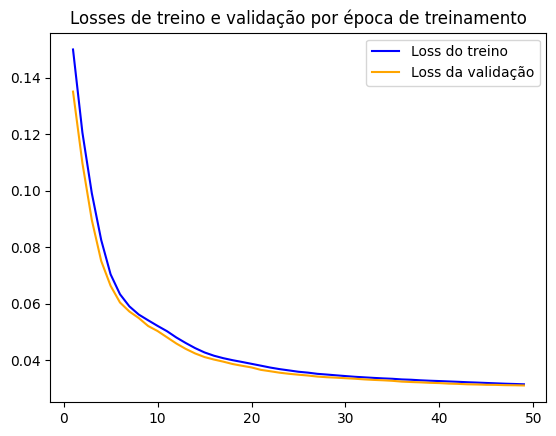

In [ ]:
def plot_train_val_losses(train_avg_losses, val_avg_losses):
  epochs = list(range(1, len(train_avg_losses)+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
  plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')
  plt.title('Losses de treino e validação por época de treinamento')
  plt.legend()

plot_train_val_losses(train_avg_losses, val_avg_losses)

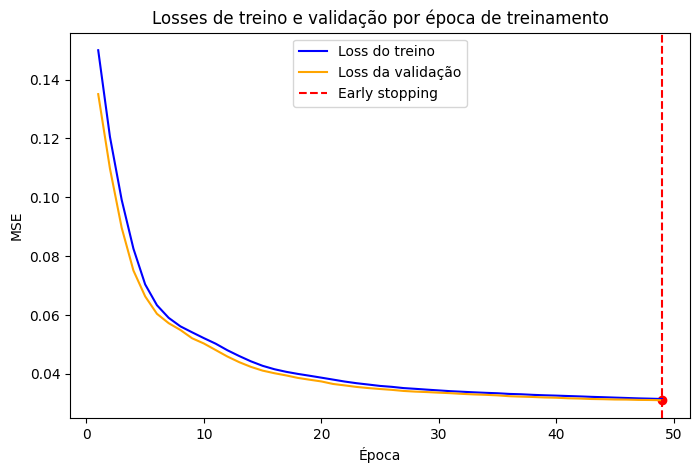

In [ ]:
def plot_train_val_losses_with_es(train_avg_losses, val_avg_losses, early_stop_epoch=None):
    epochs = list(range(1, len(train_avg_losses)+1))

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
    plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')

    # Marca a época do early stopping
    if early_stop_epoch is not None:
        plt.axvline(x=early_stop_epoch, color='red', linestyle='--', label='Early stopping')
        plt.scatter(early_stop_epoch, val_avg_losses[early_stop_epoch-1], color='red')

    plt.title('Losses de treino e validação por época de treinamento')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

# Supondo que early_stop_epoch seja a última época registrada pelo early stopping
# Se você não salvou, pode usar len(val_avg_losses) como aproximação
early_stop_epoch = len(val_avg_losses)
plot_train_val_losses_with_es(train_avg_losses, val_avg_losses, early_stop_epoch)


###**DEFININDO UM THRESHOLD E AVALIANDO RESULTADOS**

####**FUNÇÕES IMPORTANTES**

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

####**CONJUNTO DE VALIDAÇÃO**

In [ ]:
def get_autoencoder_anomaly_scores(ae_model, X):
    X_tensor = torch.FloatTensor(X)
    ae_model.eval()
    with torch.no_grad():
        reconstructed_X = ae_model(X_tensor)
        # MSELoss por amostra: (X - Reconstruído)^2, média sobre as features (axis=1)
        anomaly_scores = torch.mean(torch.pow(X_tensor - reconstructed_X, 2), axis=1).detach().numpy()
    return anomaly_scores

In [ ]:
val_anomaly_scores = get_autoencoder_anomaly_scores(best_model, X_val_np)

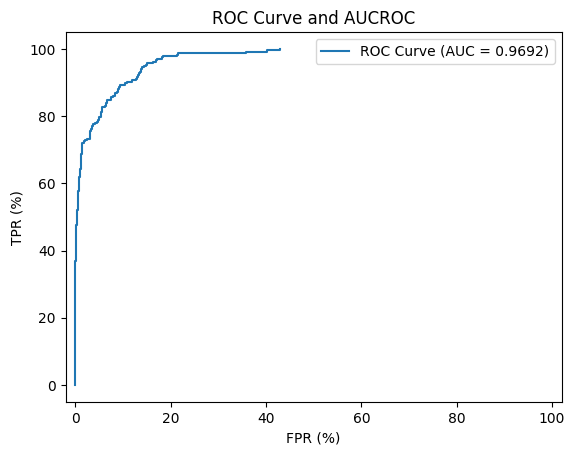

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
best_tau_df = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.03')

# Pega o valor do threshold que está na primeira linha (o melhor)
THRESHOLD = best_tau_df['thresholds'].iloc[0]

TESTANDO LIMIAR: 0.103900
-> Precisão: 0.9005, FPR: 0.0241, Recall: 0.7288


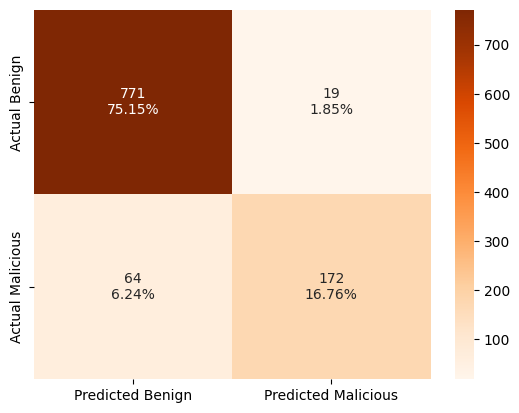

In [ ]:
print(f'TESTANDO LIMIAR: {THRESHOLD:.6f}')

# 1. Gera as previsões (y_pred)
y_pred = val_anomaly_scores > THRESHOLD

# 2. Calcula as métricas (apenas para visualização dos resultados)
metrics = get_overall_metrics(y_val, y_pred)
print(f"-> Precisão: {metrics['precision']:.4f}, FPR: {metrics['fpr']:.4f}, Recall: {metrics['tpr']:.4f}")

plot_confusion_matrix(y_val, y_pred)
plt.show()

In [ ]:
get_tpr_per_attack(classes_val, val_anomaly_scores > THRESHOLD)

{0: 0.024050632911392405, 1: 0.7288135593220338}

####**CONJUNTO DE TESTE**

In [ ]:
test_anomaly_scores = get_autoencoder_anomaly_scores(best_model, X_test_np)

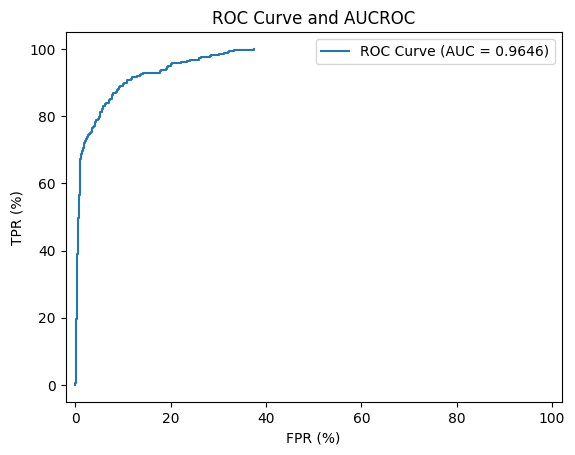

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores)

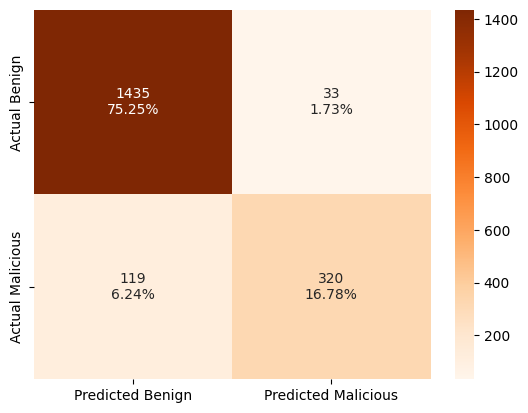

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores > THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores > THRESHOLD)

{'acc': np.float64(0.9202936549554274),
 'tpr': np.float64(0.7289293849658315),
 'fpr': np.float64(0.022479564032697547),
 'precision': np.float64(0.9065155807365439),
 'f1-score': np.float64(0.8080808080808081)}

In [ ]:
get_tpr_per_attack(classes_test, test_anomaly_scores > THRESHOLD)

{0: 0.022479564032697547, 1: 0.7289293849658315}

#**ISOLATION FOREST**

##**FUNÇÕES IMPORTANTES**

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2 * tpr * precision) / (tpr + precision) if (tpr + precision) != 0 else 0.0
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

In [ ]:
def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED)
  X_pca = pca.fit_transform(X)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]

    X_clusters = model_kmeans.predict(X)

    # For each cluster, plot their respective X data instances
    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      if X_pca[indexes,:].shape[1] == 3:
        print(indexes)
      print(X_pca[indexes,:].shape)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    # For each cluster centroid, plot the centroid
    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})

  # Assuming '1' represents the fraudulent class (attack)
  attack_label = 1

  total_attack_instances = aux_df['Label'].value_counts().get(attack_label, 0)

  # Count true positives (actual attack, predicted as True/anomaly)
  true_positives = aux_df.query('Label == @attack_label and prediction == True').shape[0]

  tpr_per_attack = {}
  if total_attack_instances > 0:
    tpr = true_positives / total_attack_instances
  else:
    tpr = 0.0 # No attack instances of this type to detect

  tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

## **TREINAMENTO**


In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.107,  # proporção de anomalias no dataset inteiro
    random_state=42
)

model.fit(X_train)

IsolationForest(contamination=0.107, random_state=42)

## **CONJUNTO DE VALIDAÇÃO**

In [ ]:
# Escores de anomalia para o conjunto de validação
val_anomaly_scores = -model.decision_function(X_val)

print(f"Escores de anomalia calculados para X_val_scaled. Tamanho: {val_anomaly_scores.shape[0]}")

Escores de anomalia calculados para X_val_scaled. Tamanho: 1026


In [ ]:
y_val.value_counts()

Class
0    790
1    236
Name: count, dtype: int64

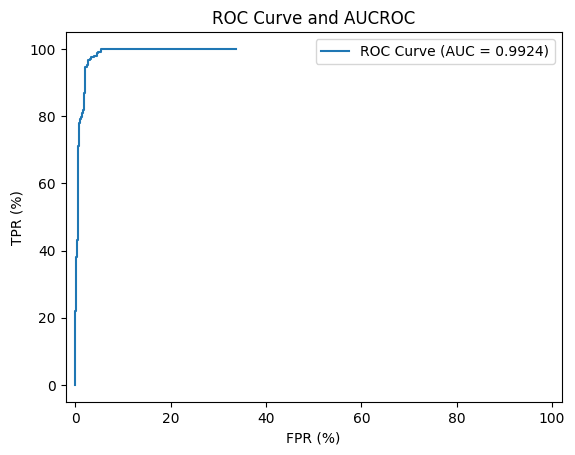

In [ ]:
plot_roc_curve(y_val,val_anomaly_scores)

##**ESCOLHA DO THRESHOLD**

Para avaliar o desempenho do modelo no conjunto de validação, preciso definir um limiar para os escores de anomalia. Vou calcular a estatística J de Youden (tpr – fpr) a partir dos dados da curva ROC para encontrar o limiar ideal que maximize a diferença entre TPR e FPR.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)

# 2. Criar um DataFrame para calcular o Índice de Youden (J = TPR - FPR)
df_val_roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

fpr       tpr  thresholds  youden-index
48  0.054430  1.000000    0.045671      0.945570
44  0.048101  0.991525    0.052585      0.943424
46  0.053165  0.995763    0.048663      0.942598
42  0.045570  0.987288    0.054811      0.941719
38  0.032911  0.974576    0.064543      0.941665
40  0.039241  0.978814    0.060004      0.939573
34  0.026582  0.966102    0.068107      0.939519
36  0.031646  0.970339    0.066836      0.938693
32  0.024051  0.953390    0.070511      0.929339
30  0.020253  0.944915    0.075192      0.924662
28  0.018987  0.868644    0.084775      0.849657
26  0.017722  0.864407    0.085294      0.846685
24  0.016456  0.817797    0.090773      0.801341
22  0.013924  0.809322    0.091931      0.795398
20  0.011392  0.796610    0.094642      0.785218
18  0.010127  0.792373    0.095493      0.782246
16  0.008861  0.779661    0.097402      0.770800
14  0.007595  0.771186    0.098832      0.763592
12  0.006329  0.711864    0.103759      0.705535
49  0.335443  1.000000   -0.040002      0.664557
50  0.337975  1.000000   -0.040161      0.662025
10  0.005063  0.504237    0.120364      0.499174
8   0.003797  0.432203    0.126367      0.428406
6   0.002532  0.381356    0.130206      0.378824
4   0.001266  0.368644    0.132304      0.367378
2   0.000000  0.220339    0.146034      0.220339
51  1.000000  1.000000   -0.109039      0.000000

In [ ]:
BEST_VALIDATION_THRESHOLD =0.045671

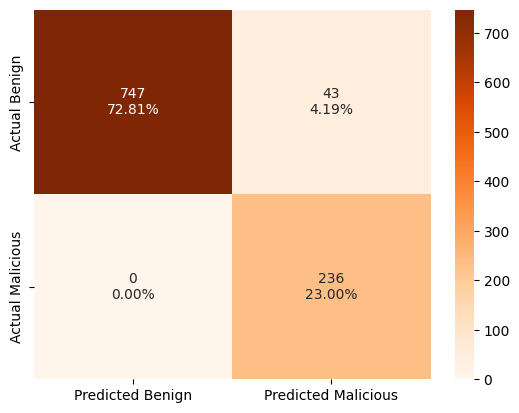

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': np.float64(0.9580896686159844),
 'tpr': np.float64(1.0),
 'fpr': np.float64(0.05443037974683544),
 'precision': np.float64(0.8458781362007168),
 'f1-score': np.float64(0.916504854368932)}

##**TUNAGEM DOS HIPERPÂMETROS**

In [ ]:
import itertools

n_estimators_grid = [100, 200, 300]         # Número de árvores
max_samples_grid = [0.5, 0.75, 1.0]         # Proporção de amostras por árvore
max_features_grid = [0.5, 0.75, 1.0]        # Proporção de features a serem consideradas (NOVO)

param_grid_iforest = list(itertools.product(n_estimators_grid, max_samples_grid, max_features_grid))
results_iforest = {}

for params in param_grid_iforest:
    n_estimators, max_samples, max_features = params[0], params[1], params[2]

    new_model_iforest = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        random_state=RANDOM_SEED,
        contamination=0.107
    )
    new_model_iforest.fit(X_train)

    # Calcular scores de anomalia em X_val (y_score)
    # Isolation Forest: decision_function (Scores MAIS BAIXOS = MAIS ANÔMALO)
    new_val_scores_original = new_model_iforest.decision_function(X_val)
    new_val_anomaly_scores_inverted = -new_val_scores_original


    # Calcular ROC e Youden-index para encontrar o melhor threshold
    fpr, tpr, thresholds = roc_curve(y_val, new_val_anomaly_scores_inverted)
    df_val_roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']

    # Encontrar o threshold que maximiza o Youden-index
    if df_val_roc['youden-index'].max() <= 0:
        BEST_VALIDATION_THRESHOLD = thresholds[0]
    else:
        best_threshold_row = df_val_roc.loc[df_val_roc['youden-index'].idxmax()]
        BEST_VALIDATION_THRESHOLD = best_threshold_row['thresholds']

    # Converter para previsões binárias e calcular métricas
    # Regra de classificação INVERTIDA para decision_function do iF
    new_val_predictions_binary = new_val_anomaly_scores_inverted > BEST_VALIDATION_THRESHOLD

    metrics = get_overall_metrics(y_val, new_val_predictions_binary)

    # Salvar resultados
    results_iforest[params] = {
        'metrics': metrics,
        'y_score_val': new_val_anomaly_scores_inverted,
        'best_threshold': BEST_VALIDATION_THRESHOLD
    }


**Escolhe o melhor baseado na f1**

In [ ]:
F1_METRIC_KEY = 'f1-score'
best_f1 = -1.0
best_params = None

for params, data in results_iforest.items():
    current_metrics = data['metrics']
    current_f1 = current_metrics.get(F1_METRIC_KEY, -1.0)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_params = params


# Exibir os resultados do modelo vencedor
if best_params is not None:
    print(f"Modelo Vencedor (Otimizado por F1-Score: {best_f1:.4f}")

    best_n_estimators, best_max_samples, best_max_features = best_params[0], best_params[1], best_params[2]

    print("\nHiperparâmetros do Isolation Forest Vencedor:")
    print(f"N Estimators | {best_n_estimators} ")
    print(f"Max Samples | {best_max_samples} ")
    print(f"Max Features | {best_max_features} ")

    print("\nMétricas de Validação do Modelo Vencedor")
    winner_metrics = results_iforest[best_params]['metrics']
    for key, value in winner_metrics.items():
        if isinstance(value, (int, float)):
            print(f"{key.replace('_', ' ').title()} | {value:.4f} ")
        else:
            print(f"{key.replace('_', ' ').title()} | {value} ")


Modelo Vencedor (Otimizado por F1-Score: 0.9159

Hiperparâmetros do Isolation Forest Vencedor:
N Estimators | 100 
Max Samples | 0.5 
Max Features | 0.5 

Métricas de Validação do Modelo Vencedor
Acc | 0.9581 
Tpr | 0.9915 
Fpr | 0.0519 
Precision | 0.8509 
F1-Score | 0.9159 


In [ ]:
# Acesse os dados do modelo vencedor
winner_data =  results_iforest[best_params]
winner_y_score = winner_data['y_score_val']
best_threshold = winner_data['best_threshold']

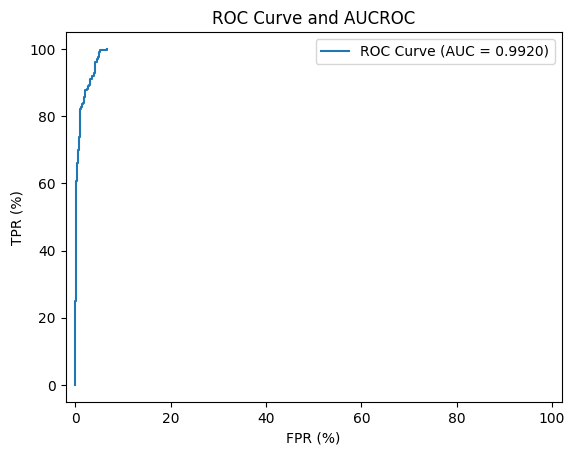

In [ ]:
plot_roc_curve(y_val, winner_y_score)


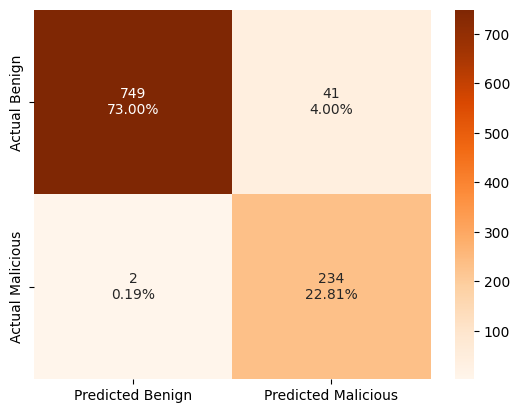

In [ ]:
plot_confusion_matrix(y_val, winner_y_score > best_threshold)

##**CONJUNTO DE TESTE**

**É necessário re-treinar pois o objeto treinado não foi salvo**


In [ ]:
best_n_init, best_max_iter, best_algorithm = best_params[0], best_params[1], best_params[2]

n_estimators, max_samples, max_features =best_params[0], best_params[1], best_params[2]

final_model_iforest = IsolationForest(
    n_estimators=n_estimators,
    max_samples=max_samples,
    max_features=max_features,
    random_state=RANDOM_SEED,
    contamination=0.107
)
final_model_iforest.fit(X_train)


IsolationForest(contamination=0.107, max_features=0.5, max_samples=0.5,
                random_state=99)

In [ ]:
# Calcular scores de anomalia em X_val (y_score)
# Isolation Forest: decision_function (Scores MAIS BAIXOS = MAIS ANÔMALO)
new_test_scores_original = new_model_iforest.decision_function(X_test)
new_test_anomaly_scores_inverted = -new_test_scores_original

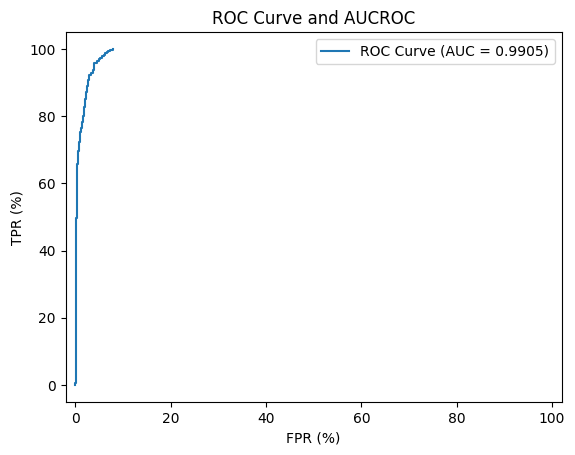

In [ ]:
plot_roc_curve(y_test, new_test_anomaly_scores_inverted)


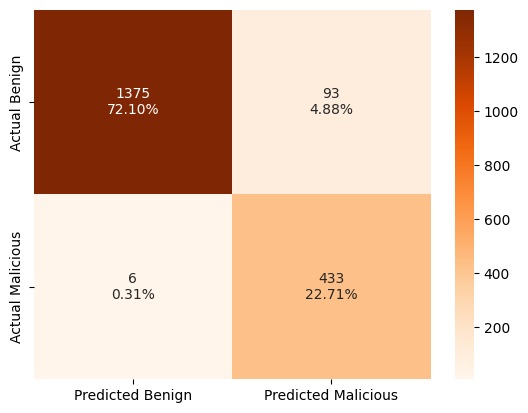

In [ ]:
plot_confusion_matrix(y_test,  new_test_anomaly_scores_inverted > best_threshold)

In [ ]:
get_overall_metrics(y_test,  new_test_anomaly_scores_inverted > best_threshold)


{'acc': np.float64(0.9480859989512324),
 'tpr': np.float64(0.9863325740318907),
 'fpr': np.float64(0.06335149863760219),
 'precision': np.float64(0.8231939163498099),
 'f1-score': np.float64(0.8974093264248705)}